Loaded spontaneous activity: 1000 combinations
Loaded stability analysis: 1000 combinations


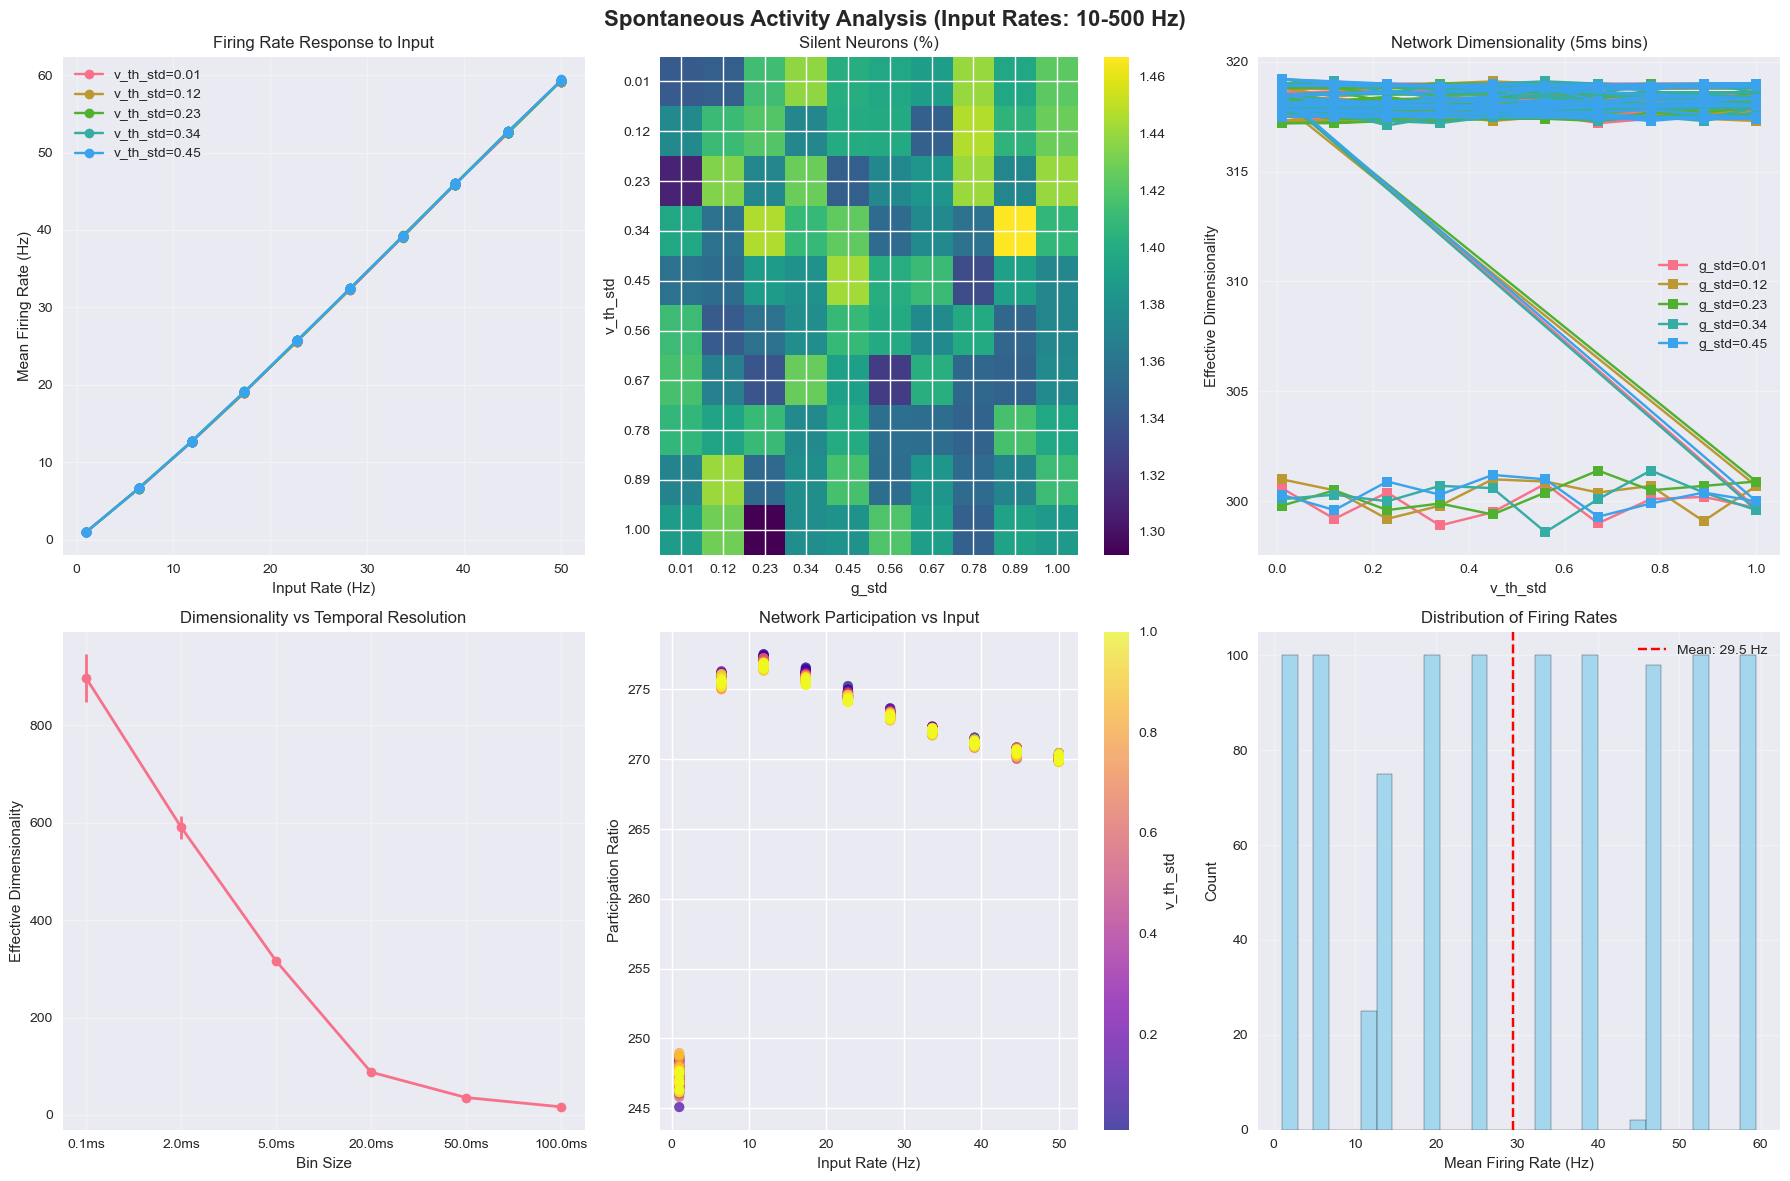

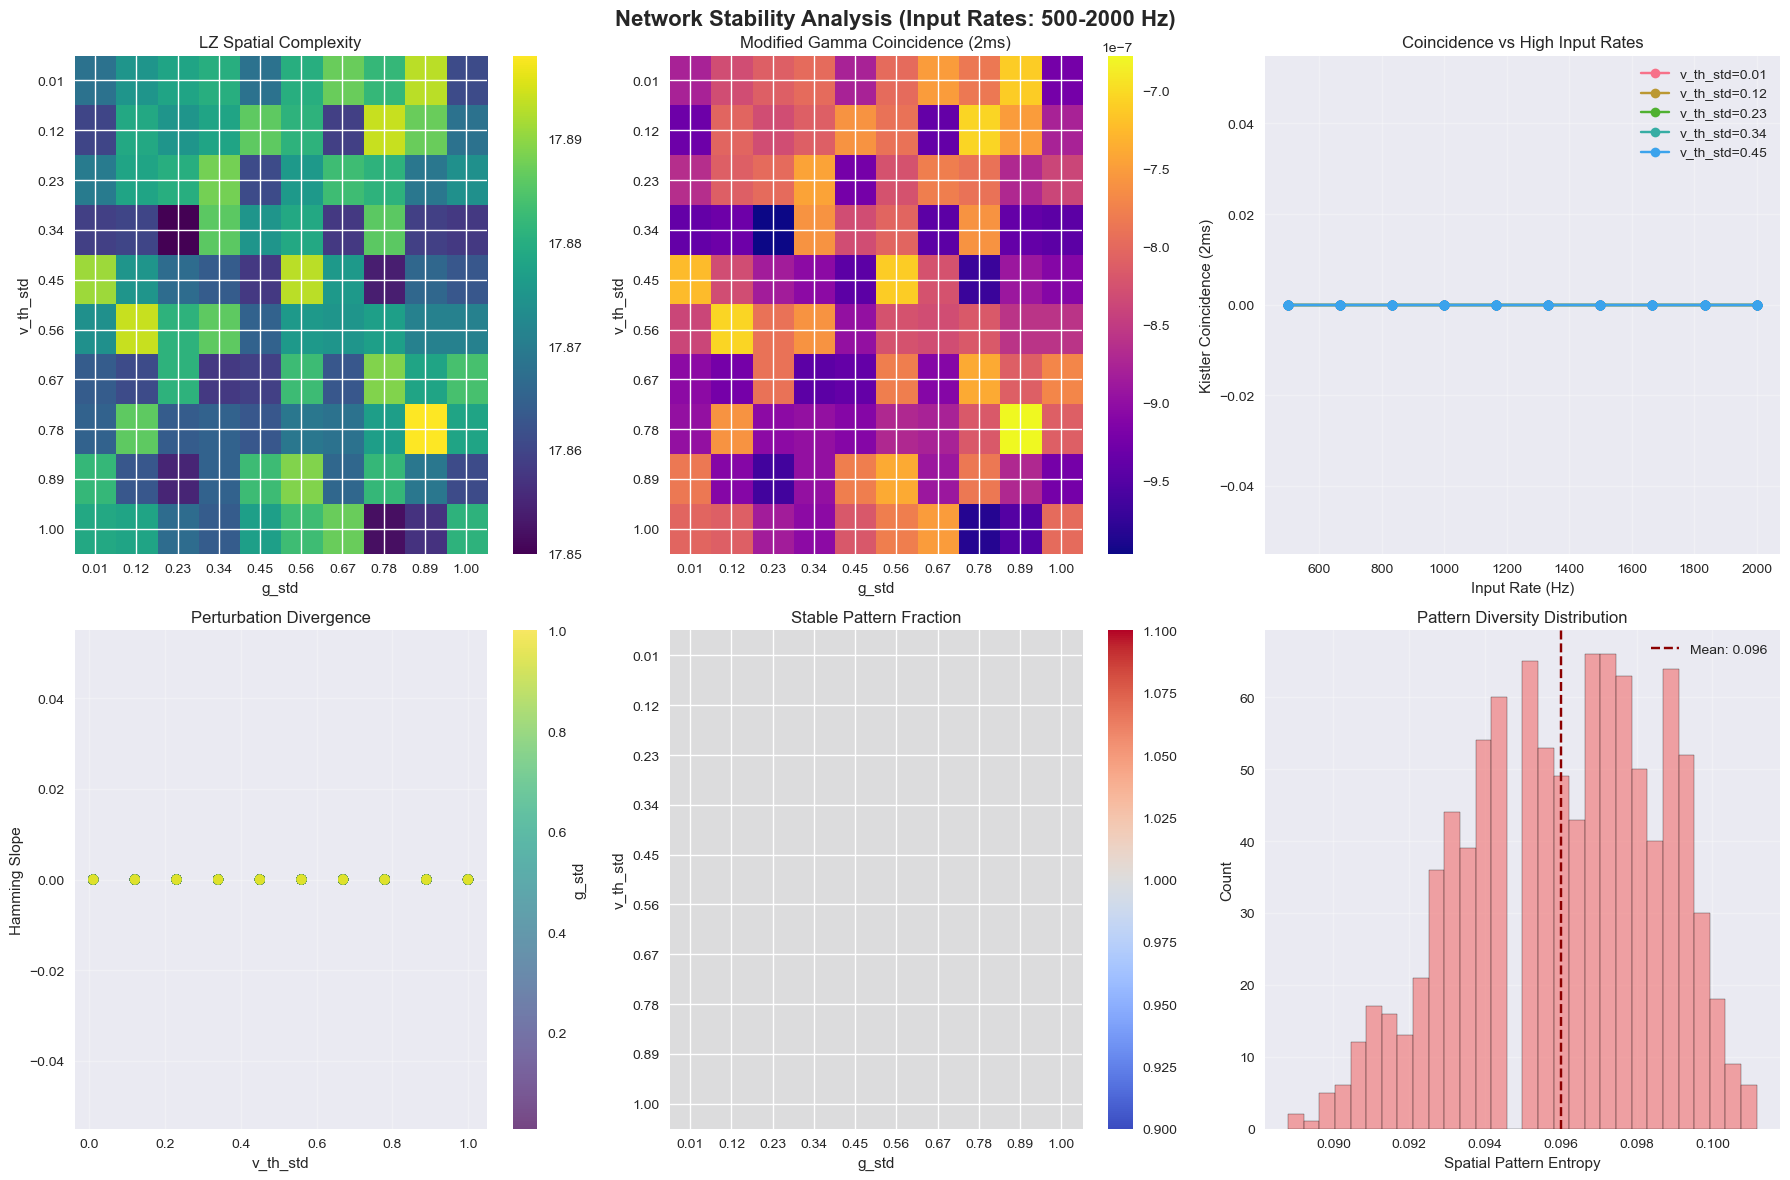

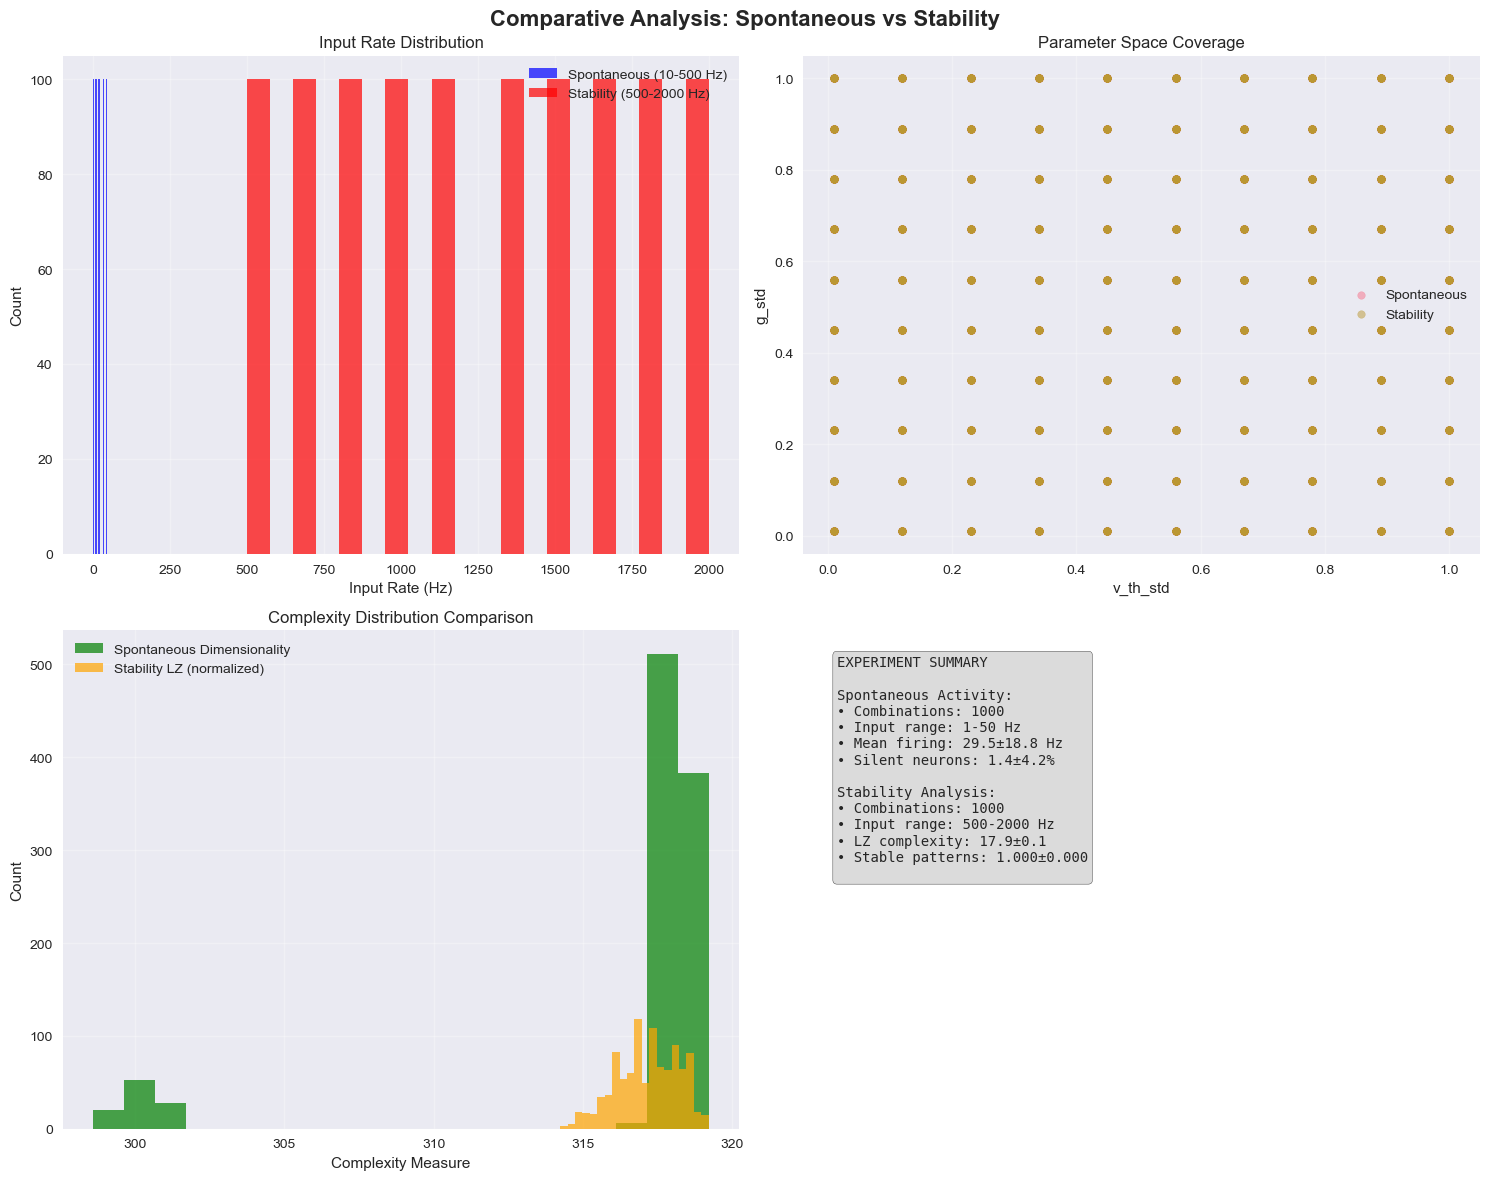

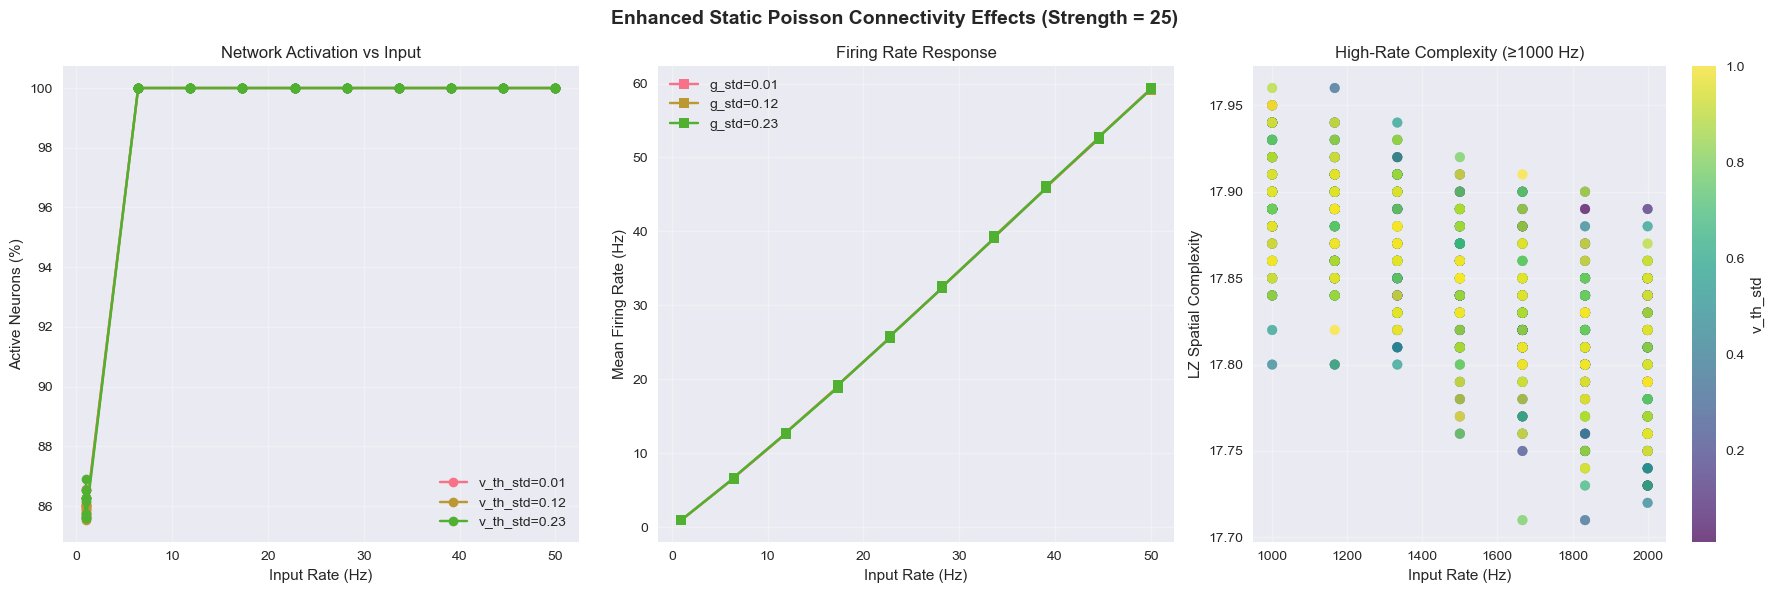


Analysis complete! The plots show:
1. Spontaneous Activity: Firing rates, dimensionality, and network activation patterns
2. Network Stability: LZ complexity, coincidence measures, and pattern stability
3. Comparative Analysis: Differences between low-rate and high-rate regimes
4. Enhanced Connectivity: Effects of 25x stronger static Poisson input


In [1]:
# Split Experiments Analysis - Spontaneous Activity & Network Stability
# Analysis of simulation results from both experiment types

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# 1. LOAD EXPERIMENTAL RESULTS
# =============================================================================

def load_experimental_results():
    """Load results from both experiments"""
    
    # Load spontaneous activity results (session 1, input rates 10-500 Hz)
    spontaneous_file = 'results/data/spontaneous_session_1_dynamic.pkl'
    stability_file = 'results/data/stability_session_2_dynamic.pkl'
    
    try:
        with open(spontaneous_file, 'rb') as f:
            spontaneous_results = pickle.load(f)
        print(f"Loaded spontaneous activity: {len(spontaneous_results)} combinations")
    except FileNotFoundError:
        print(f"Spontaneous results not found: {spontaneous_file}")
        spontaneous_results = []
    
    try:
        with open(stability_file, 'rb') as f:
            stability_results = pickle.load(f)
        print(f"Loaded stability analysis: {len(stability_results)} combinations")
    except FileNotFoundError:
        print(f"Stability results not found: {stability_file}")
        stability_results = []
    
    return spontaneous_results, stability_results

# Load the data
spontaneous_data, stability_data = load_experimental_results()

# =============================================================================
# 2. SPONTANEOUS ACTIVITY ANALYSIS PLOTS
# =============================================================================

def plot_spontaneous_activity_analysis(data):
    """Create comprehensive plots for spontaneous activity data"""
    
    if not data:
        print("No spontaneous activity data to plot")
        return
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(data)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Spontaneous Activity Analysis (Input Rates: 10-500 Hz)', fontsize=16, fontweight='bold')
    
    # 1. Firing Rate vs Input Rate
    ax1 = axes[0, 0]
    for v_th in df['v_th_std'].unique()[:5]:  # Show first 5 v_th values
        subset = df[df['v_th_std'] == v_th]
        ax1.plot(subset['static_input_rate'], subset['mean_firing_rate_mean'], 
                marker='o', label=f'v_th_std={v_th:.2f}')
    ax1.set_xlabel('Input Rate (Hz)')
    ax1.set_ylabel('Mean Firing Rate (Hz)')
    ax1.set_title('Firing Rate Response to Input')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Silent Neurons vs Heterogeneity
    ax2 = axes[0, 1]
    pivot_silent = df.pivot_table(values='percent_silent_mean', 
                                 index='v_th_std', columns='g_std', aggfunc='mean')
    im1 = ax2.imshow(pivot_silent.values, aspect='auto', cmap='viridis')
    ax2.set_xticks(range(len(pivot_silent.columns)))
    ax2.set_xticklabels([f'{x:.2f}' for x in pivot_silent.columns])
    ax2.set_yticks(range(len(pivot_silent.index)))
    ax2.set_yticklabels([f'{x:.2f}' for x in pivot_silent.index])
    ax2.set_xlabel('g_std')
    ax2.set_ylabel('v_th_std')
    ax2.set_title('Silent Neurons (%)')
    plt.colorbar(im1, ax=ax2)
    
    # 3. Dimensionality Analysis (5ms bin)
    ax3 = axes[0, 2]
    for g in df['g_std'].unique()[:5]:  # Show first 5 g values
        subset = df[df['g_std'] == g]
        ax3.plot(subset['v_th_std'], subset['effective_dimensionality_bin_5.0ms_mean'], 
                marker='s', label=f'g_std={g:.2f}')
    ax3.set_xlabel('v_th_std')
    ax3.set_ylabel('Effective Dimensionality')
    ax3.set_title('Network Dimensionality (5ms bins)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Multi-bin Dimensionality Comparison
    ax4 = axes[1, 0]
    bin_sizes = ['0.1ms', '2.0ms', '5.0ms', '20.0ms', '50.0ms', '100.0ms']
    dim_means = []
    dim_stds = []
    
    for bin_size in bin_sizes:
        col_name = f'effective_dimensionality_bin_{bin_size}_mean'
        if col_name in df.columns:
            dim_means.append(df[col_name].mean())
            dim_stds.append(df[col_name].std())
        else:
            dim_means.append(0)
            dim_stds.append(0)
    
    ax4.errorbar(range(len(bin_sizes)), dim_means, yerr=dim_stds, 
                marker='o', capsize=5, linewidth=2)
    ax4.set_xticks(range(len(bin_sizes)))
    ax4.set_xticklabels(bin_sizes)
    ax4.set_xlabel('Bin Size')
    ax4.set_ylabel('Effective Dimensionality')
    ax4.set_title('Dimensionality vs Temporal Resolution')
    ax4.grid(True, alpha=0.3)
    
    # 5. Participation Ratio vs Input Rate
    ax5 = axes[1, 1]
    if 'participation_ratio_bin_5.0ms_mean' in df.columns:
        scatter = ax5.scatter(df['static_input_rate'], df['participation_ratio_bin_5.0ms_mean'], 
                            c=df['v_th_std'], cmap='plasma', alpha=0.7)
        ax5.set_xlabel('Input Rate (Hz)')
        ax5.set_ylabel('Participation Ratio')
        ax5.set_title('Network Participation vs Input')
        plt.colorbar(scatter, ax=ax5, label='v_th_std')
    else:
        ax5.text(0.5, 0.5, 'Participation ratio data\nnot available', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Participation Ratio (Missing)')
    
    # 6. Firing Rate Distribution
    ax6 = axes[1, 2]
    firing_rates = df['mean_firing_rate_mean'].values
    ax6.hist(firing_rates, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax6.axvline(np.mean(firing_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(firing_rates):.1f} Hz')
    ax6.set_xlabel('Mean Firing Rate (Hz)')
    ax6.set_ylabel('Count')
    ax6.set_title('Distribution of Firing Rates')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot spontaneous activity results
plot_spontaneous_activity_analysis(spontaneous_data)

# =============================================================================
# 3. NETWORK STABILITY ANALYSIS PLOTS
# =============================================================================

def plot_stability_analysis(data):
    """Create comprehensive plots for network stability data"""
    
    if not data:
        print("No stability data to plot")
        return
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Network Stability Analysis (Input Rates: 500-2000 Hz)', fontsize=16, fontweight='bold')
    
    # 1. LZ Spatial Complexity Heatmap
    ax1 = axes[0, 0]
    pivot_lz = df.pivot_table(values='lz_spatial_patterns_mean', 
                             index='v_th_std', columns='g_std', aggfunc='mean')
    im1 = ax1.imshow(pivot_lz.values, aspect='auto', cmap='viridis')
    ax1.set_xticks(range(len(pivot_lz.columns)))
    ax1.set_xticklabels([f'{x:.2f}' for x in pivot_lz.columns])
    ax1.set_yticks(range(len(pivot_lz.index)))
    ax1.set_yticklabels([f'{x:.2f}' for x in pivot_lz.index])
    ax1.set_xlabel('g_std')
    ax1.set_ylabel('v_th_std')
    ax1.set_title('LZ Spatial Complexity')
    plt.colorbar(im1, ax=ax1)
    
    # 2. Modified Gamma Coincidence (2ms)
    ax2 = axes[0, 1]
    if 'gamma_window_2ms_mean' in df.columns:
        pivot_gamma = df.pivot_table(values='gamma_window_2ms_mean', 
                                   index='v_th_std', columns='g_std', aggfunc='mean')
        im2 = ax2.imshow(pivot_gamma.values, aspect='auto', cmap='plasma')
        ax2.set_xticks(range(len(pivot_gamma.columns)))
        ax2.set_xticklabels([f'{x:.2f}' for x in pivot_gamma.columns])
        ax2.set_yticks(range(len(pivot_gamma.index)))
        ax2.set_yticklabels([f'{x:.2f}' for x in pivot_gamma.index])
        ax2.set_xlabel('g_std')
        ax2.set_ylabel('v_th_std')
        ax2.set_title('Modified Gamma Coincidence (2ms)')
        plt.colorbar(im2, ax=ax2)
    else:
        ax2.text(0.5, 0.5, 'Gamma coincidence\ndata not available', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # 3. Kistler Coincidence vs Input Rate
    ax3 = axes[0, 2]
    if 'kistler_delta_2ms_mean' in df.columns:
        for v_th in df['v_th_std'].unique()[:5]:
            subset = df[df['v_th_std'] == v_th]
            ax3.plot(subset['static_input_rate'], subset['kistler_delta_2ms_mean'], 
                    marker='o', label=f'v_th_std={v_th:.2f}')
        ax3.set_xlabel('Input Rate (Hz)')
        ax3.set_ylabel('Kistler Coincidence (2ms)')
        ax3.set_title('Coincidence vs High Input Rates')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Kistler coincidence\ndata not available', 
                ha='center', va='center', transform=ax3.transAxes)
    
    # 4. Hamming Distance Slope
    ax4 = axes[1, 0]
    if 'hamming_slope_mean' in df.columns:
        scatter = ax4.scatter(df['v_th_std'], df['hamming_slope_mean'], 
                            c=df['g_std'], cmap='viridis', alpha=0.7)
        ax4.set_xlabel('v_th_std')
        ax4.set_ylabel('Hamming Slope')
        ax4.set_title('Perturbation Divergence')
        plt.colorbar(scatter, ax=ax4, label='g_std')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Hamming slope\ndata not available', 
                ha='center', va='center', transform=ax4.transAxes)
    
    # 5. Pattern Stability
    ax5 = axes[1, 1]
    if 'stable_pattern_fraction' in df.columns:
        pivot_stable = df.pivot_table(values='stable_pattern_fraction', 
                                    index='v_th_std', columns='g_std', aggfunc='mean')
        im3 = ax5.imshow(pivot_stable.values, aspect='auto', cmap='coolwarm')
        ax5.set_xticks(range(len(pivot_stable.columns)))
        ax5.set_xticklabels([f'{x:.2f}' for x in pivot_stable.columns])
        ax5.set_yticks(range(len(pivot_stable.index)))
        ax5.set_yticklabels([f'{x:.2f}' for x in pivot_stable.index])
        ax5.set_xlabel('g_std')
        ax5.set_ylabel('v_th_std')
        ax5.set_title('Stable Pattern Fraction')
        plt.colorbar(im3, ax=ax5)
    else:
        ax5.text(0.5, 0.5, 'Pattern stability\ndata not available', 
                ha='center', va='center', transform=ax5.transAxes)
    
    # 6. Spatial Entropy
    ax6 = axes[1, 2]
    if 'spatial_entropy_mean' in df.columns:
        entropy_vals = df['spatial_entropy_mean'].values
        ax6.hist(entropy_vals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        ax6.axvline(np.mean(entropy_vals), color='darkred', linestyle='--', 
                   label=f'Mean: {np.mean(entropy_vals):.3f}')
        ax6.set_xlabel('Spatial Pattern Entropy')
        ax6.set_ylabel('Count')
        ax6.set_title('Pattern Diversity Distribution')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Spatial entropy\ndata not available', 
                ha='center', va='center', transform=ax6.transAxes)
    
    plt.tight_layout()
    plt.show()

# Plot stability analysis results
plot_stability_analysis(stability_data)

# =============================================================================
# 4. COMPARATIVE ANALYSIS
# =============================================================================

def plot_comparative_analysis(spontaneous_data, stability_data):
    """Compare results from both experiments"""
    
    if not spontaneous_data or not stability_data:
        print("Need both datasets for comparative analysis")
        return
    
    # Convert to DataFrames
    df_spont = pd.DataFrame(spontaneous_data)
    df_stab = pd.DataFrame(stability_data)
    
    # Create comparison figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparative Analysis: Spontaneous vs Stability', fontsize=16, fontweight='bold')
    
    # 1. Input Rate Ranges Comparison
    ax1 = axes[0, 0]
    ax1.hist(df_spont['static_input_rate'], bins=20, alpha=0.7, 
            label='Spontaneous (10-500 Hz)', color='blue')
    ax1.hist(df_stab['static_input_rate'], bins=20, alpha=0.7, 
            label='Stability (500-2000 Hz)', color='red')
    ax1.set_xlabel('Input Rate (Hz)')
    ax1.set_ylabel('Count')
    ax1.set_title('Input Rate Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Heterogeneity Parameter Space
    ax2 = axes[0, 1]
    ax2.scatter(df_spont['v_th_std'], df_spont['g_std'], 
               alpha=0.5, label='Spontaneous', s=30)
    ax2.scatter(df_stab['v_th_std'], df_stab['g_std'], 
               alpha=0.5, label='Stability', s=30)
    ax2.set_xlabel('v_th_std')
    ax2.set_ylabel('g_std')
    ax2.set_title('Parameter Space Coverage')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Complexity Measures (if available in both)
    ax3 = axes[1, 0]
    if 'effective_dimensionality_bin_5.0ms_mean' in df_spont.columns:
        dim_spont = df_spont['effective_dimensionality_bin_5.0ms_mean']
        ax3.hist(dim_spont, bins=20, alpha=0.7, label='Spontaneous Dimensionality', color='green')
    
    if 'lz_spatial_patterns_mean' in df_stab.columns:
        lz_stab = df_stab['lz_spatial_patterns_mean']
        # Normalize LZ to similar scale as dimensionality for comparison
        lz_normalized = lz_stab / np.max(lz_stab) * np.max(dim_spont) if 'effective_dimensionality_bin_5.0ms_mean' in df_spont.columns else lz_stab
        ax3.hist(lz_normalized, bins=20, alpha=0.7, label='Stability LZ (normalized)', color='orange')
    
    ax3.set_xlabel('Complexity Measure')
    ax3.set_ylabel('Count')
    ax3.set_title('Complexity Distribution Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Summary Statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary text
    summary_text = "EXPERIMENT SUMMARY\n\n"
    summary_text += f"Spontaneous Activity:\n"
    summary_text += f"• Combinations: {len(df_spont)}\n"
    summary_text += f"• Input range: {df_spont['static_input_rate'].min():.0f}-{df_spont['static_input_rate'].max():.0f} Hz\n"
    if 'mean_firing_rate_mean' in df_spont.columns:
        summary_text += f"• Mean firing: {df_spont['mean_firing_rate_mean'].mean():.1f}±{df_spont['mean_firing_rate_mean'].std():.1f} Hz\n"
    if 'percent_silent_mean' in df_spont.columns:
        summary_text += f"• Silent neurons: {df_spont['percent_silent_mean'].mean():.1f}±{df_spont['percent_silent_mean'].std():.1f}%\n"
    
    summary_text += f"\nStability Analysis:\n"
    summary_text += f"• Combinations: {len(df_stab)}\n"
    summary_text += f"• Input range: {df_stab['static_input_rate'].min():.0f}-{df_stab['static_input_rate'].max():.0f} Hz\n"
    if 'lz_spatial_patterns_mean' in df_stab.columns:
        summary_text += f"• LZ complexity: {df_stab['lz_spatial_patterns_mean'].mean():.1f}±{df_stab['lz_spatial_patterns_mean'].std():.1f}\n"
    if 'stable_pattern_fraction' in df_stab.columns:
        summary_text += f"• Stable patterns: {df_stab['stable_pattern_fraction'].mean():.3f}±{df_stab['stable_pattern_fraction'].std():.3f}\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Create comparative analysis
plot_comparative_analysis(spontaneous_data, stability_data)

# =============================================================================
# 5. ENHANCED CONNECTIVITY ANALYSIS
# =============================================================================

def plot_enhanced_connectivity_effects(spontaneous_data, stability_data):
    """Analyze effects of enhanced static Poisson connectivity (strength 25)"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Enhanced Static Poisson Connectivity Effects (Strength = 25)', fontsize=14, fontweight='bold')
    
    if spontaneous_data:
        df_spont = pd.DataFrame(spontaneous_data)
        
        # 1. Network Activation Threshold
        ax1 = axes[0]
        if 'percent_silent_mean' in df_spont.columns:
            for v_th in df_spont['v_th_std'].unique()[:3]:
                subset = df_spont[df_spont['v_th_std'] == v_th]
                ax1.plot(subset['static_input_rate'], 100 - subset['percent_silent_mean'], 
                        marker='o', label=f'v_th_std={v_th:.2f}')
            ax1.set_xlabel('Input Rate (Hz)')
            ax1.set_ylabel('Active Neurons (%)')
            ax1.set_title('Network Activation vs Input')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
        
        # 2. Firing Rate Saturation
        ax2 = axes[1]
        if 'mean_firing_rate_mean' in df_spont.columns:
            # Show saturation behavior
            for g in df_spont['g_std'].unique()[:3]:
                subset = df_spont[df_spont['g_std'] == g]
                ax2.plot(subset['static_input_rate'], subset['mean_firing_rate_mean'], 
                        marker='s', label=f'g_std={g:.2f}')
            ax2.set_xlabel('Input Rate (Hz)')
            ax2.set_ylabel('Mean Firing Rate (Hz)')
            ax2.set_title('Firing Rate Response')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
    
    # 3. High Rate Regime Analysis
    ax3 = axes[2]
    if stability_data:
        df_stab = pd.DataFrame(stability_data)
        if 'lz_spatial_patterns_mean' in df_stab.columns:
            # Show complexity at high rates
            high_rates = df_stab[df_stab['static_input_rate'] >= 1000]
            if len(high_rates) > 0:
                scatter = ax3.scatter(high_rates['static_input_rate'], high_rates['lz_spatial_patterns_mean'], 
                                    c=high_rates['v_th_std'], cmap='viridis', alpha=0.7)
                ax3.set_xlabel('Input Rate (Hz)')
                ax3.set_ylabel('LZ Spatial Complexity')
                ax3.set_title('High-Rate Complexity (≥1000 Hz)')
                plt.colorbar(scatter, ax=ax3, label='v_th_std')
                ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze enhanced connectivity effects
plot_enhanced_connectivity_effects(spontaneous_data, stability_data)

print("\nAnalysis complete! The plots show:")
print("1. Spontaneous Activity: Firing rates, dimensionality, and network activation patterns")
print("2. Network Stability: LZ complexity, coincidence measures, and pattern stability")
print("3. Comparative Analysis: Differences between low-rate and high-rate regimes")
print("4. Enhanced Connectivity: Effects of 25x stronger static Poisson input")

Loaded spontaneous activity: 1000 combinations
Loaded stability analysis: 1000 combinations
Enhanced Spontaneous Activity Analysis:


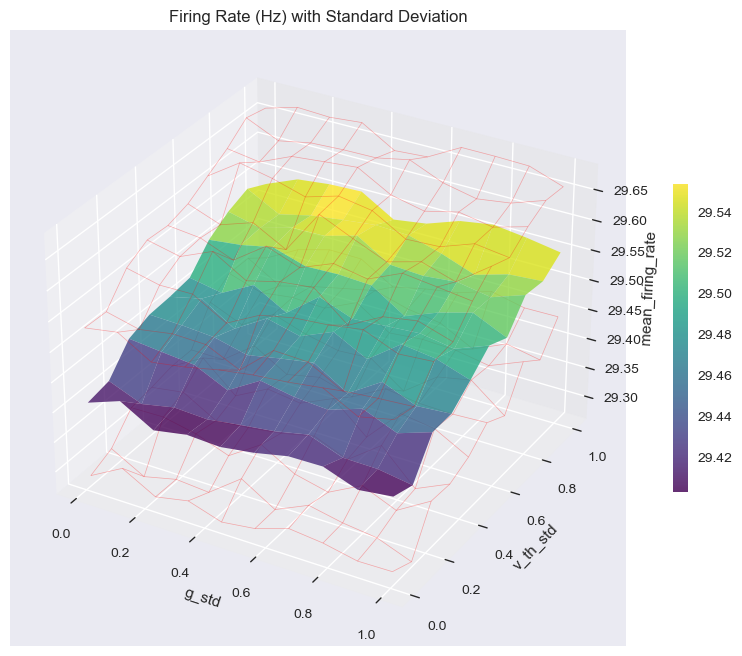

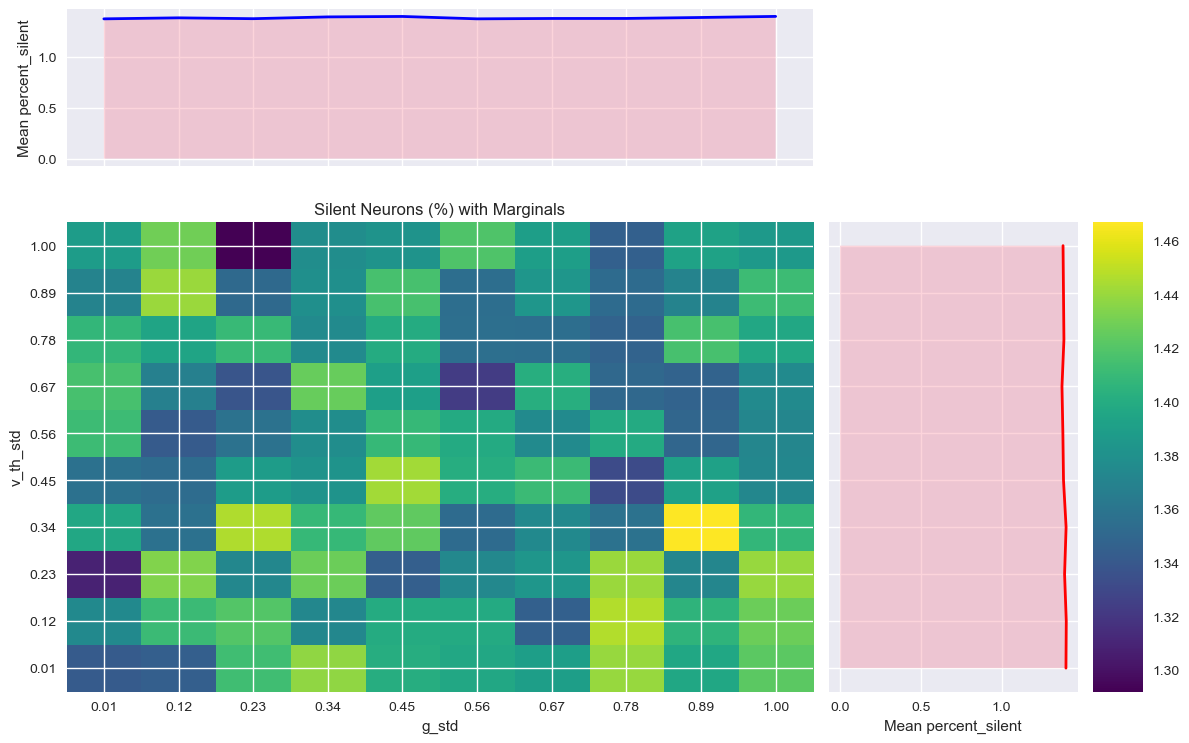

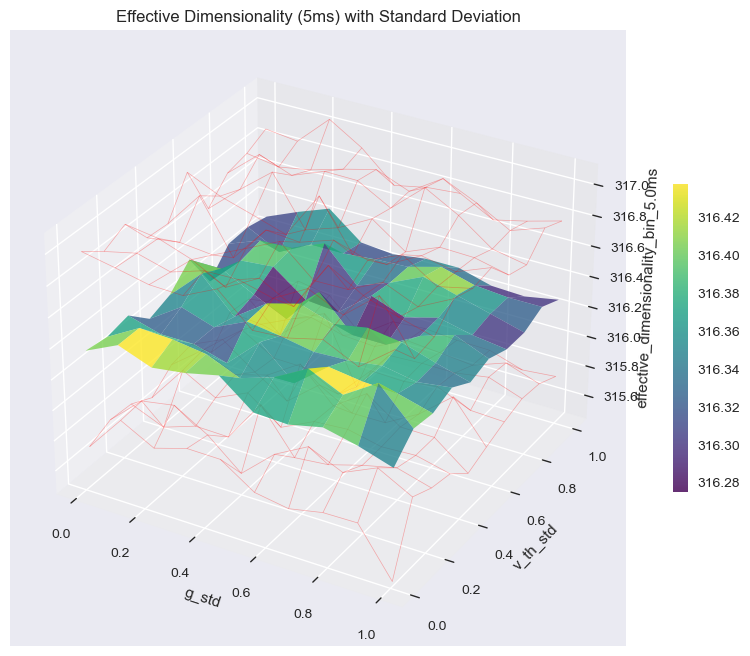

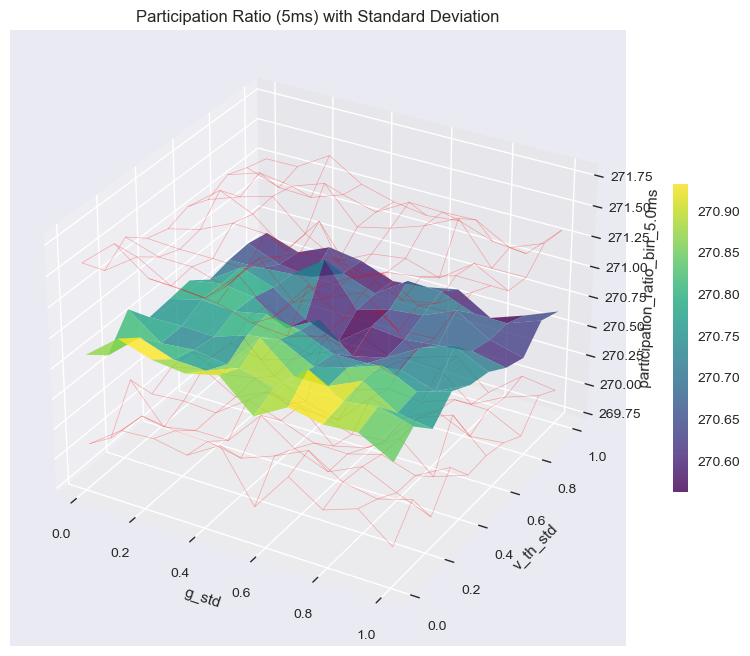

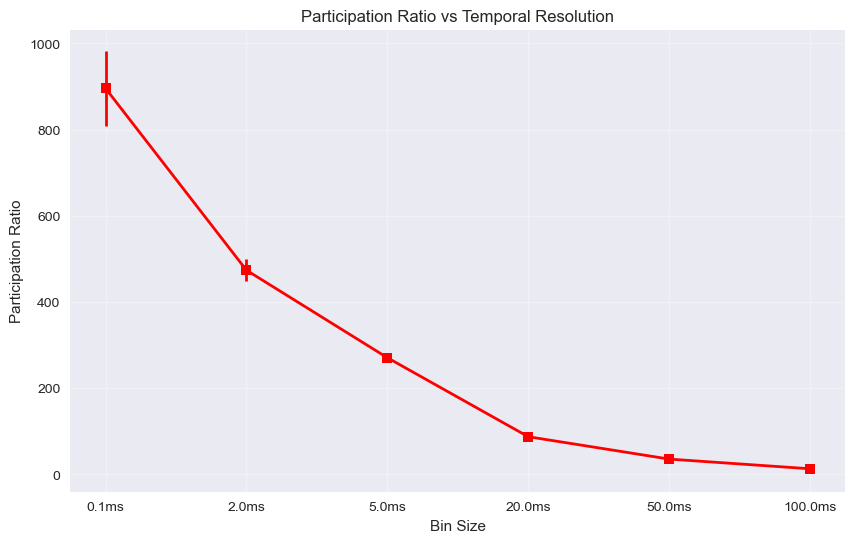

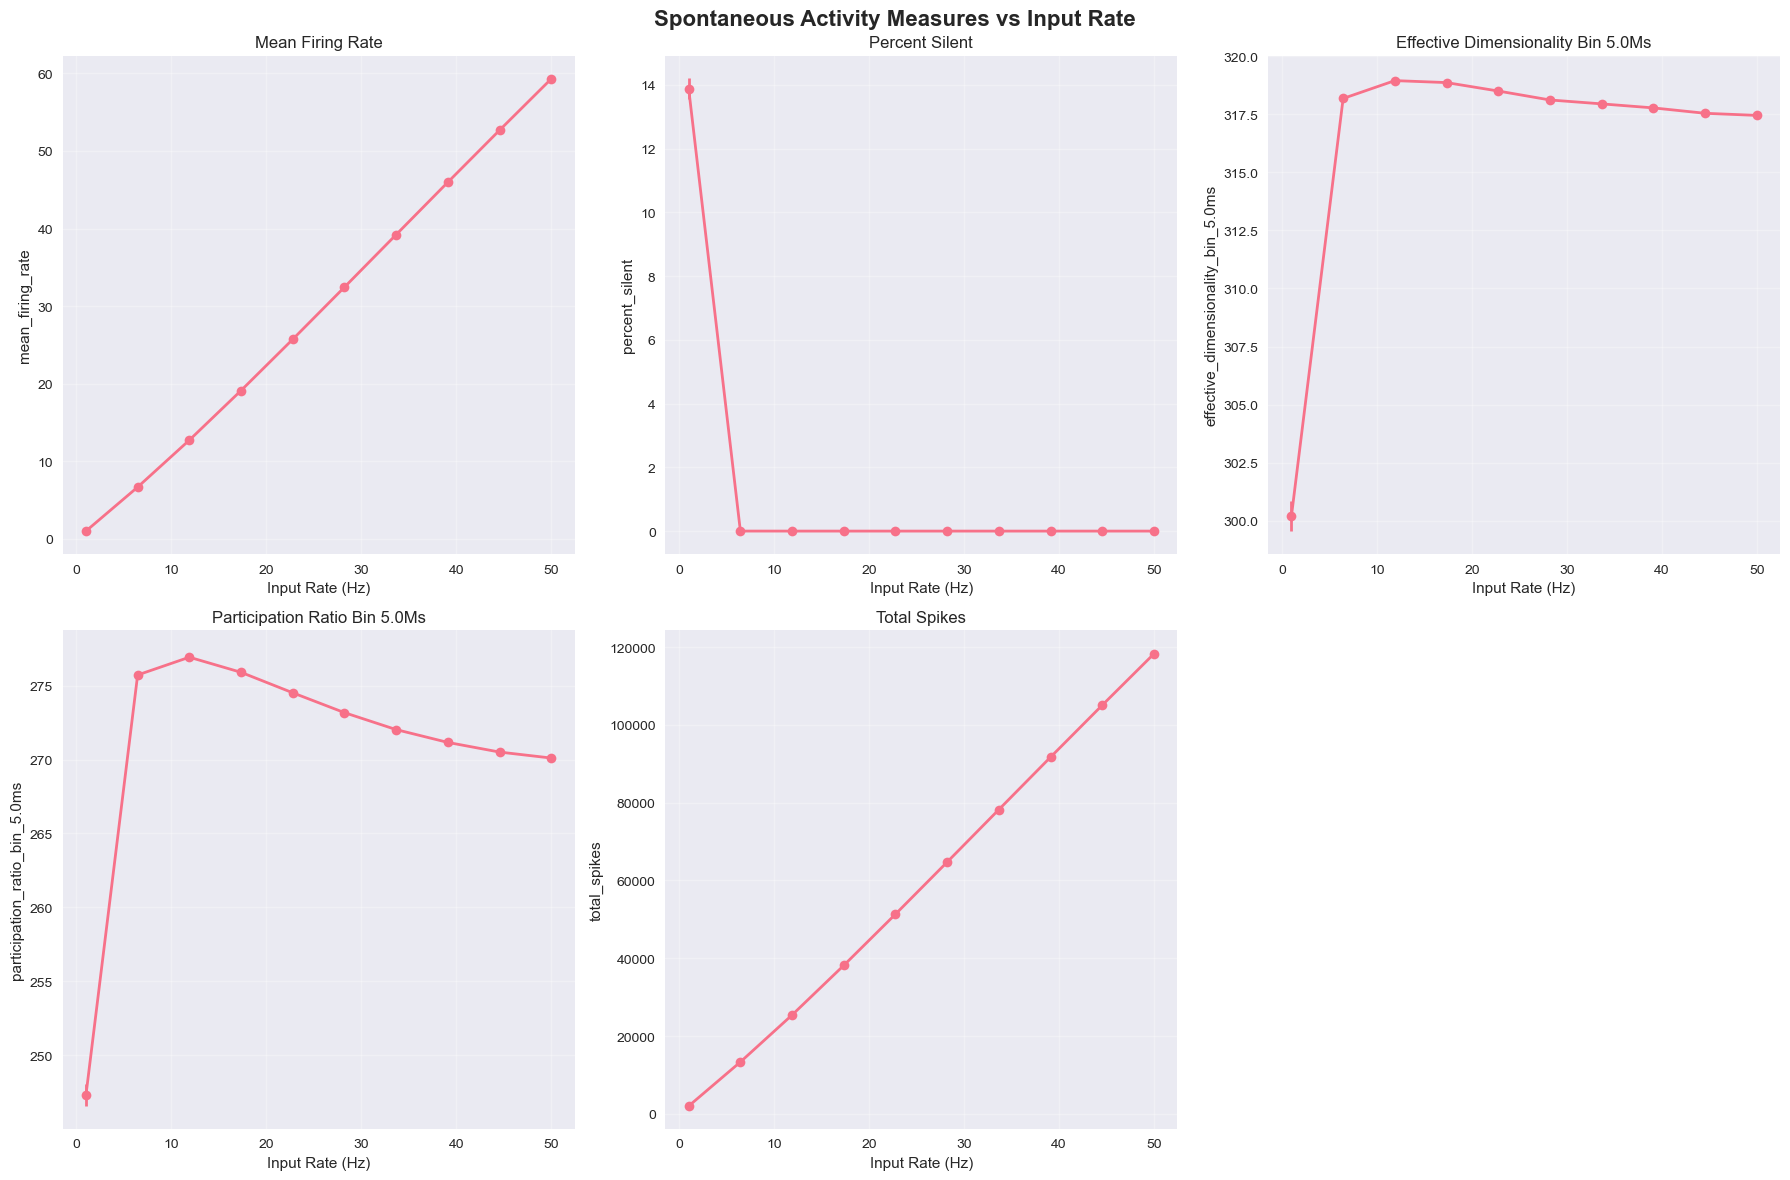


Enhanced Network Stability Analysis:


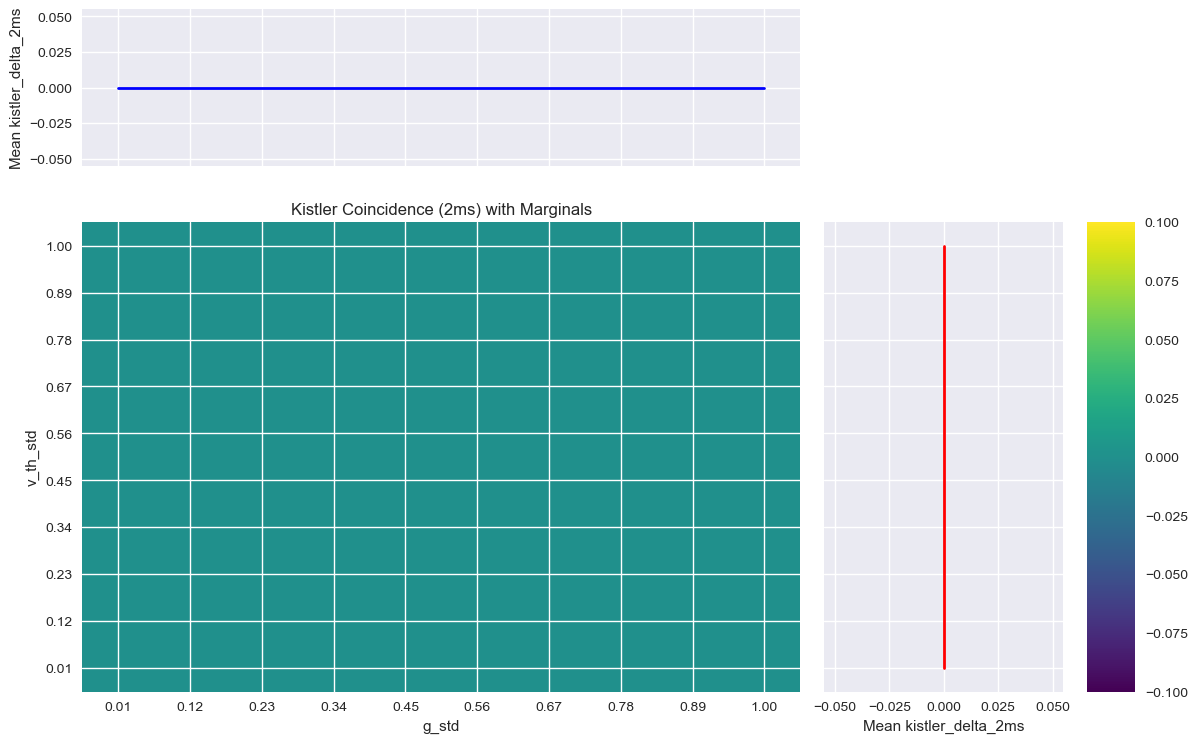

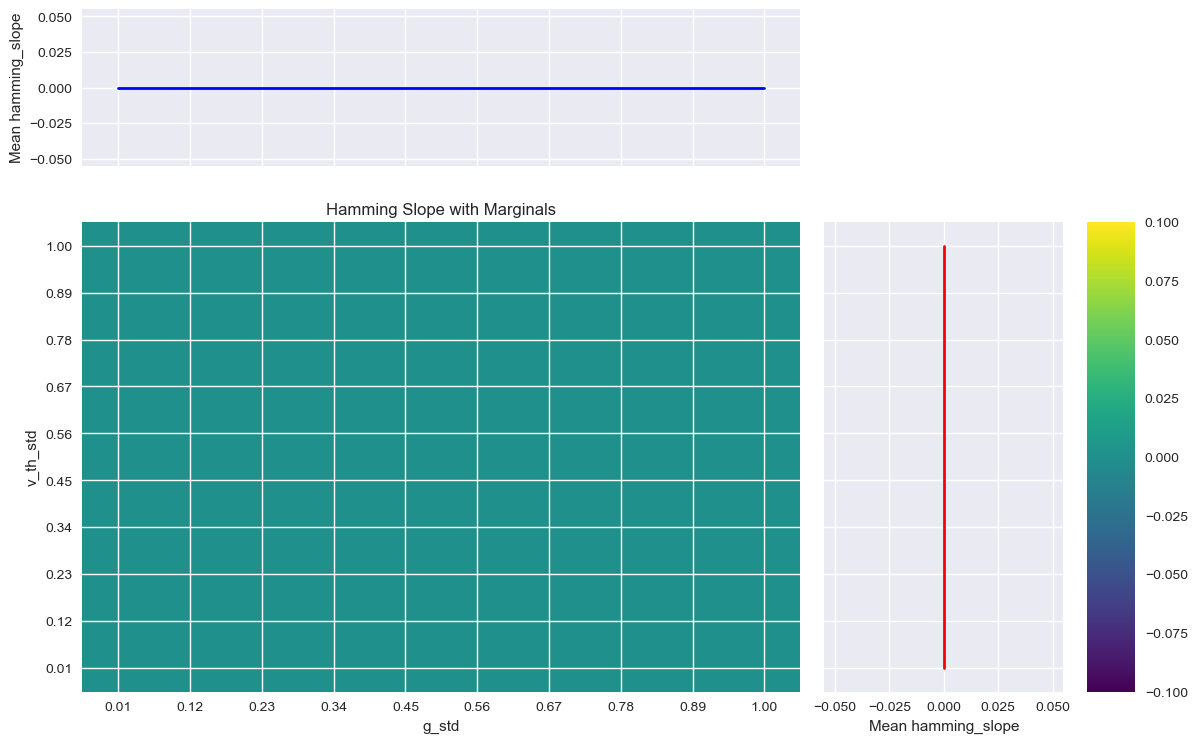

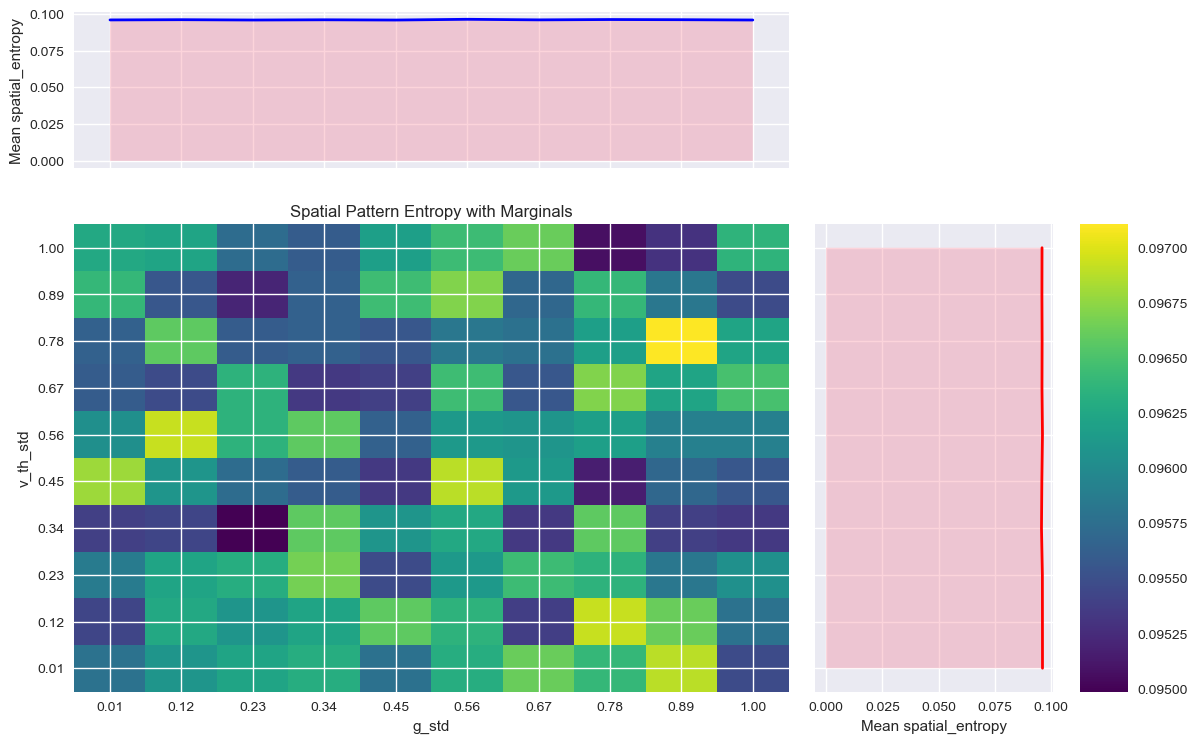

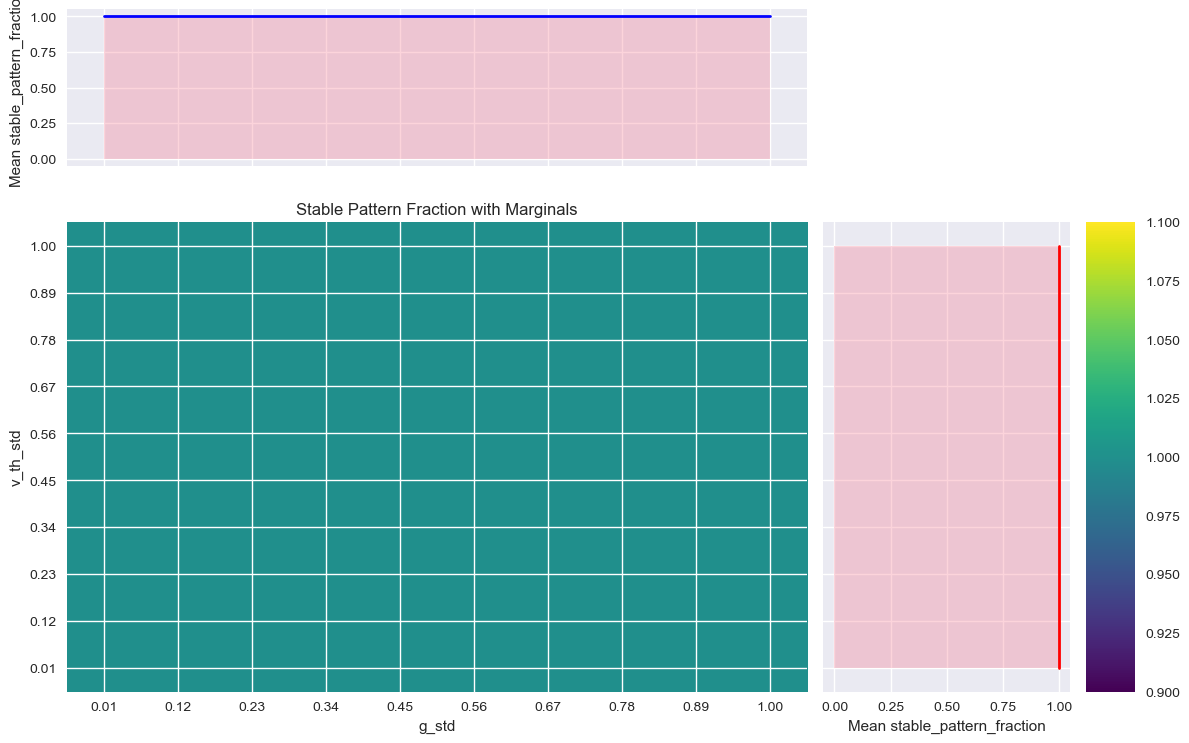

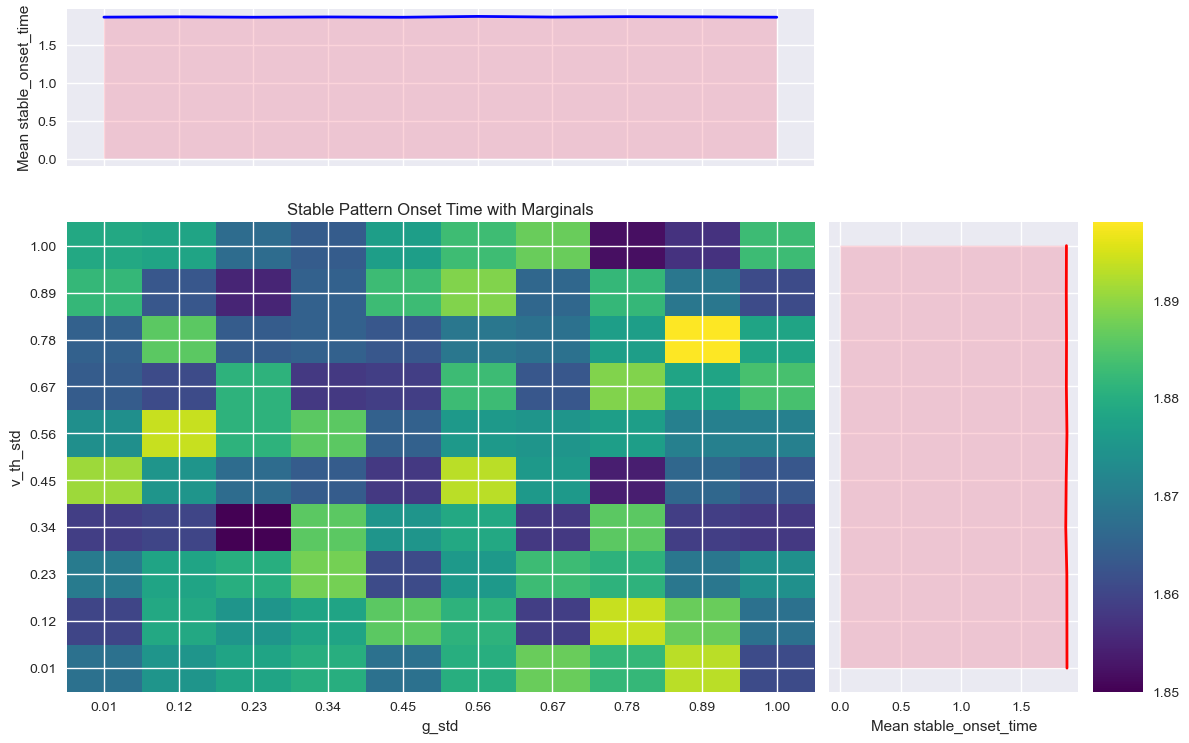

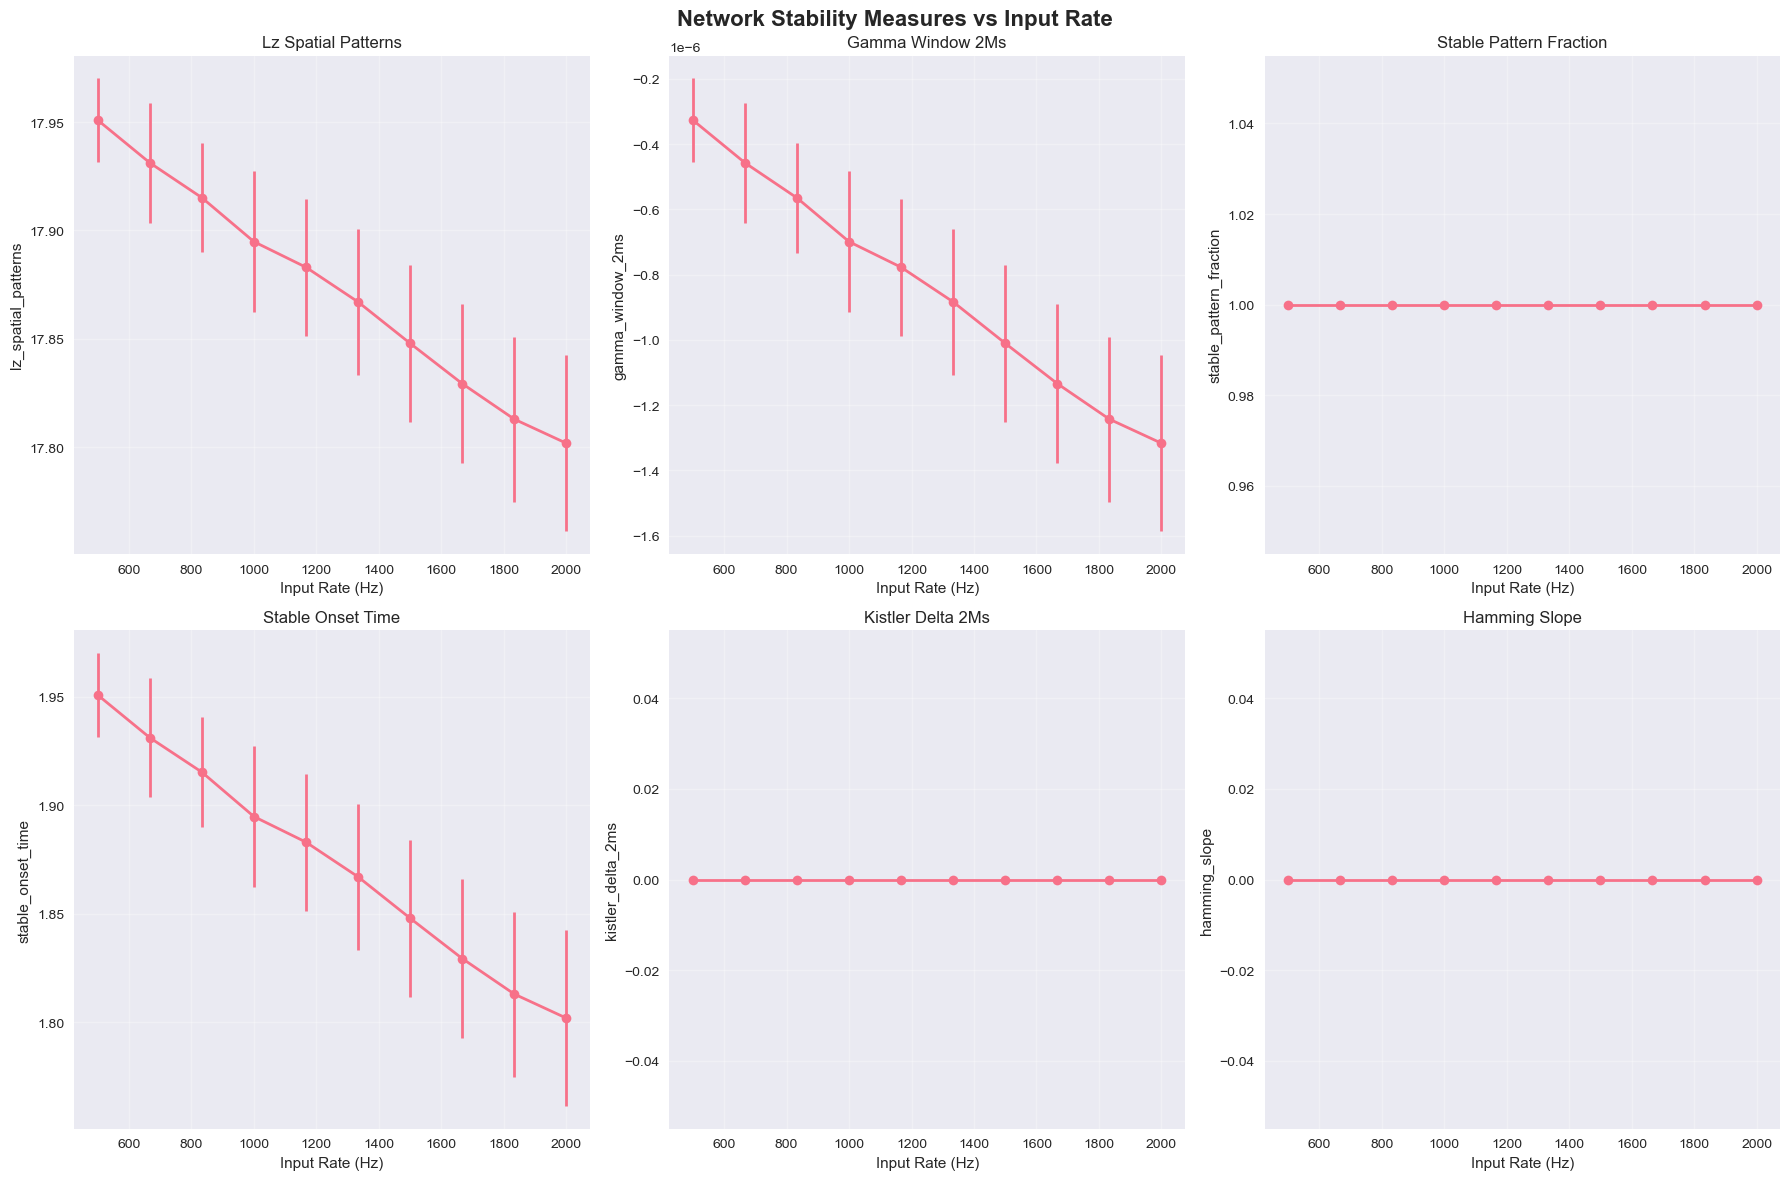


Enhanced analysis complete!
Features added:
• 3D surface plots with error visualization
• Heatmaps with marginal distributions
• Participation ratio vs temporal resolution
• All measures averaged and plotted vs input rate
• Proper v_th_std ordering (0.01 to 1.0, bottom to top)


In [2]:
# Enhanced Split Experiments Analysis - 3D Plots and Marginals
# Updated analysis with 3D surface plots and marginal distributions

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# 1. LOAD EXPERIMENTAL RESULTS
# =============================================================================

def load_experimental_results():
    """Load results from both experiments"""
    
    # Load spontaneous activity results (session 1, input rates 10-500 Hz)
    spontaneous_file = 'results/data/spontaneous_session_1_dynamic.pkl'
    stability_file = 'results/data/stability_session_2_dynamic.pkl'
    
    try:
        with open(spontaneous_file, 'rb') as f:
            spontaneous_results = pickle.load(f)
        print(f"Loaded spontaneous activity: {len(spontaneous_results)} combinations")
    except FileNotFoundError:
        print(f"Spontaneous results not found: {spontaneous_file}")
        spontaneous_results = []
    
    try:
        with open(stability_file, 'rb') as f:
            stability_results = pickle.load(f)
        print(f"Loaded stability analysis: {len(stability_results)} combinations")
    except FileNotFoundError:
        print(f"Stability results not found: {stability_file}")
        stability_results = []
    
    return spontaneous_results, stability_results

# Load the data
spontaneous_data, stability_data = load_experimental_results()

# =============================================================================
# 2. HELPER FUNCTIONS FOR 3D PLOTS AND MARGINALS
# =============================================================================

def create_3d_surface_with_error(df, x_col, y_col, z_col, z_std_col, title):
    """Create 3D surface plot with error visualization"""
    # Create pivot tables
    pivot_z = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    pivot_std = df.pivot_table(values=z_std_col, index=y_col, columns=x_col, aggfunc='mean')
    
    # Create meshgrid
    X, Y = np.meshgrid(pivot_z.columns, pivot_z.index)
    Z = pivot_z.values
    Z_std = pivot_std.values
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Main surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    
    # Error bars as wireframe above and below
    ax.plot_wireframe(X, Y, Z + Z_std, alpha=0.3, color='red', linewidth=0.5)
    ax.plot_wireframe(X, Y, Z - Z_std, alpha=0.3, color='red', linewidth=0.5)
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col.replace('_mean', ''))
    ax.set_title(title)
    
    plt.colorbar(surf, ax=ax, shrink=0.5)
    return fig, ax

def create_heatmap_with_marginals(df, x_col, y_col, z_col, title, y_order_ascending=True):
    """Create heatmap with marginal plots"""
    # Create pivot table
    pivot = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    
    # Sort y-axis if needed
    if not y_order_ascending:
        pivot = pivot.sort_index(ascending=False)
    
    # Create figure with GridSpec for layout
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 1, 0.2], height_ratios=[1, 3, 0.2])
    
    # Main heatmap
    ax_main = fig.add_subplot(gs[1, 0])
    im = ax_main.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')
    ax_main.set_xticks(range(len(pivot.columns)))
    ax_main.set_xticklabels([f'{x:.2f}' for x in pivot.columns])
    ax_main.set_yticks(range(len(pivot.index)))
    ax_main.set_yticklabels([f'{y:.2f}' for y in pivot.index])
    ax_main.set_xlabel(x_col)
    ax_main.set_ylabel(y_col)
    ax_main.set_title(title)
    
    # Top marginal (average over y_col)
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
    marginal_x = pivot.mean(axis=0)
    ax_top.plot(range(len(marginal_x)), marginal_x.values, 'b-', linewidth=2)
    ax_top.fill_between(range(len(marginal_x)), marginal_x.values, alpha=0.3)
    ax_top.set_ylabel(f'Mean {z_col.replace("_mean", "")}')
    ax_top.tick_params(labelbottom=False)
    
    # Right marginal (average over x_col)
    ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
    marginal_y = pivot.mean(axis=1)
    ax_right.plot(marginal_y.values, range(len(marginal_y)), 'r-', linewidth=2)
    ax_right.fill_betweenx(range(len(marginal_y)), marginal_y.values, alpha=0.3)
    ax_right.set_xlabel(f'Mean {z_col.replace("_mean", "")}')
    ax_right.tick_params(labelleft=False)
    
    # Colorbar
    ax_cbar = fig.add_subplot(gs[1, 2])
    plt.colorbar(im, cax=ax_cbar)
    
    plt.tight_layout()
    return fig

def plot_measures_vs_input_rate(df, measures, title):
    """Plot multiple measures averaged across parameter combinations vs input rate"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, measure in enumerate(measures):
        if i >= len(axes):
            break
            
        ax = axes[i]
        if measure in df.columns:
            # Group by input rate and compute mean and std across parameter combinations
            grouped = df.groupby('static_input_rate')[measure].agg(['mean', 'std'])
            
            ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                       marker='o', capsize=5, linewidth=2)
            ax.set_xlabel('Input Rate (Hz)')
            ax.set_ylabel(measure.replace('_mean', ''))
            ax.set_title(f'{measure.replace("_mean", "").replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'{measure}\nnot available', 
                   ha='center', va='center', transform=ax.transAxes)
    
    # Hide unused subplots
    for i in range(len(measures), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig

# =============================================================================
# 3. ENHANCED SPONTANEOUS ACTIVITY ANALYSIS
# =============================================================================

def plot_enhanced_spontaneous_activity(data):
    """Create enhanced plots for spontaneous activity data"""
    
    if not data:
        print("No spontaneous activity data to plot")
        return
    
    df = pd.DataFrame(data)
    
    # 1. 3D Firing Rate with Error Bars
    if 'mean_firing_rate_mean' in df.columns and 'mean_firing_rate_std' in df.columns:
        fig1, ax1 = create_3d_surface_with_error(df, 'g_std', 'v_th_std', 
                                                'mean_firing_rate_mean', 'mean_firing_rate_std',
                                                'Firing Rate (Hz) with Standard Deviation')
        plt.show()
    
    # 2. Silent Neurons Heatmap with Marginals (v_th_std ordered bottom to top)
    if 'percent_silent_mean' in df.columns:
        fig2 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'percent_silent_mean',
                                           'Silent Neurons (%) with Marginals', y_order_ascending=True)
        plt.show()
    
    # 3. 3D Effective Dimensionality
    if 'effective_dimensionality_bin_5.0ms_mean' in df.columns and 'effective_dimensionality_bin_5.0ms_std' in df.columns:
        fig3, ax3 = create_3d_surface_with_error(df, 'g_std', 'v_th_std',
                                                'effective_dimensionality_bin_5.0ms_mean', 
                                                'effective_dimensionality_bin_5.0ms_std',
                                                'Effective Dimensionality (5ms) with Standard Deviation')
        plt.show()
    
    # 4. 3D Participation Ratio
    if 'participation_ratio_bin_5.0ms_mean' in df.columns and 'participation_ratio_bin_5.0ms_std' in df.columns:
        fig4, ax4 = create_3d_surface_with_error(df, 'g_std', 'v_th_std',
                                                'participation_ratio_bin_5.0ms_mean',
                                                'participation_ratio_bin_5.0ms_std',
                                                'Participation Ratio (5ms) with Standard Deviation')
        plt.show()
    
    # 5. Participation Ratio vs Temporal Resolution
    bin_sizes = ['0.1ms', '2.0ms', '5.0ms', '20.0ms', '50.0ms', '100.0ms']
    pr_means = []
    pr_stds = []
    
    for bin_size in bin_sizes:
        col_name = f'participation_ratio_bin_{bin_size}_mean'
        if col_name in df.columns:
            pr_means.append(df[col_name].mean())
            pr_stds.append(df[col_name].std())
        else:
            pr_means.append(0)
            pr_stds.append(0)
    
    fig5, ax5 = plt.subplots(figsize=(10, 6))
    ax5.errorbar(range(len(bin_sizes)), pr_means, yerr=pr_stds, 
                marker='s', capsize=5, linewidth=2, color='red')
    ax5.set_xticks(range(len(bin_sizes)))
    ax5.set_xticklabels(bin_sizes)
    ax5.set_xlabel('Bin Size')
    ax5.set_ylabel('Participation Ratio')
    ax5.set_title('Participation Ratio vs Temporal Resolution')
    ax5.grid(True, alpha=0.3)
    plt.show()
    
    # 6. All Measures vs Input Rate
    spontaneous_measures = [
        'mean_firing_rate_mean',
        'percent_silent_mean', 
        'effective_dimensionality_bin_5.0ms_mean',
        'participation_ratio_bin_5.0ms_mean',
        'total_spikes_mean'
    ]
    
    fig6 = plot_measures_vs_input_rate(df, spontaneous_measures, 
                                      'Spontaneous Activity Measures vs Input Rate')
    plt.show()

# =============================================================================
# 4. ENHANCED STABILITY ANALYSIS
# =============================================================================

def plot_enhanced_stability_analysis(data):
    """Create enhanced plots for network stability data"""
    
    if not data:
        print("No stability data to plot")
        return
    
    df = pd.DataFrame(data)
    
    # 1. Kistler Coincidence Heatmap with Marginals
    if 'kistler_delta_2ms_mean' in df.columns:
        fig1 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'kistler_delta_2ms_mean',
                                           'Kistler Coincidence (2ms) with Marginals')
        plt.show()
    
    # 2. Hamming Slope Heatmap with Marginals
    if 'hamming_slope_mean' in df.columns:
        fig2 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'hamming_slope_mean',
                                           'Hamming Slope with Marginals')
        plt.show()
    
    # 3. Spatial Entropy Heatmap with Marginals
    if 'spatial_entropy_mean' in df.columns:
        fig3 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'spatial_entropy_mean',
                                           'Spatial Pattern Entropy with Marginals')
        plt.show()
    
    # 4. Stable Pattern Fraction Heatmap with Marginals
    if 'stable_pattern_fraction' in df.columns:
        fig4 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'stable_pattern_fraction',
                                           'Stable Pattern Fraction with Marginals')
        plt.show()
    
    # 5. Stable Pattern Onset Time Heatmap with Marginals
    if 'stable_onset_time_mean' in df.columns:
        fig5 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'stable_onset_time_mean',
                                           'Stable Pattern Onset Time with Marginals')
        plt.show()
    
    # 6. All Stability Measures vs Input Rate
    stability_measures = [
        'lz_spatial_patterns_mean',
        'gamma_window_2ms_mean',
        'stable_pattern_fraction',
        'stable_onset_time_mean',
        'kistler_delta_2ms_mean',
        'hamming_slope_mean',
        'spatial_entropy_mean'
    ]
    
    fig6 = plot_measures_vs_input_rate(df, stability_measures,
                                      'Network Stability Measures vs Input Rate')
    plt.show()

# =============================================================================
# 5. EXECUTE ENHANCED ANALYSIS
# =============================================================================

print("Enhanced Spontaneous Activity Analysis:")
print("=" * 50)
plot_enhanced_spontaneous_activity(spontaneous_data)

print("\nEnhanced Network Stability Analysis:")
print("=" * 50)
plot_enhanced_stability_analysis(stability_data)

print("\nEnhanced analysis complete!")
print("Features added:")
print("• 3D surface plots with error visualization")
print("• Heatmaps with marginal distributions")
print("• Participation ratio vs temporal resolution")
print("• All measures averaged and plotted vs input rate")
print("• Proper v_th_std ordering (0.01 to 1.0, bottom to top)")

Simulation Parameters:
  Network size: 1000 neurons
  Duration: 1000.0 ms
  v_th_std: 0
  g_std: 0
  Static input rate: 1000.0 Hz
  Synaptic mode: dynamic

Network initialized successfully!
  Threshold mean: -55.00 mV
  Threshold std: 0.000 mV
  Weight connections: 99792
  Weight mean: 0.000
  Weight std: 0.000

Running simulation...
Simulation completed!
  Total spikes: 53000
  Average firing rate: 53.00 Hz


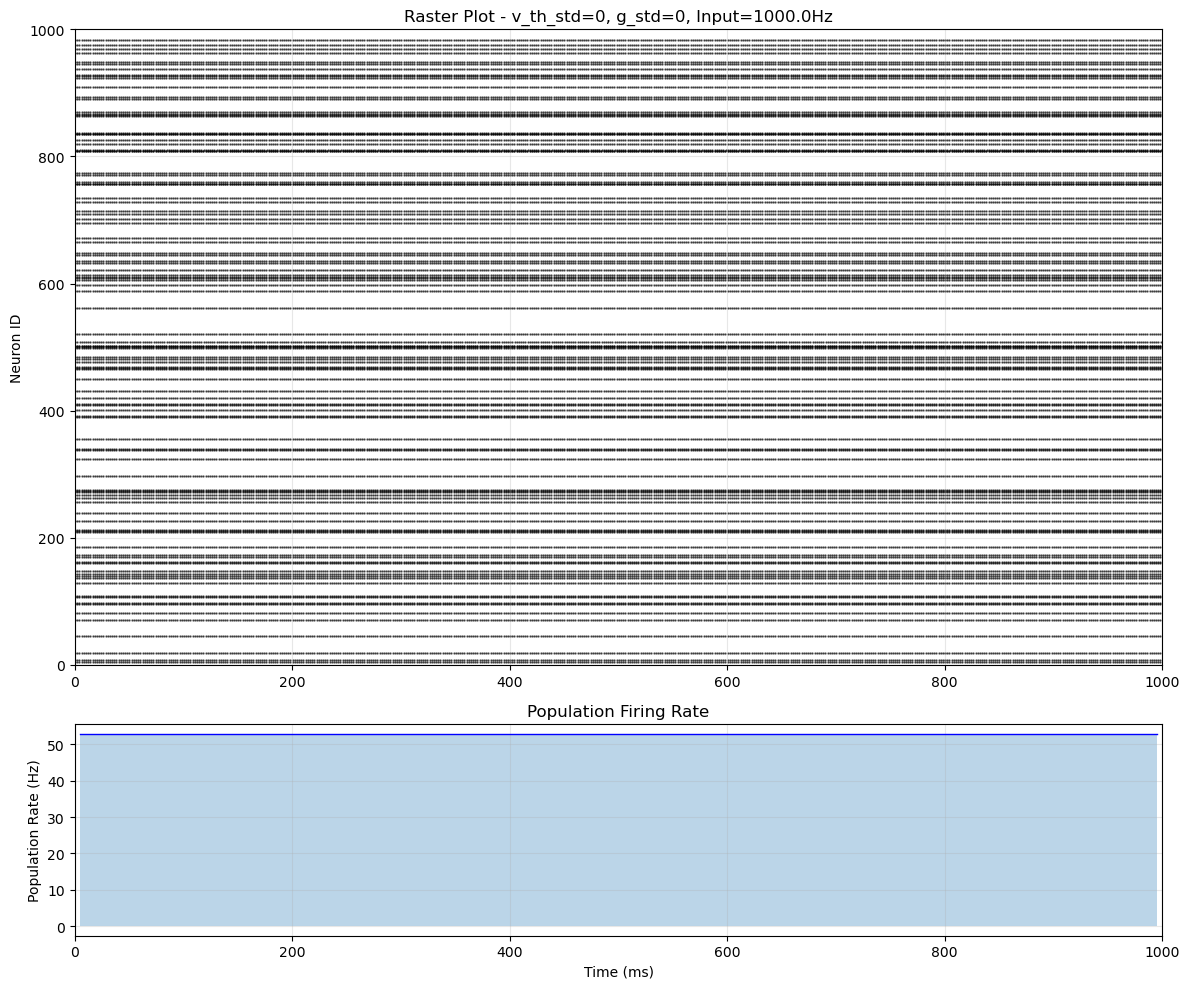


Spike Statistics:
  Total spikes: 53000
  Mean firing rate: 53.00 ± 153.92 Hz
  Silent neurons: 894 (89.4%)
  Active neurons: 106 (10.6%)
  Min firing rate: 0.00 Hz
  Max firing rate: 500.00 Hz


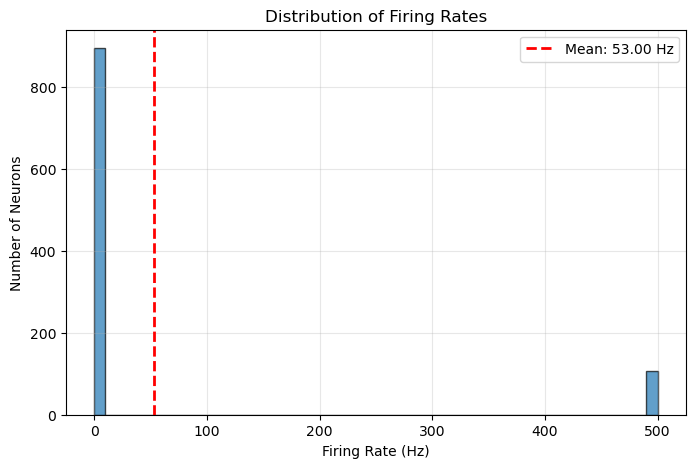


Simulation complete! You can now:
  1. Modify parameters above and re-run
  2. Try different synaptic modes ('immediate' vs 'dynamic')
  3. Explore different input rates
  4. Uncomment parameter comparison section
  5. Add perturbations using network.inject_perturbation(neuron_id)


In [1]:
# Single Trial Simulation and Raster Plot
# Import necessary modules and run a single simulation

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src directory to path for imports
sys.path.append('src')
sys.path.append('analysis')

# Import the required classes
from spiking_network import SpikingRNN
from rng_utils import get_rng

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

# Network parameters
n_neurons = 1000
dt = 0.1  # ms
synaptic_mode = "dynamic"  # or "immediate"

# Heterogeneity parameters
session_id = 1
v_th_std = 0  # Threshold heterogeneity
g_std = 0   # Synaptic weight heterogeneity
trial_id = 1

# Simulation parameters
duration = 1000.0  # 2 seconds in milliseconds
static_input_rate = 1000.0  # Hz

# Additional network parameters
v_th_distribution = "normal"
network_params = {
    'v_th_distribution': v_th_distribution,
    'static_input_strength': 25.0,  # Enhanced connectivity strength
    'dynamic_input_strength': 1.0,
    'readout_weight_scale': 1.0
}

print(f"Simulation Parameters:")
print(f"  Network size: {n_neurons} neurons")
print(f"  Duration: {duration} ms")
print(f"  v_th_std: {v_th_std}")
print(f"  g_std: {g_std}")
print(f"  Static input rate: {static_input_rate} Hz")
print(f"  Synaptic mode: {synaptic_mode}")

# =============================================================================
# CREATE AND INITIALIZE NETWORK
# =============================================================================

# Create network
network = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode=synaptic_mode)

# Initialize network structure (depends on session + parameters)
network.initialize_network(session_id, v_th_std, g_std, **network_params)

print(f"\nNetwork initialized successfully!")

# Get network information
network_info = network.get_network_info()
print(f"  Threshold mean: {network_info['threshold_mean']:.2f} mV")
print(f"  Threshold std: {network_info['threshold_std']:.3f} mV")
print(f"  Weight connections: {network_info['weight_matrix_nnz']}")
print(f"  Weight mean: {network_info['weight_mean']:.3f}")
print(f"  Weight std: {network_info['weight_std']:.3f}")

# =============================================================================
# RUN SIMULATION
# =============================================================================

print(f"\nRunning simulation...")

# Run the simulation
spike_times = network.simulate_network_dynamics(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=duration,
    static_input_rate=static_input_rate
)

print(f"Simulation completed!")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Average firing rate: {len(spike_times) / (duration/1000) / n_neurons:.2f} Hz")

# =============================================================================
# CREATE RASTER PLOT
# =============================================================================

def plot_raster(spike_times, duration, n_neurons, title_suffix=""):
    """Create a raster plot from spike times"""
    
    if not spike_times:
        print("No spikes to plot!")
        return
    
    # Extract spike times and neuron IDs
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Main raster plot
    ax1.scatter(times, neuron_ids, s=0.5, alpha=0.6, c='black')
    ax1.set_ylabel('Neuron ID')
    ax1.set_title(f'Raster Plot - {title_suffix}')
    ax1.set_xlim(0, duration)
    ax1.set_ylim(0, n_neurons)
    ax1.grid(True, alpha=0.3)
    
    # Population firing rate (binned)
    bin_size = 10.0  # ms
    bins = np.arange(0, duration + bin_size, bin_size)
    spike_counts, _ = np.histogram(times, bins=bins)
    firing_rate = spike_counts / (bin_size / 1000.0) / n_neurons  # Hz
    bin_centers = bins[:-1] + bin_size/2
    
    ax2.plot(bin_centers, firing_rate, 'b-', linewidth=1)
    ax2.fill_between(bin_centers, firing_rate, alpha=0.3)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Population Rate (Hz)')
    ax2.set_title('Population Firing Rate')
    ax2.set_xlim(0, duration)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create raster plot
title_suffix = f"v_th_std={v_th_std}, g_std={g_std}, Input={static_input_rate}Hz"
fig = plot_raster(spike_times, duration, n_neurons, title_suffix)

# =============================================================================
# DETAILED ANALYSIS
# =============================================================================

def analyze_spike_statistics(spike_times, duration, n_neurons):
    """Analyze basic spike statistics"""
    
    if not spike_times:
        return
    
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Per-neuron spike counts
    spike_counts = np.zeros(n_neurons)
    for neuron_id in neuron_ids:
        spike_counts[neuron_id] += 1
    
    # Firing rates per neuron
    firing_rates = spike_counts / (duration / 1000.0)  # Hz
    
    # Statistics
    total_spikes = len(spike_times)
    mean_rate = np.mean(firing_rates)
    std_rate = np.std(firing_rates)
    silent_neurons = np.sum(firing_rates == 0)
    active_neurons = n_neurons - silent_neurons
    
    print(f"\nSpike Statistics:")
    print(f"  Total spikes: {total_spikes}")
    print(f"  Mean firing rate: {mean_rate:.2f} ± {std_rate:.2f} Hz")
    print(f"  Silent neurons: {silent_neurons} ({silent_neurons/n_neurons*100:.1f}%)")
    print(f"  Active neurons: {active_neurons} ({active_neurons/n_neurons*100:.1f}%)")
    print(f"  Min firing rate: {np.min(firing_rates):.2f} Hz")
    print(f"  Max firing rate: {np.max(firing_rates):.2f} Hz")
    
    # Plot firing rate distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(firing_rates, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(mean_rate, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_rate:.2f} Hz')
    ax.set_xlabel('Firing Rate (Hz)')
    ax.set_ylabel('Number of Neurons')
    ax.set_title('Distribution of Firing Rates')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'firing_rates': firing_rates,
        'mean_rate': mean_rate,
        'std_rate': std_rate,
        'silent_neurons': silent_neurons,
        'active_neurons': active_neurons
    }

# Analyze the results
stats = analyze_spike_statistics(spike_times, duration, n_neurons)

# =============================================================================
# PARAMETER EXPLORATION FUNCTION
# =============================================================================

def run_parameter_comparison(v_th_stds, g_stds, input_rate=200.0, duration=1000.0):
    """Compare different parameter combinations"""
    
    fig, axes = plt.subplots(len(v_th_stds), len(g_stds), figsize=(15, 12))
    if len(v_th_stds) == 1:
        axes = axes.reshape(1, -1)
    if len(g_stds) == 1:
        axes = axes.reshape(-1, 1)
    
    results = []
    
    for i, v_th in enumerate(v_th_stds):
        for j, g in enumerate(g_stds):
            print(f"Running v_th_std={v_th}, g_std={g}...")
            
            # Create new network
            net = SpikingRNN(n_neurons=500, dt=dt, synaptic_mode=synaptic_mode)  # Smaller for speed
            net.initialize_network(session_id, v_th, g, **network_params)
            
            # Run simulation
            spikes = net.simulate_network_dynamics(
                session_id=session_id, v_th_std=v_th, g_std=g, trial_id=trial_id,
                duration=duration, static_input_rate=input_rate
            )
            
            # Extract data for plotting
            times = [spike[0] for spike in spikes]
            neuron_ids = [spike[1] for spike in spikes]
            
            # Plot mini raster
            ax = axes[i, j]
            if spikes:
                ax.scatter(times, neuron_ids, s=0.3, alpha=0.6, c='black')
            ax.set_title(f'v_th={v_th:.1f}, g={g:.1f}')
            ax.set_xlim(0, duration)
            ax.set_ylim(0, 500)
            
            if i == len(v_th_stds) - 1:
                ax.set_xlabel('Time (ms)')
            if j == 0:
                ax.set_ylabel('Neuron ID')
            
            # Store results
            firing_rate = len(spikes) / (duration/1000) / 500
            results.append({
                'v_th_std': v_th,
                'g_std': g,
                'n_spikes': len(spikes),
                'firing_rate': firing_rate
            })
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example parameter comparison (uncomment to run)
# print("\nParameter Comparison:")
# comparison_results = run_parameter_comparison([0.1, 0.5], [0.1, 0.5], input_rate=200.0, duration=1000.0)
# for result in comparison_results:
#     print(f"v_th_std={result['v_th_std']}, g_std={result['g_std']}: {result['firing_rate']:.2f} Hz")

print(f"\nSimulation complete! You can now:")
print(f"  1. Modify parameters above and re-run")
print(f"  2. Try different synaptic modes ('immediate' vs 'dynamic')")
print(f"  3. Explore different input rates")
print(f"  4. Uncomment parameter comparison section")
print(f"  5. Add perturbations using network.inject_perturbation(neuron_id)")

In [2]:
print(f"Input strength: {network.static_input.input_strength}")

Input strength: 25.0


Simulation Parameters:
  Network size: 1000 neurons
  Duration: 300.0 ms
  v_th_std: 1
  g_std: 1
  Static input rate: 2.0 Hz
  Synaptic mode: dynamic

Network initialized successfully!
  Threshold mean: -55.00 mV
  Threshold std: 1.047 mV
  Weight connections: 99528
  Weight mean: 0.000
  Weight std: 1.000

Running simulation...
Simulation completed!
  Total spikes: 633
  Average firing rate: 2.11 Hz


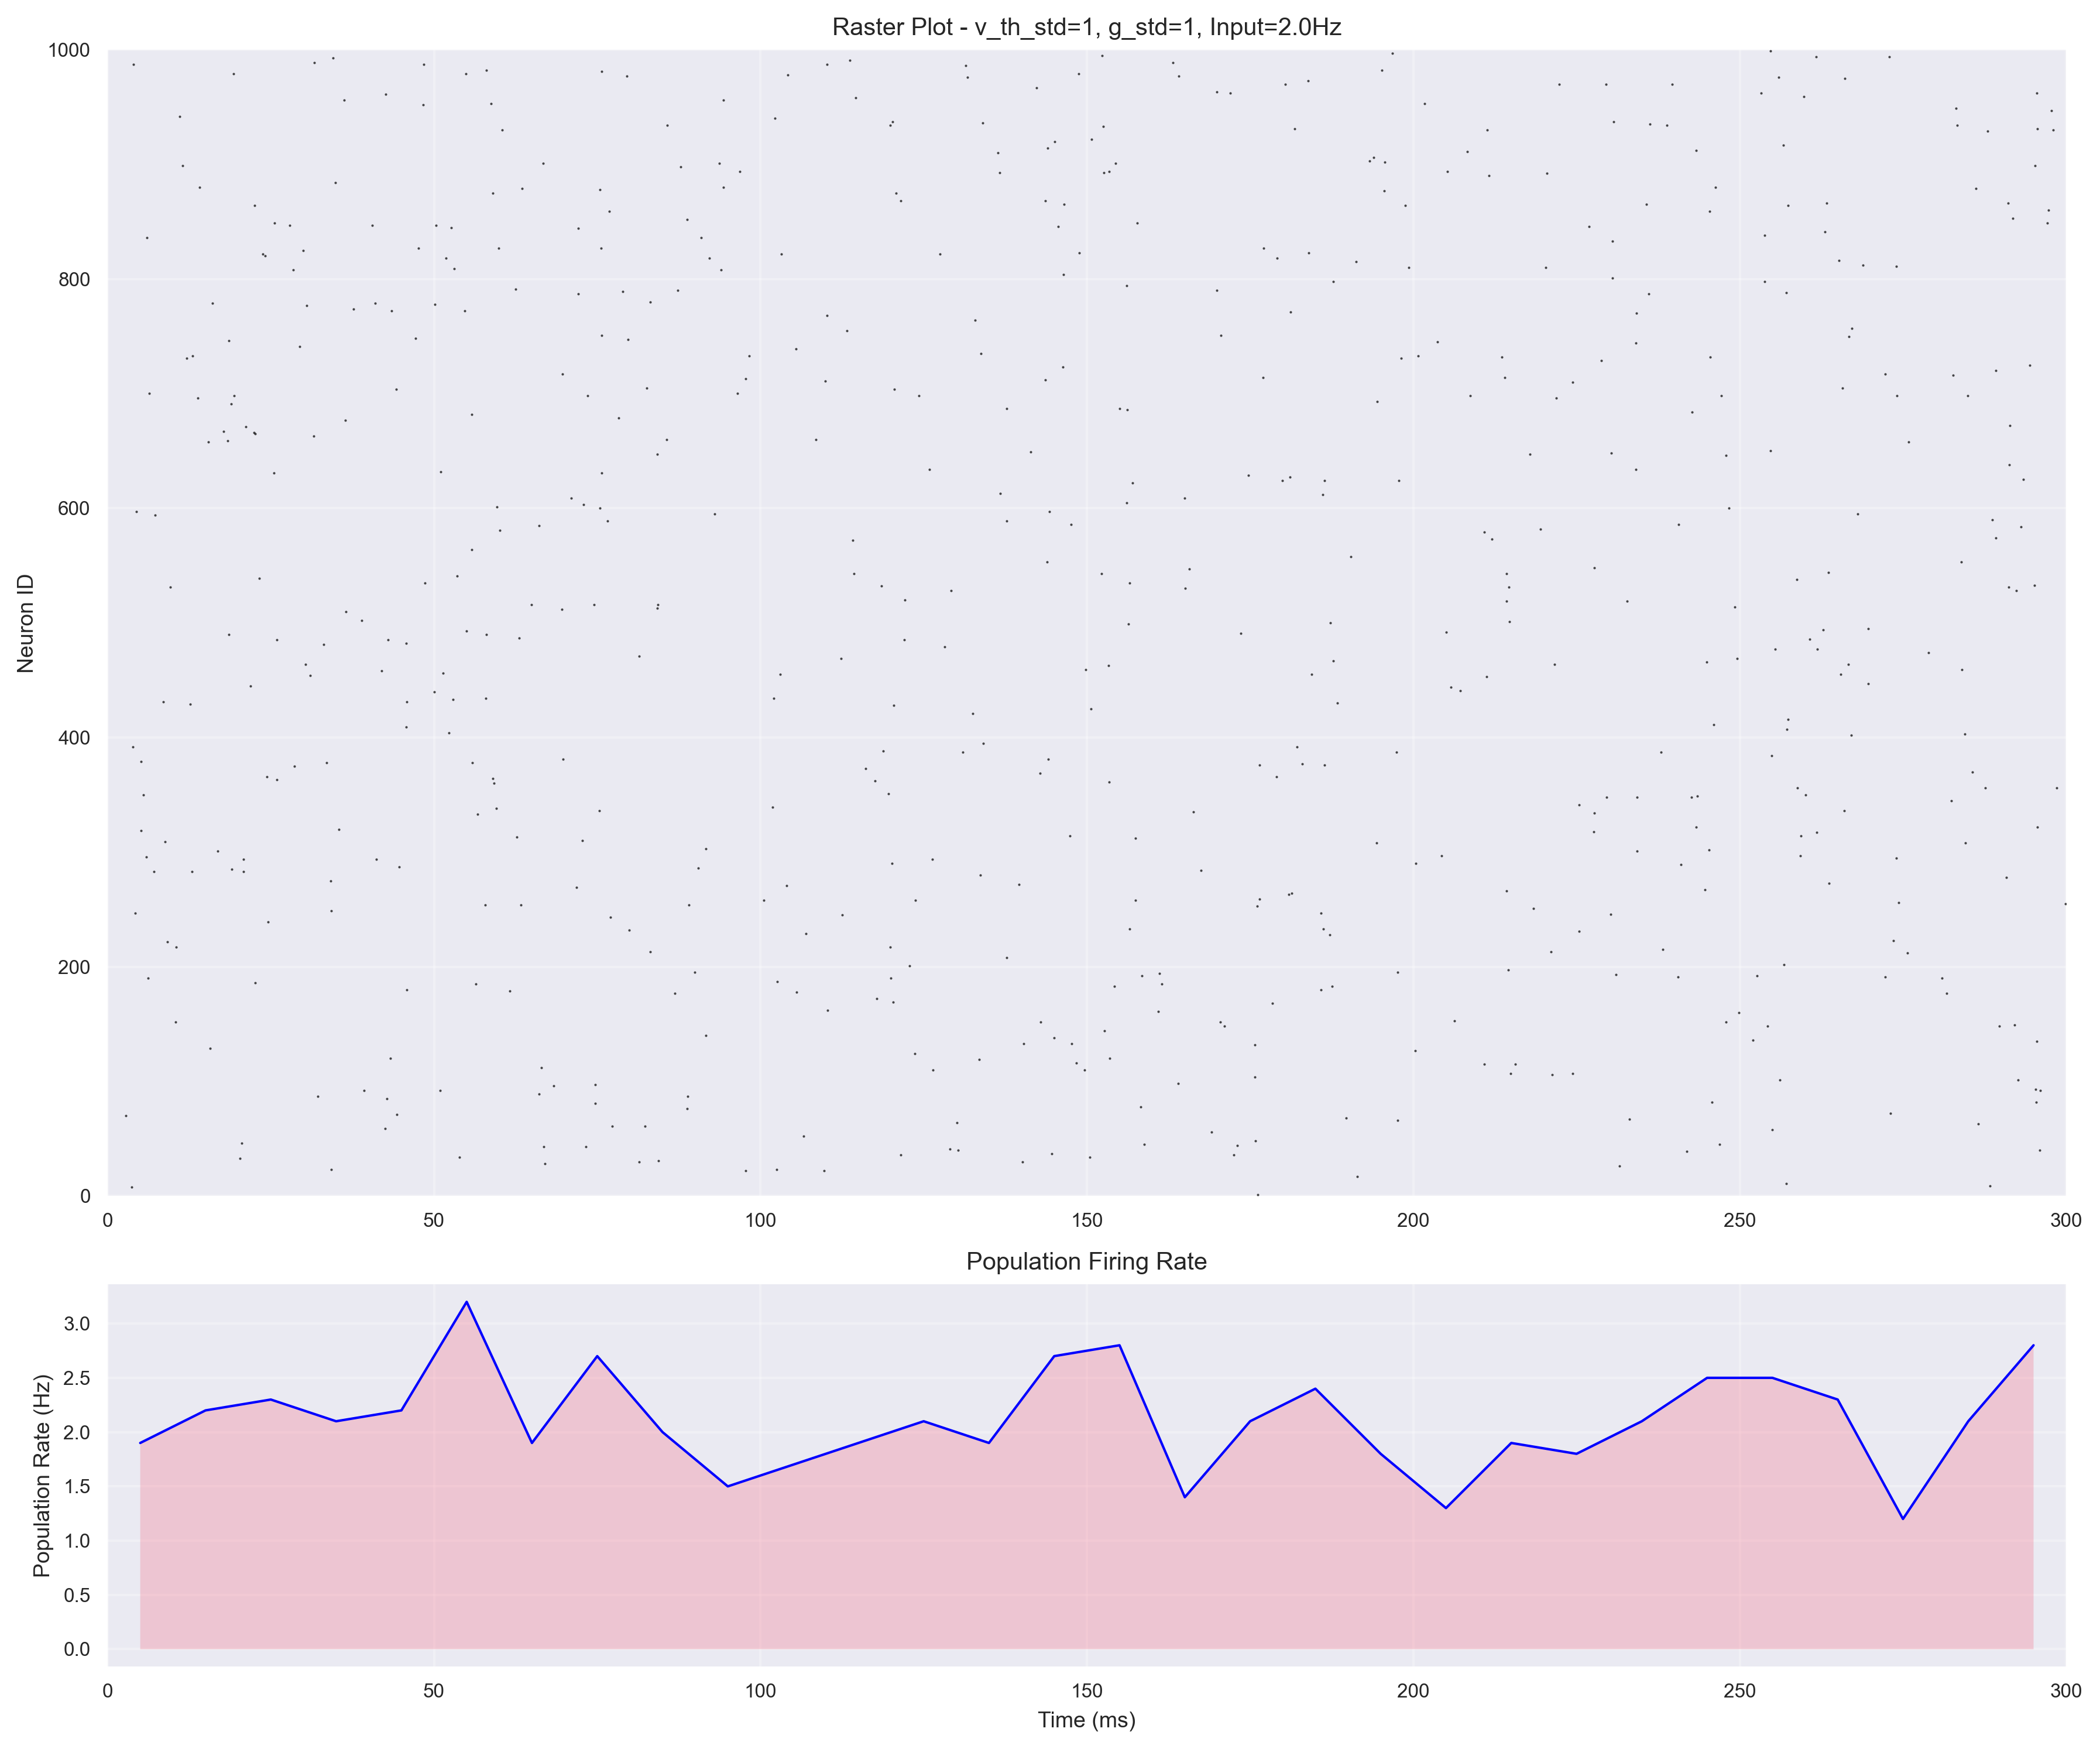


Spike Statistics:
  Total spikes: 633
  Mean firing rate: 2.11 ± 2.79 Hz
  Silent neurons: 544 (54.4%)
  Active neurons: 456 (45.6%)
  Min firing rate: 0.00 Hz
  Max firing rate: 23.33 Hz


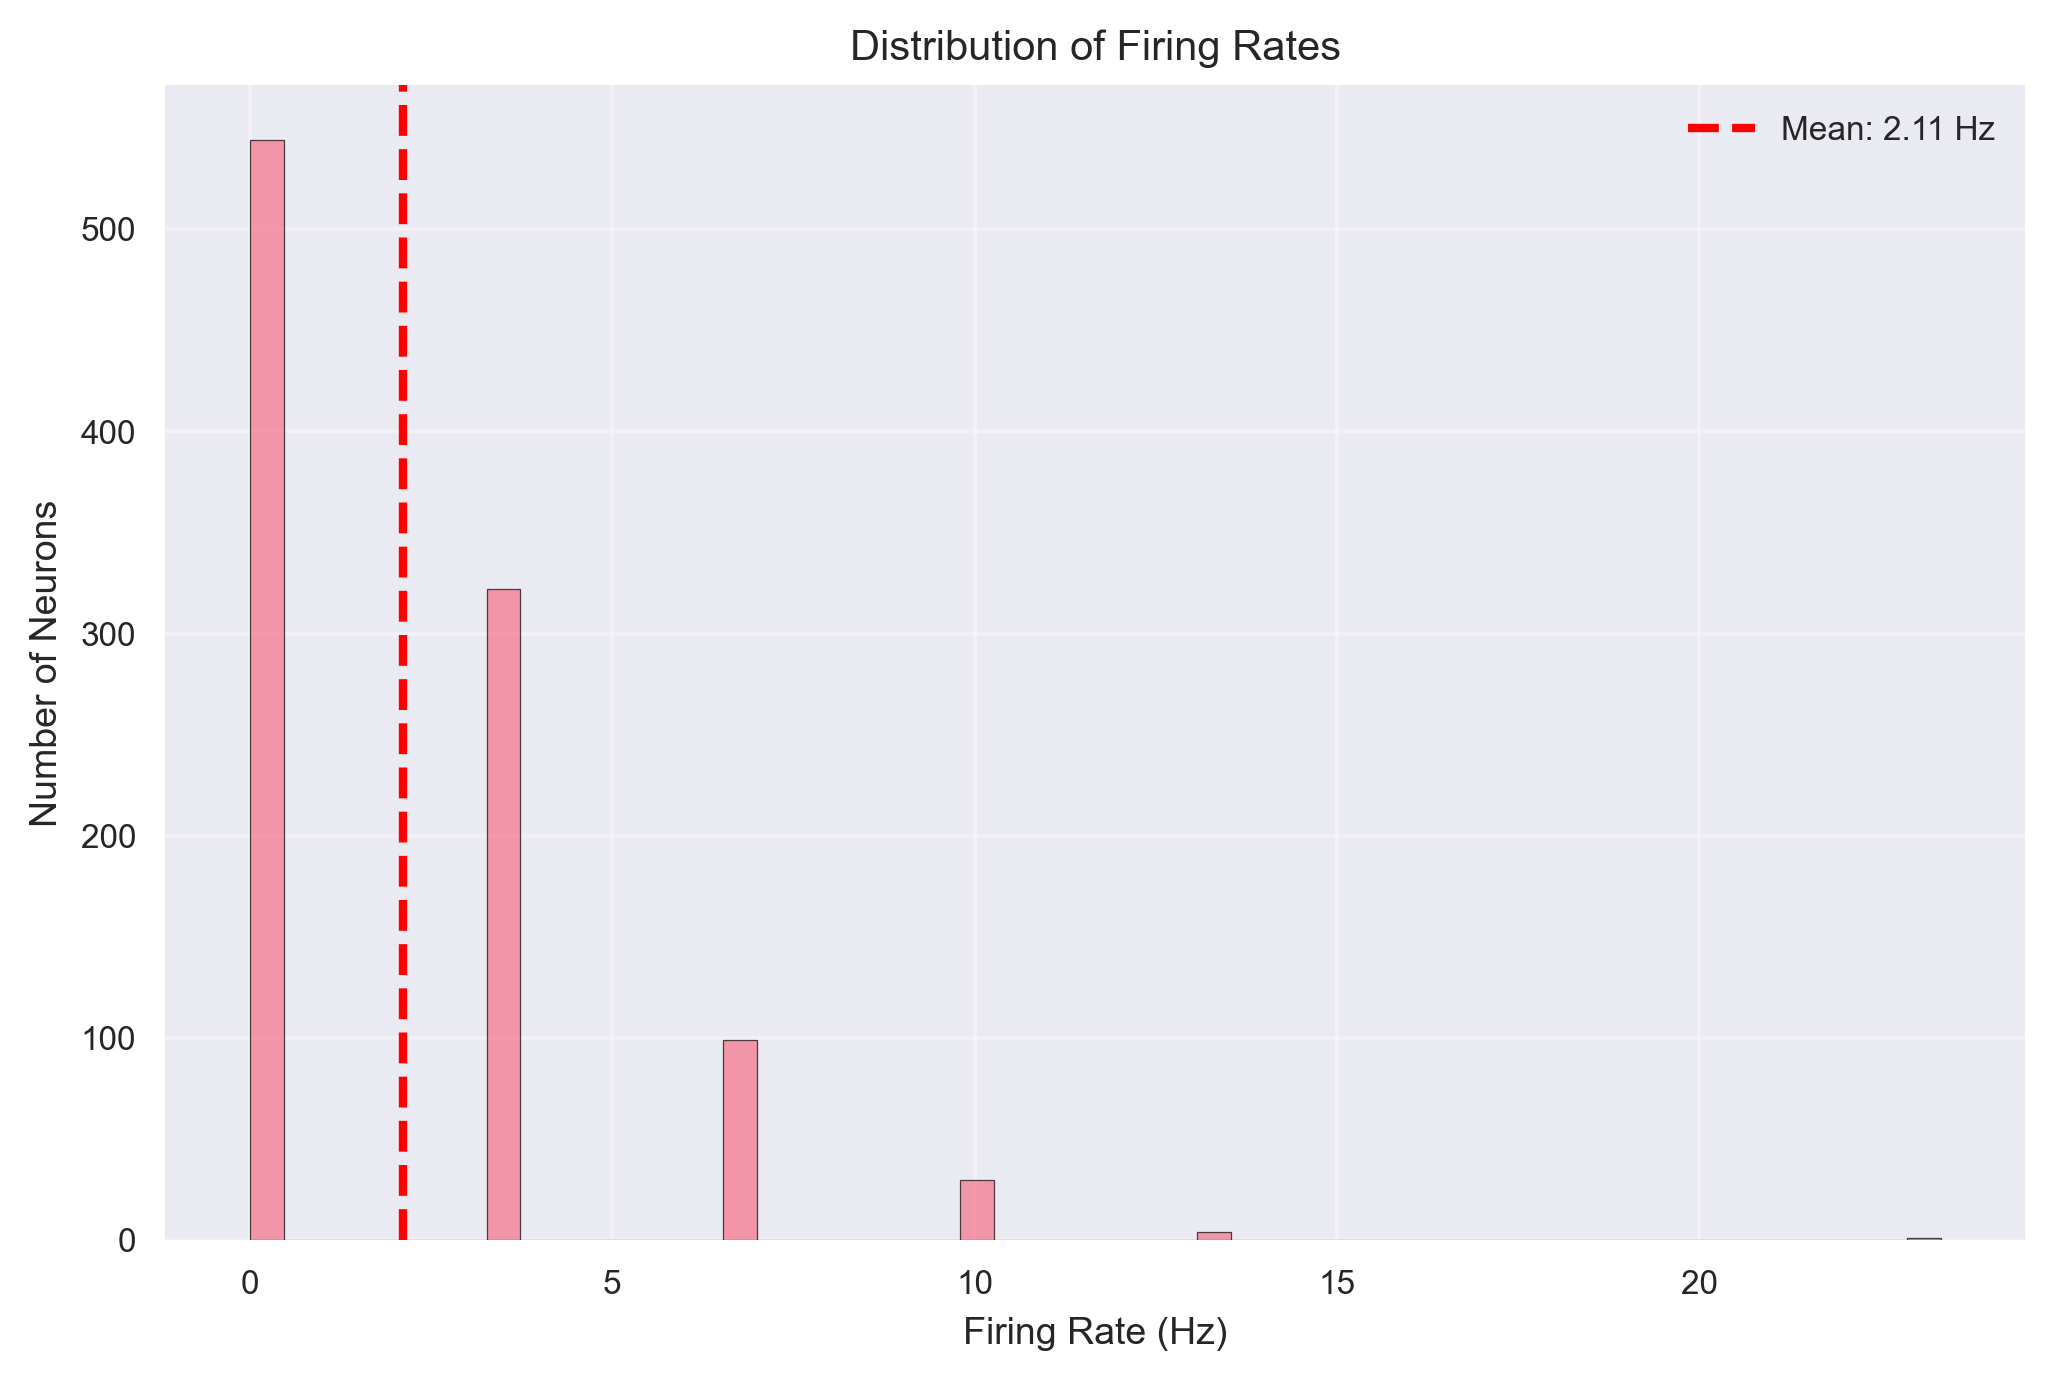


Simulation complete! You can now:
  1. Modify parameters above and re-run
  2. Try different synaptic modes ('immediate' vs 'dynamic')
  3. Explore different input rates
  4. Uncomment parameter comparison section
  5. Add perturbations using network.inject_perturbation(neuron_id)


In [32]:
# Single Trial Simulation and Raster Plot
# Import necessary modules and run a single simulation

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src directory to path for imports
sys.path.append('src')
sys.path.append('analysis')

# Import the required classes
from spiking_network import SpikingRNN
from rng_utils import get_rng

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

# Network parameters
n_neurons = 1000
dt = 0.1  # ms
synaptic_mode = "dynamic"  # or "immediate"

# Heterogeneity parameters
session_id = 1
v_th_std = 1  # Threshold heterogeneity
g_std = 1     # Synaptic weight heterogeneity
trial_id = 1

# Simulation parameters
duration = 300.0  # 2 seconds in milliseconds
static_input_rate = 2.0  # Hz

# Additional network parameters
v_th_distribution = "normal"
network_params = {
    'v_th_distribution': v_th_distribution,
    'static_input_strength': 10.0,  # Try increasing this value
    'dynamic_input_strength': 1.0,
    'readout_weight_scale': 1.0
}

print(f"Simulation Parameters:")
print(f"  Network size: {n_neurons} neurons")
print(f"  Duration: {duration} ms")
print(f"  v_th_std: {v_th_std}")
print(f"  g_std: {g_std}")
print(f"  Static input rate: {static_input_rate} Hz")
print(f"  Synaptic mode: {synaptic_mode}")

# =============================================================================
# CREATE AND INITIALIZE NETWORK
# =============================================================================

# Create network
network = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode=synaptic_mode)

# Initialize network structure (depends on session + parameters)
network.initialize_network(session_id, v_th_std, g_std, **network_params)

print(f"\nNetwork initialized successfully!")

# Get network information
network_info = network.get_network_info()
print(f"  Threshold mean: {network_info['threshold_mean']:.2f} mV")
print(f"  Threshold std: {network_info['threshold_std']:.3f} mV")
print(f"  Weight connections: {network_info['weight_matrix_nnz']}")
print(f"  Weight mean: {network_info['weight_mean']:.3f}")
print(f"  Weight std: {network_info['weight_std']:.3f}")

# =============================================================================
# RUN SIMULATION
# =============================================================================

print(f"\nRunning simulation...")

# MANUAL OVERRIDE: Set identical initial conditions for testing
# print("Overriding initial conditions to be identical...")
# network.neurons.v_membrane = np.full(n_neurons, -70.0)  # All start at resting potential
# network.neurons.refractory_timer = np.zeros(n_neurons)  # No refractory
# network.neurons.last_spike_time = -np.inf * np.ones(n_neurons)  # No previous spikes

# print(f"All neurons initialized to: {network.neurons.v_membrane[0]:.1f} mV")

# Run the simulation
spike_times = network.simulate_network_dynamics(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=duration,
    static_input_rate=static_input_rate
)

print(f"Simulation completed!")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Average firing rate: {len(spike_times) / (duration/1000) / n_neurons:.2f} Hz")

# =============================================================================
# CREATE RASTER PLOT
# =============================================================================

def plot_raster(spike_times, duration, n_neurons, title_suffix=""):
    """Create a raster plot from spike times"""
    
    if not spike_times:
        print("No spikes to plot!")
        return
    
    # Extract spike times and neuron IDs
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Main raster plot
    ax1.scatter(times, neuron_ids, s=0.5, alpha=0.6, c='black')
    ax1.set_ylabel('Neuron ID')
    ax1.set_title(f'Raster Plot - {title_suffix}')
    ax1.set_xlim(0, duration)
    ax1.set_ylim(0, n_neurons)
    ax1.grid(True, alpha=0.3)
    
    # Population firing rate (binned)
    bin_size = 10.0  # ms
    bins = np.arange(0, duration + bin_size, bin_size)
    spike_counts, _ = np.histogram(times, bins=bins)
    firing_rate = spike_counts / (bin_size / 1000.0) / n_neurons  # Hz
    bin_centers = bins[:-1] + bin_size/2
    
    ax2.plot(bin_centers, firing_rate, 'b-', linewidth=1)
    ax2.fill_between(bin_centers, firing_rate, alpha=0.3)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Population Rate (Hz)')
    ax2.set_title('Population Firing Rate')
    ax2.set_xlim(0, duration)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create raster plot
title_suffix = f"v_th_std={v_th_std}, g_std={g_std}, Input={static_input_rate}Hz"
fig = plot_raster(spike_times, duration, n_neurons, title_suffix)

# =============================================================================
# DETAILED ANALYSIS
# =============================================================================

def analyze_spike_statistics(spike_times, duration, n_neurons):
    """Analyze basic spike statistics"""
    
    if not spike_times:
        return
    
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Per-neuron spike counts
    spike_counts = np.zeros(n_neurons)
    for neuron_id in neuron_ids:
        spike_counts[neuron_id] += 1
    
    # Firing rates per neuron
    firing_rates = spike_counts / (duration / 1000.0)  # Hz
    
    # Statistics
    total_spikes = len(spike_times)
    mean_rate = np.mean(firing_rates)
    std_rate = np.std(firing_rates)
    silent_neurons = np.sum(firing_rates == 0)
    active_neurons = n_neurons - silent_neurons
    
    print(f"\nSpike Statistics:")
    print(f"  Total spikes: {total_spikes}")
    print(f"  Mean firing rate: {mean_rate:.2f} ± {std_rate:.2f} Hz")
    print(f"  Silent neurons: {silent_neurons} ({silent_neurons/n_neurons*100:.1f}%)")
    print(f"  Active neurons: {active_neurons} ({active_neurons/n_neurons*100:.1f}%)")
    print(f"  Min firing rate: {np.min(firing_rates):.2f} Hz")
    print(f"  Max firing rate: {np.max(firing_rates):.2f} Hz")
    
    # Plot firing rate distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(firing_rates, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(mean_rate, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_rate:.2f} Hz')
    ax.set_xlabel('Firing Rate (Hz)')
    ax.set_ylabel('Number of Neurons')
    ax.set_title('Distribution of Firing Rates')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'firing_rates': firing_rates,
        'mean_rate': mean_rate,
        'std_rate': std_rate,
        'silent_neurons': silent_neurons,
        'active_neurons': active_neurons
    }

# Analyze the results
stats = analyze_spike_statistics(spike_times, duration, n_neurons)

# =============================================================================
# PARAMETER EXPLORATION FUNCTION
# =============================================================================

def run_parameter_comparison(v_th_stds, g_stds, input_rate=200.0, duration=1000.0):
    """Compare different parameter combinations"""
    
    fig, axes = plt.subplots(len(v_th_stds), len(g_stds), figsize=(15, 12))
    if len(v_th_stds) == 1:
        axes = axes.reshape(1, -1)
    if len(g_stds) == 1:
        axes = axes.reshape(-1, 1)
    
    results = []
    
    for i, v_th in enumerate(v_th_stds):
        for j, g in enumerate(g_stds):
            print(f"Running v_th_std={v_th}, g_std={g}...")
            
            # Create new network
            net = SpikingRNN(n_neurons=500, dt=dt, synaptic_mode=synaptic_mode)  # Smaller for speed
            net.initialize_network(session_id, v_th, g, **network_params)
            
            # Run simulation
            spikes = net.simulate_network_dynamics(
                session_id=session_id, v_th_std=v_th, g_std=g, trial_id=trial_id,
                duration=duration, static_input_rate=input_rate
            )
            
            # Extract data for plotting
            times = [spike[0] for spike in spikes]
            neuron_ids = [spike[1] for spike in spikes]
            
            # Plot mini raster
            ax = axes[i, j]
            if spikes:
                ax.scatter(times, neuron_ids, s=0.3, alpha=0.6, c='black')
            ax.set_title(f'v_th={v_th:.1f}, g={g:.1f}')
            ax.set_xlim(0, duration)
            ax.set_ylim(0, 500)
            
            if i == len(v_th_stds) - 1:
                ax.set_xlabel('Time (ms)')
            if j == 0:
                ax.set_ylabel('Neuron ID')
            
            # Store results
            firing_rate = len(spikes) / (duration/1000) / 500
            results.append({
                'v_th_std': v_th,
                'g_std': g,
                'n_spikes': len(spikes),
                'firing_rate': firing_rate
            })
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example parameter comparison (uncomment to run)
# print("\nParameter Comparison:")
# comparison_results = run_parameter_comparison([0.1, 0.5], [0.1, 0.5], input_rate=200.0, duration=1000.0)
# for result in comparison_results:
#     print(f"v_th_std={result['v_th_std']}, g_std={result['g_std']}: {result['firing_rate']:.2f} Hz")

print(f"\nSimulation complete! You can now:")
print(f"  1. Modify parameters above and re-run")
print(f"  2. Try different synaptic modes ('immediate' vs 'dynamic')")
print(f"  3. Explore different input rates")
print(f"  4. Uncomment parameter comparison section")
print(f"  5. Add perturbations using network.inject_perturbation(neuron_id)")

Simulation Parameters:
  Network size: 1000 neurons
  Duration: 200.0 ms
  v_th_std: 1
  g_std: 1
  Static input rate: 10.0 Hz
  Synaptic mode: dynamic

Network initialized successfully!
  Threshold mean: -55.00 mV
  Threshold std: 0.976 mV
  Weight connections: 100053
  Weight mean: 0.000
  Weight std: 1.000

Running simulation...
Simulation completed!
  Total spikes: 2056
  Average firing rate: 10.28 Hz


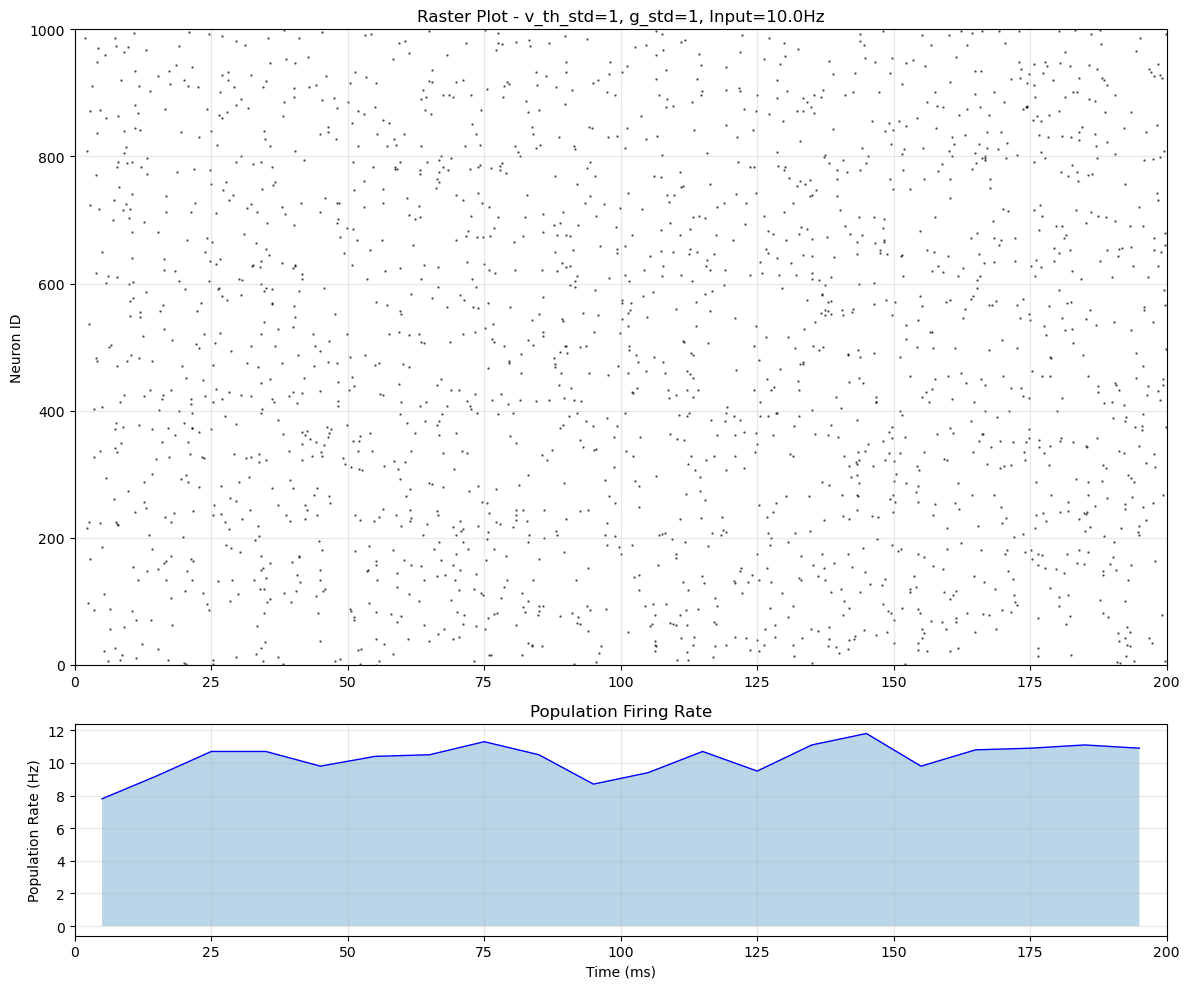


Spike Statistics:
  Total spikes: 2056
  Mean firing rate: 10.28 ± 8.09 Hz
  Silent neurons: 156 (15.6%)
  Active neurons: 844 (84.4%)
  Min firing rate: 0.00 Hz
  Max firing rate: 45.00 Hz


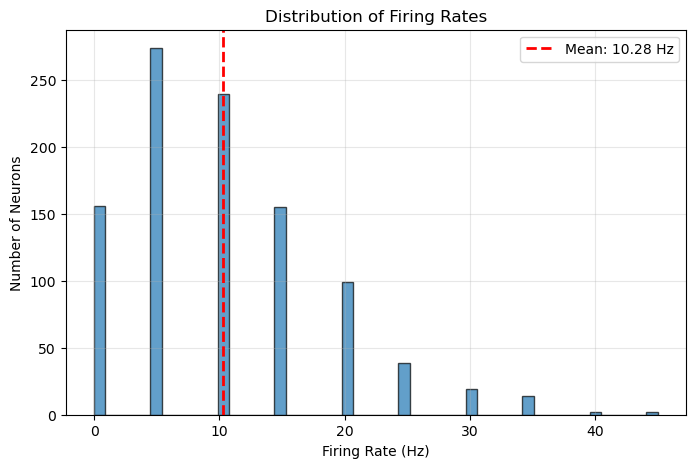


Simulation complete! You can now:
  1. Modify parameters above and re-run
  2. Try different synaptic modes ('immediate' vs 'dynamic')
  3. Explore different input rates
  4. Uncomment parameter comparison section
  5. Add perturbations using network.inject_perturbation(neuron_id)


In [3]:
# Single Trial Simulation and Raster Plot
# Import necessary modules and run a single simulation

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src directory to path for imports
sys.path.append('src')
sys.path.append('analysis')

# Import the required classes
from spiking_network import SpikingRNN
from rng_utils import get_rng

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

# Network parameters
n_neurons = 1000
dt = 0.1  # ms
synaptic_mode = "dynamic"  # or "immediate"

# Heterogeneity parameters
session_id = 1
v_th_std = 1  # Threshold heterogeneity
g_std = 1     # Synaptic weight heterogeneity
trial_id = 1

# Simulation parameters
duration = 200.0  # 2 seconds in milliseconds
static_input_rate = 10.0  # Hz

# Additional network parameters
v_th_distribution = "normal"
network_params = {
    'v_th_distribution': v_th_distribution,
    'static_input_strength': 10.0,  # Try increasing this value
    'dynamic_input_strength': 1.0,
    'readout_weight_scale': 1.0
}

print(f"Simulation Parameters:")
print(f"  Network size: {n_neurons} neurons")
print(f"  Duration: {duration} ms")
print(f"  v_th_std: {v_th_std}")
print(f"  g_std: {g_std}")
print(f"  Static input rate: {static_input_rate} Hz")
print(f"  Synaptic mode: {synaptic_mode}")

# =============================================================================
# CREATE AND INITIALIZE NETWORK
# =============================================================================

# Create network
network = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode=synaptic_mode)

# Initialize network structure (depends on session + parameters)
network.initialize_network(session_id, v_th_std, g_std, **network_params)

print(f"\nNetwork initialized successfully!")

# Get network information
network_info = network.get_network_info()
print(f"  Threshold mean: {network_info['threshold_mean']:.2f} mV")
print(f"  Threshold std: {network_info['threshold_std']:.3f} mV")
print(f"  Weight connections: {network_info['weight_matrix_nnz']}")
print(f"  Weight mean: {network_info['weight_mean']:.3f}")
print(f"  Weight std: {network_info['weight_std']:.3f}")

# =============================================================================
# RUN SIMULATION
# =============================================================================

print(f"\nRunning simulation...")

# MANUAL OVERRIDE: Set identical initial conditions for testing
# print("Overriding initial conditions to be identical...")
# network.neurons.v_membrane = np.full(n_neurons, -70.0)  # All start at resting potential
# network.neurons.refractory_timer = np.zeros(n_neurons)  # No refractory
# network.neurons.last_spike_time = -np.inf * np.ones(n_neurons)  # No previous spikes

# print(f"All neurons initialized to: {network.neurons.v_membrane[0]:.1f} mV")

# Run the simulation
spike_times = network.simulate_network_dynamics(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=duration,
    static_input_rate=static_input_rate
)

print(f"Simulation completed!")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Average firing rate: {len(spike_times) / (duration/1000) / n_neurons:.2f} Hz")

# =============================================================================
# CREATE RASTER PLOT
# =============================================================================

def plot_raster(spike_times, duration, n_neurons, title_suffix=""):
    """Create a raster plot from spike times"""
    
    if not spike_times:
        print("No spikes to plot!")
        return
    
    # Extract spike times and neuron IDs
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Main raster plot
    ax1.scatter(times, neuron_ids, s=0.5, alpha=0.6, c='black')
    ax1.set_ylabel('Neuron ID')
    ax1.set_title(f'Raster Plot - {title_suffix}')
    ax1.set_xlim(0, duration)
    ax1.set_ylim(0, n_neurons)
    ax1.grid(True, alpha=0.3)
    
    # Population firing rate (binned)
    bin_size = 10.0  # ms
    bins = np.arange(0, duration + bin_size, bin_size)
    spike_counts, _ = np.histogram(times, bins=bins)
    firing_rate = spike_counts / (bin_size / 1000.0) / n_neurons  # Hz
    bin_centers = bins[:-1] + bin_size/2
    
    ax2.plot(bin_centers, firing_rate, 'b-', linewidth=1)
    ax2.fill_between(bin_centers, firing_rate, alpha=0.3)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Population Rate (Hz)')
    ax2.set_title('Population Firing Rate')
    ax2.set_xlim(0, duration)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create raster plot
title_suffix = f"v_th_std={v_th_std}, g_std={g_std}, Input={static_input_rate}Hz"
fig = plot_raster(spike_times, duration, n_neurons, title_suffix)

# =============================================================================
# DETAILED ANALYSIS
# =============================================================================

def analyze_spike_statistics(spike_times, duration, n_neurons):
    """Analyze basic spike statistics"""
    
    if not spike_times:
        return
    
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Per-neuron spike counts
    spike_counts = np.zeros(n_neurons)
    for neuron_id in neuron_ids:
        spike_counts[neuron_id] += 1
    
    # Firing rates per neuron
    firing_rates = spike_counts / (duration / 1000.0)  # Hz
    
    # Statistics
    total_spikes = len(spike_times)
    mean_rate = np.mean(firing_rates)
    std_rate = np.std(firing_rates)
    silent_neurons = np.sum(firing_rates == 0)
    active_neurons = n_neurons - silent_neurons
    
    print(f"\nSpike Statistics:")
    print(f"  Total spikes: {total_spikes}")
    print(f"  Mean firing rate: {mean_rate:.2f} ± {std_rate:.2f} Hz")
    print(f"  Silent neurons: {silent_neurons} ({silent_neurons/n_neurons*100:.1f}%)")
    print(f"  Active neurons: {active_neurons} ({active_neurons/n_neurons*100:.1f}%)")
    print(f"  Min firing rate: {np.min(firing_rates):.2f} Hz")
    print(f"  Max firing rate: {np.max(firing_rates):.2f} Hz")
    
    # Plot firing rate distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(firing_rates, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(mean_rate, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_rate:.2f} Hz')
    ax.set_xlabel('Firing Rate (Hz)')
    ax.set_ylabel('Number of Neurons')
    ax.set_title('Distribution of Firing Rates')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'firing_rates': firing_rates,
        'mean_rate': mean_rate,
        'std_rate': std_rate,
        'silent_neurons': silent_neurons,
        'active_neurons': active_neurons
    }

# Analyze the results
stats = analyze_spike_statistics(spike_times, duration, n_neurons)

# =============================================================================
# PARAMETER EXPLORATION FUNCTION
# =============================================================================

def run_parameter_comparison(v_th_stds, g_stds, input_rate=200.0, duration=1000.0):
    """Compare different parameter combinations"""
    
    fig, axes = plt.subplots(len(v_th_stds), len(g_stds), figsize=(15, 12))
    if len(v_th_stds) == 1:
        axes = axes.reshape(1, -1)
    if len(g_stds) == 1:
        axes = axes.reshape(-1, 1)
    
    results = []
    
    for i, v_th in enumerate(v_th_stds):
        for j, g in enumerate(g_stds):
            print(f"Running v_th_std={v_th}, g_std={g}...")
            
            # Create new network
            net = SpikingRNN(n_neurons=500, dt=dt, synaptic_mode=synaptic_mode)  # Smaller for speed
            net.initialize_network(session_id, v_th, g, **network_params)
            
            # Run simulation
            spikes = net.simulate_network_dynamics(
                session_id=session_id, v_th_std=v_th, g_std=g, trial_id=trial_id,
                duration=duration, static_input_rate=input_rate
            )
            
            # Extract data for plotting
            times = [spike[0] for spike in spikes]
            neuron_ids = [spike[1] for spike in spikes]
            
            # Plot mini raster
            ax = axes[i, j]
            if spikes:
                ax.scatter(times, neuron_ids, s=0.3, alpha=0.6, c='black')
            ax.set_title(f'v_th={v_th:.1f}, g={g:.1f}')
            ax.set_xlim(0, duration)
            ax.set_ylim(0, 500)
            
            if i == len(v_th_stds) - 1:
                ax.set_xlabel('Time (ms)')
            if j == 0:
                ax.set_ylabel('Neuron ID')
            
            # Store results
            firing_rate = len(spikes) / (duration/1000) / 500
            results.append({
                'v_th_std': v_th,
                'g_std': g,
                'n_spikes': len(spikes),
                'firing_rate': firing_rate
            })
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example parameter comparison (uncomment to run)
# print("\nParameter Comparison:")
# comparison_results = run_parameter_comparison([0.1, 0.5], [0.1, 0.5], input_rate=200.0, duration=1000.0)
# for result in comparison_results:
#     print(f"v_th_std={result['v_th_std']}, g_std={result['g_std']}: {result['firing_rate']:.2f} Hz")

print(f"\nSimulation complete! You can now:")
print(f"  1. Modify parameters above and re-run")
print(f"  2. Try different synaptic modes ('immediate' vs 'dynamic')")
print(f"  3. Explore different input rates")
print(f"  4. Uncomment parameter comparison section")
print(f"  5. Add perturbations using network.inject_perturbation(neuron_id)")

Loaded spontaneous activity: 1000 combinations
Loaded stability analysis: 300 combinations
ENHANCED SPLIT EXPERIMENTS ANALYSIS
With Poisson Process Validation

SPONTANEOUS ACTIVITY ANALYSIS
Creating 3D firing rate plot...


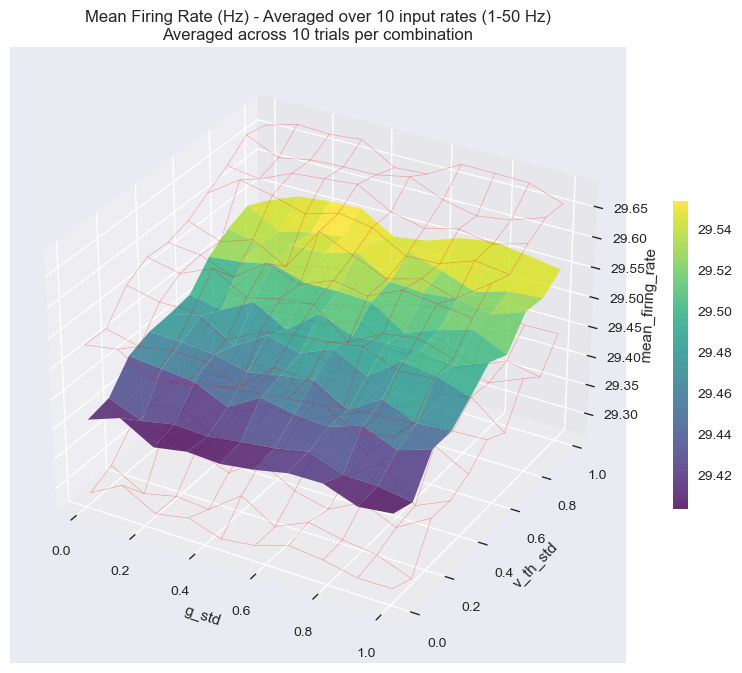

Creating active neurons heatmap...


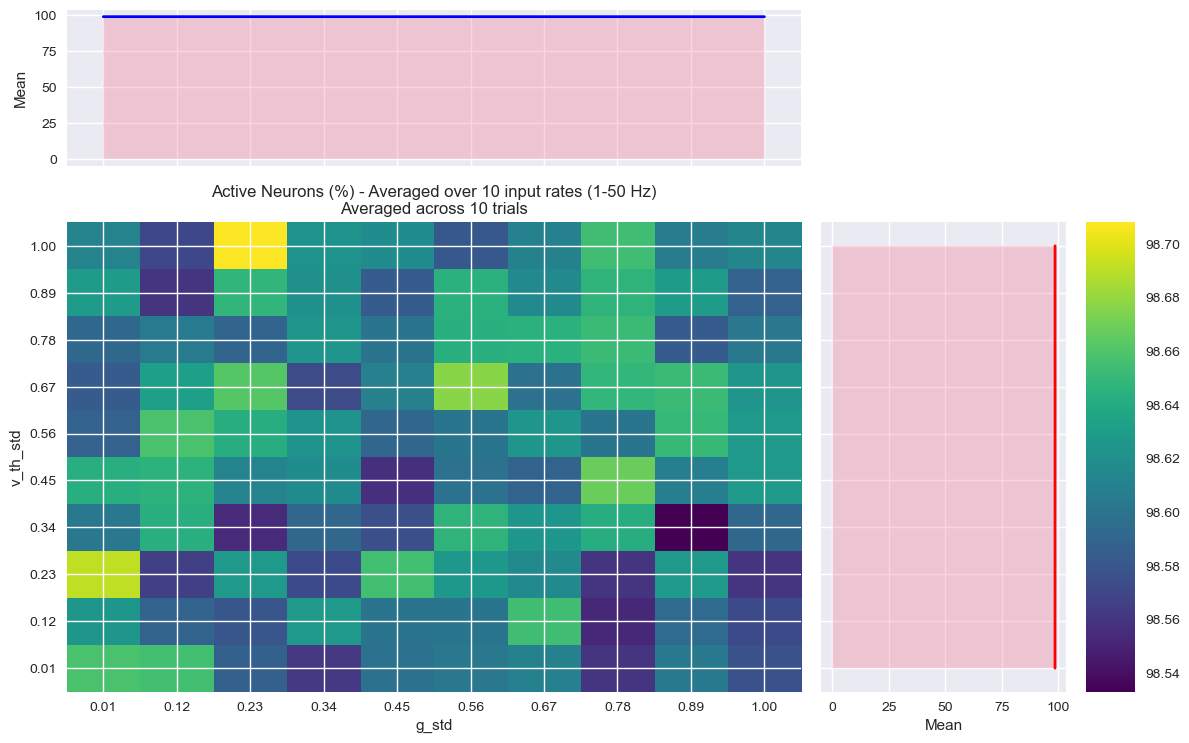

Creating 3D dimensionality plot...


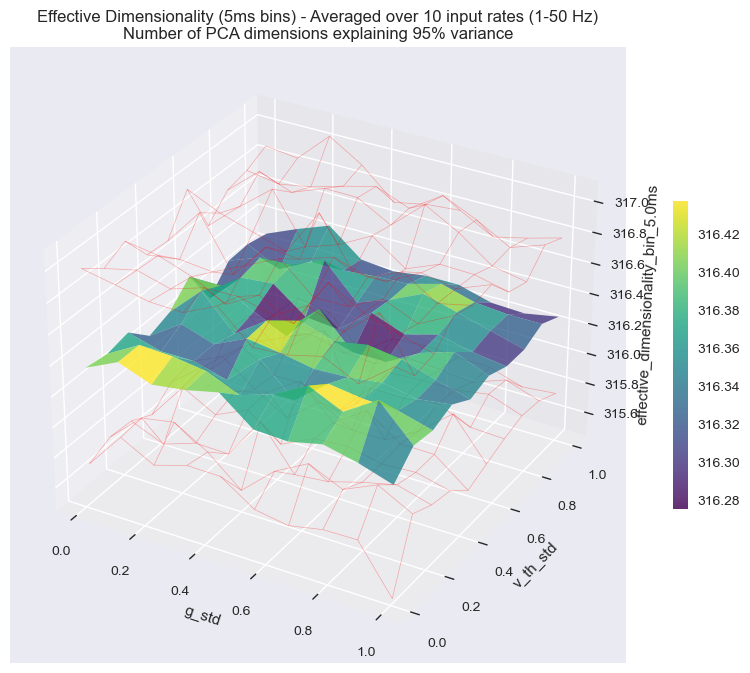

Creating 3D participation ratio plot...


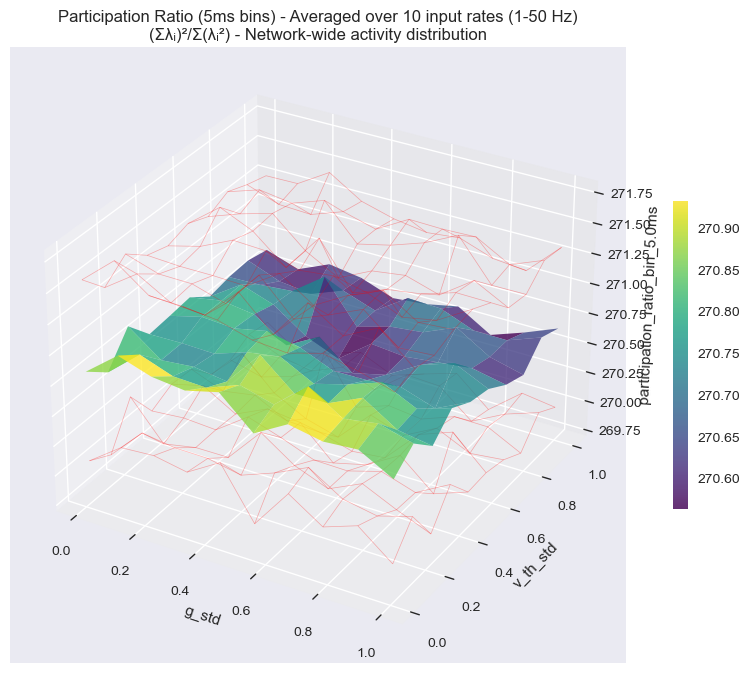

Creating dimensionality vs temporal resolution plot...


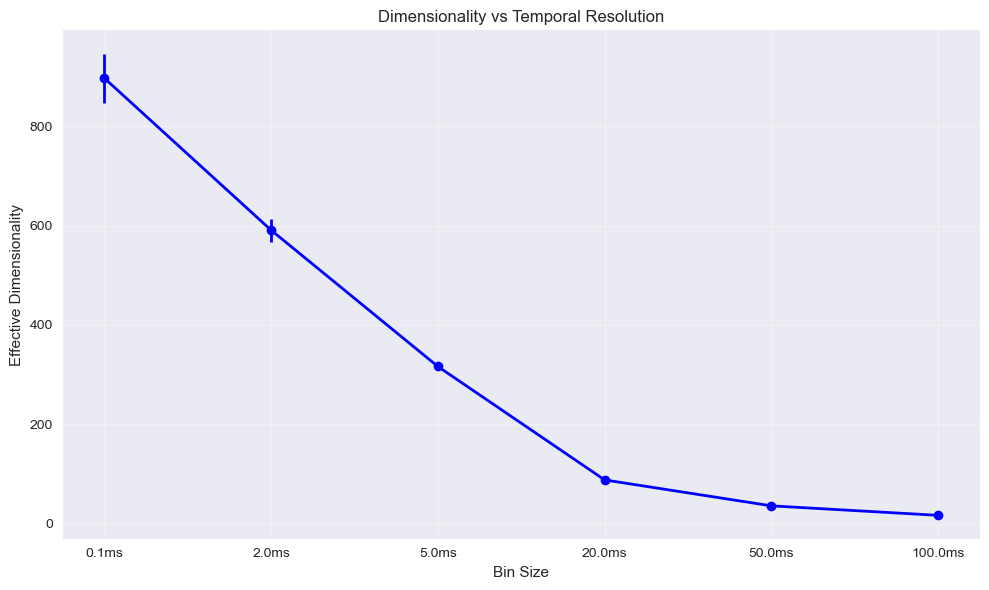

Creating participation ratio vs temporal resolution plot...


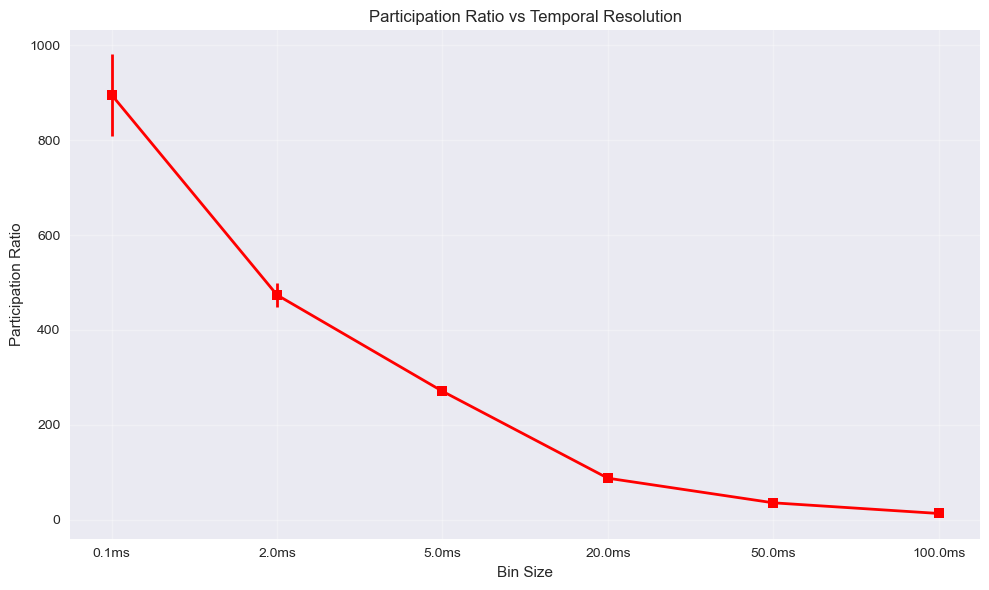

Creating CV ISI heatmap...


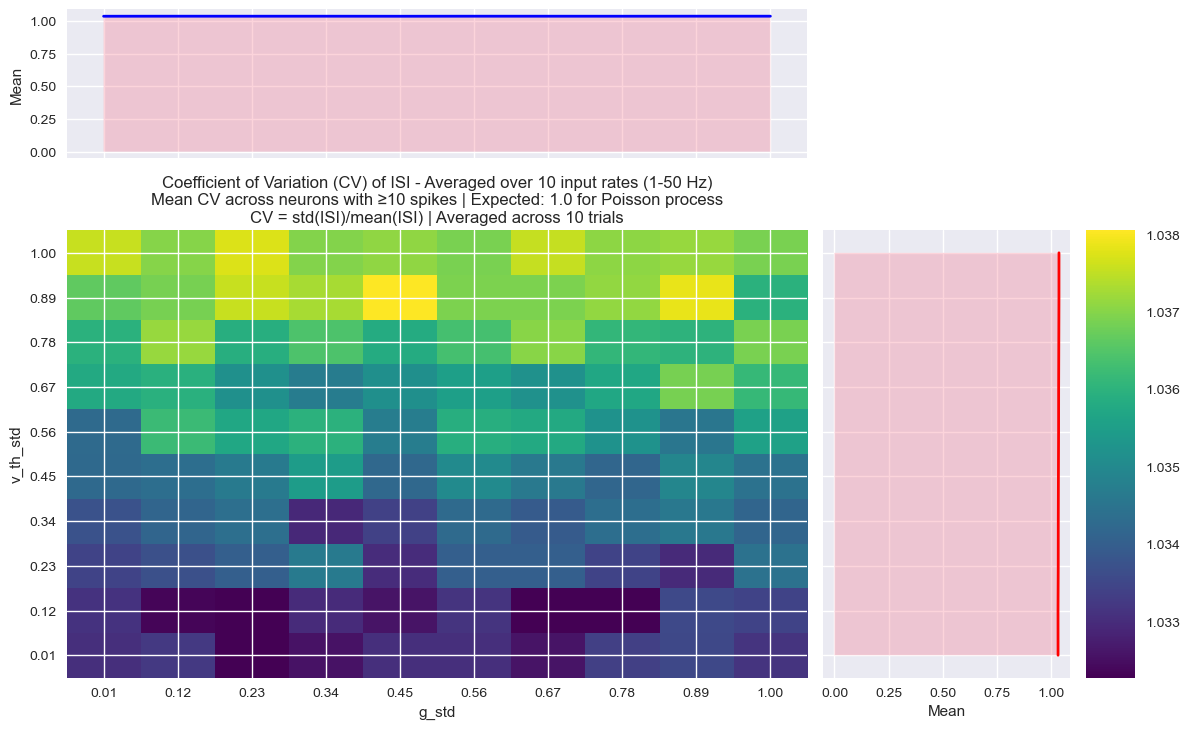

Creating Fano Factor heatmap...


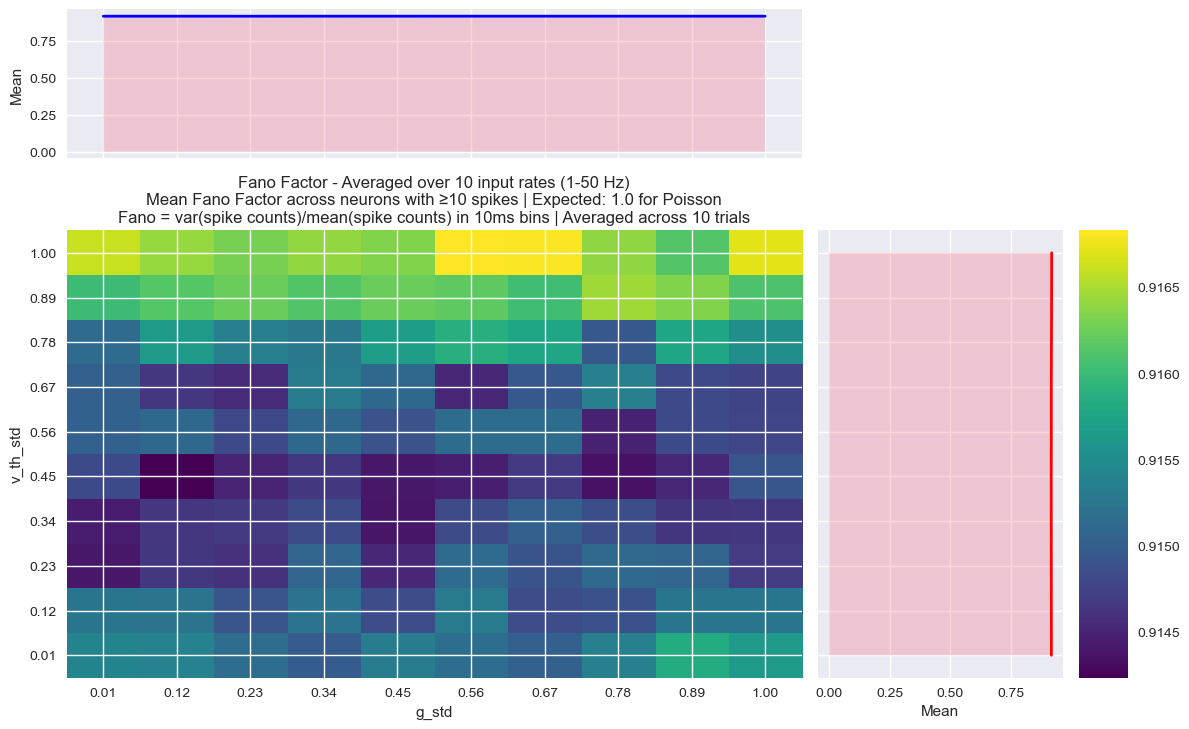

Creating Poisson-like fraction heatmap...


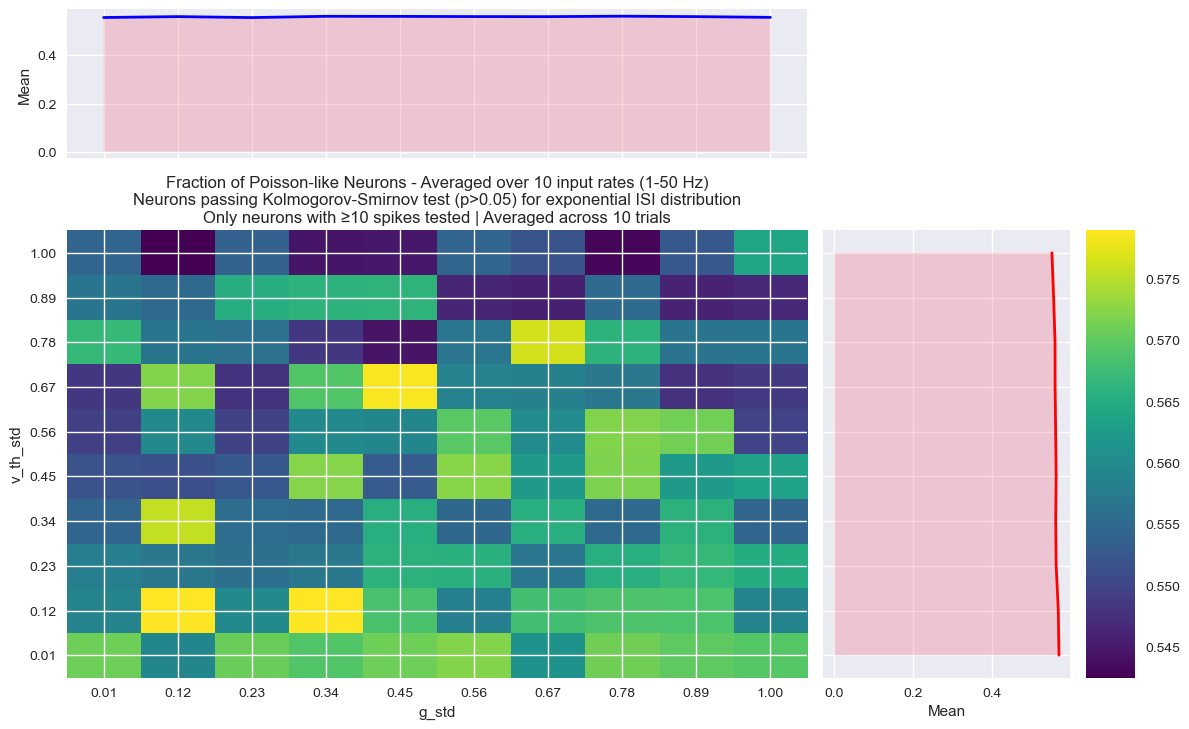

Creating measures vs input rate plot...


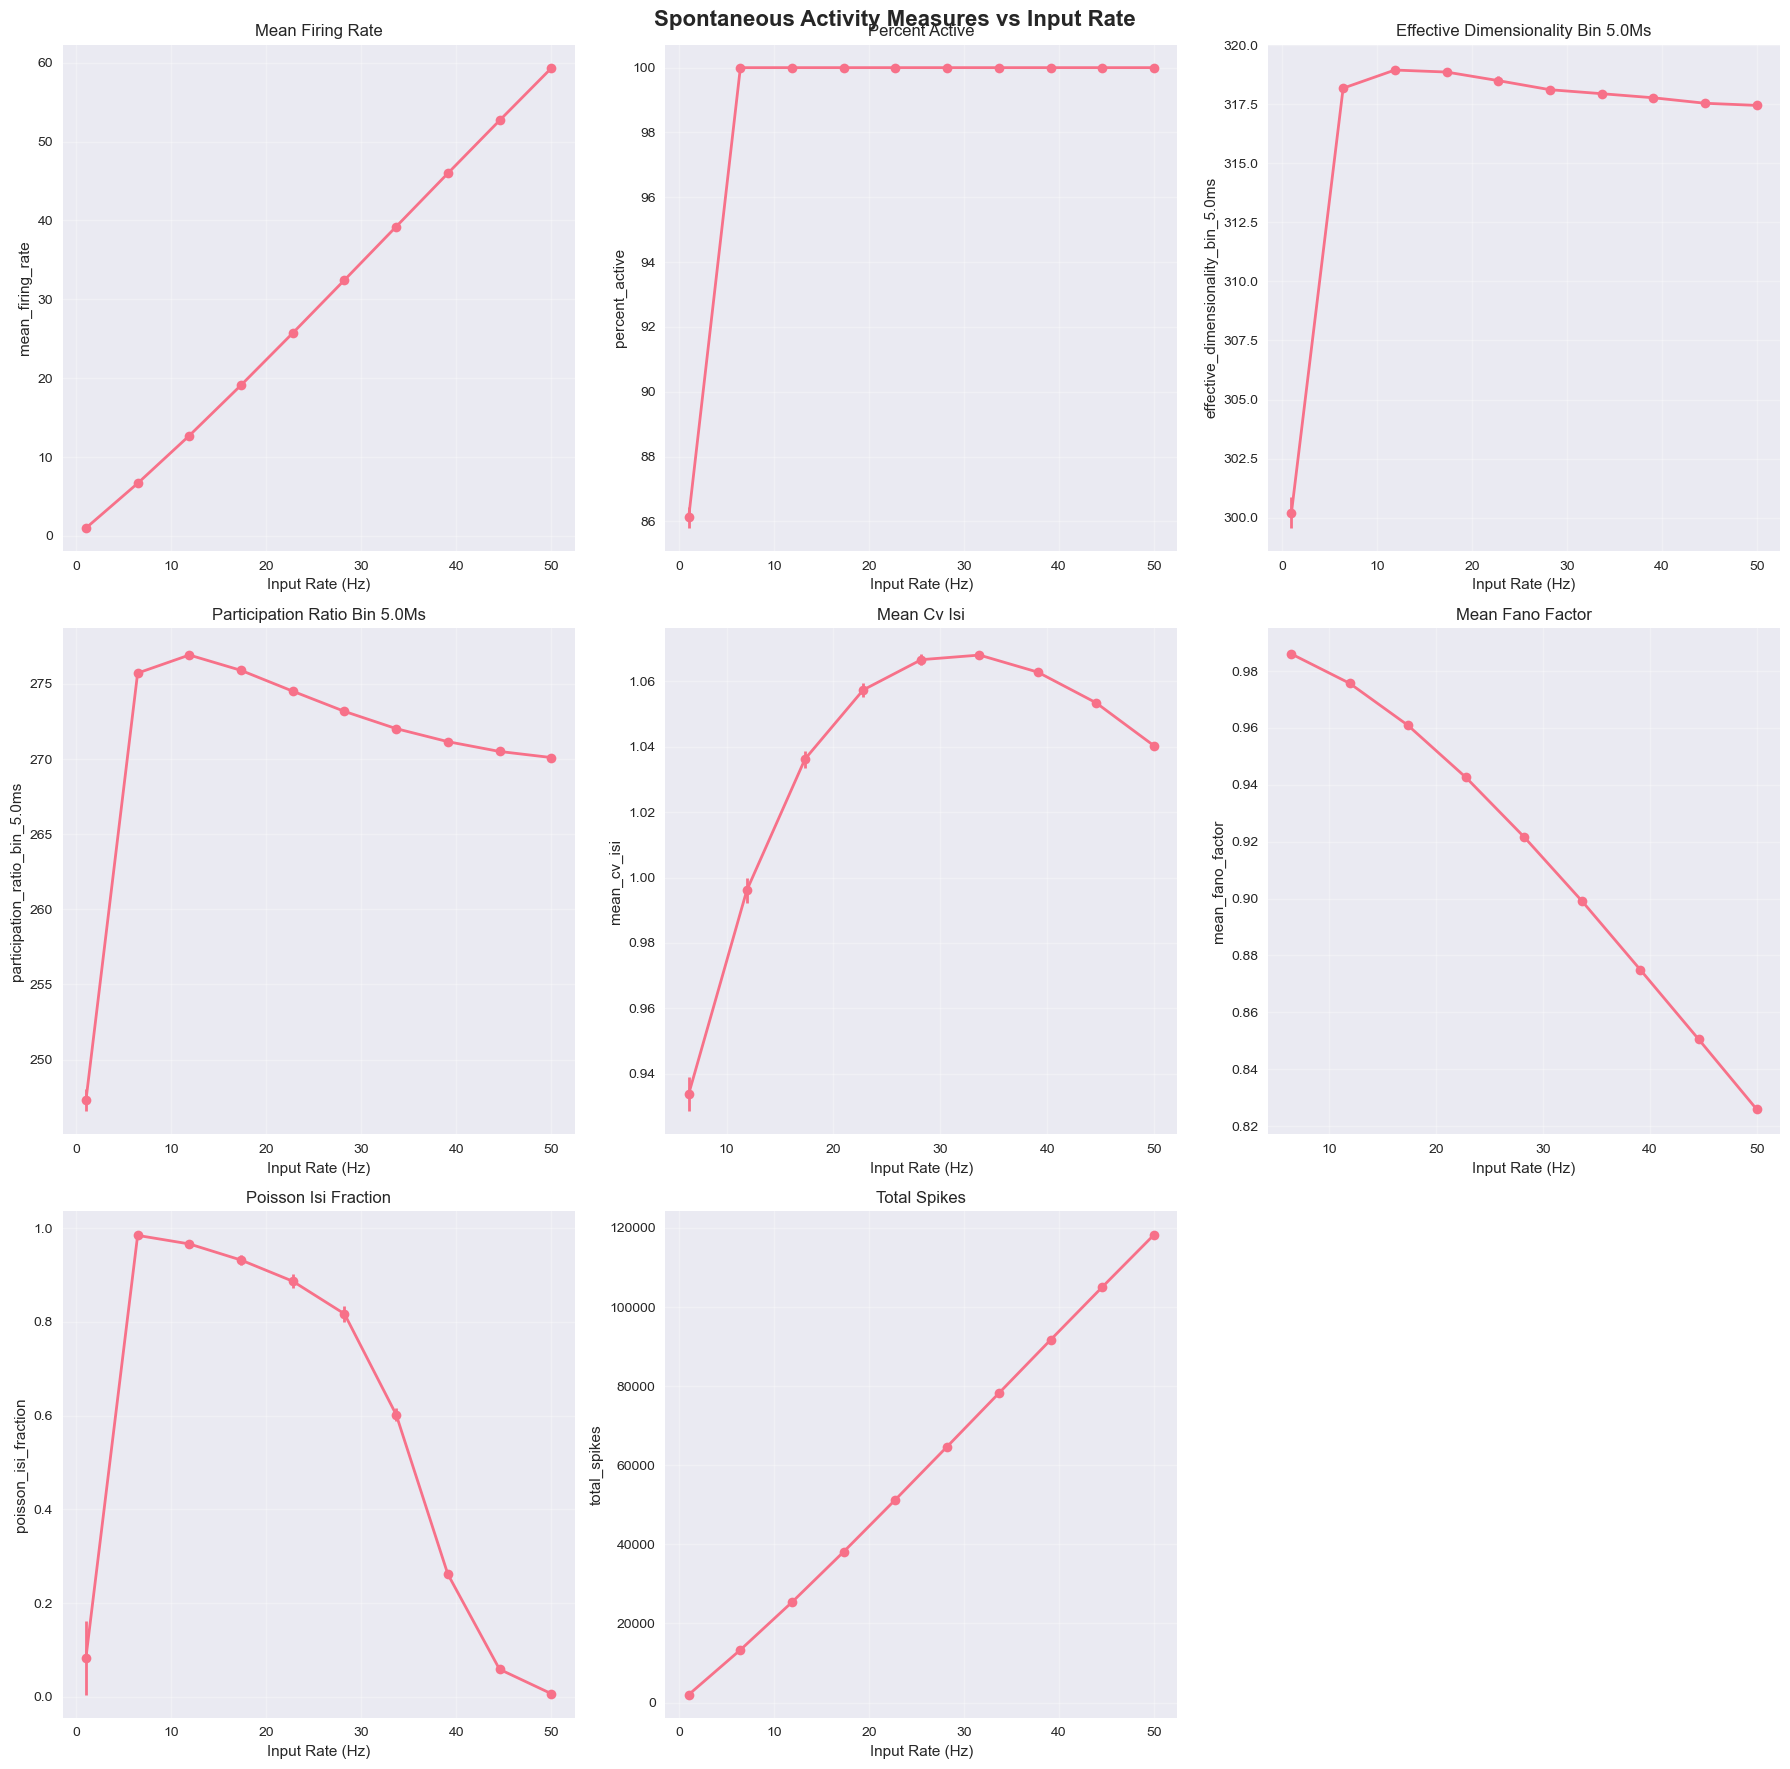


Spontaneous activity analysis plots completed!

NETWORK STABILITY ANALYSIS
Creating LZ spatial complexity heatmap...


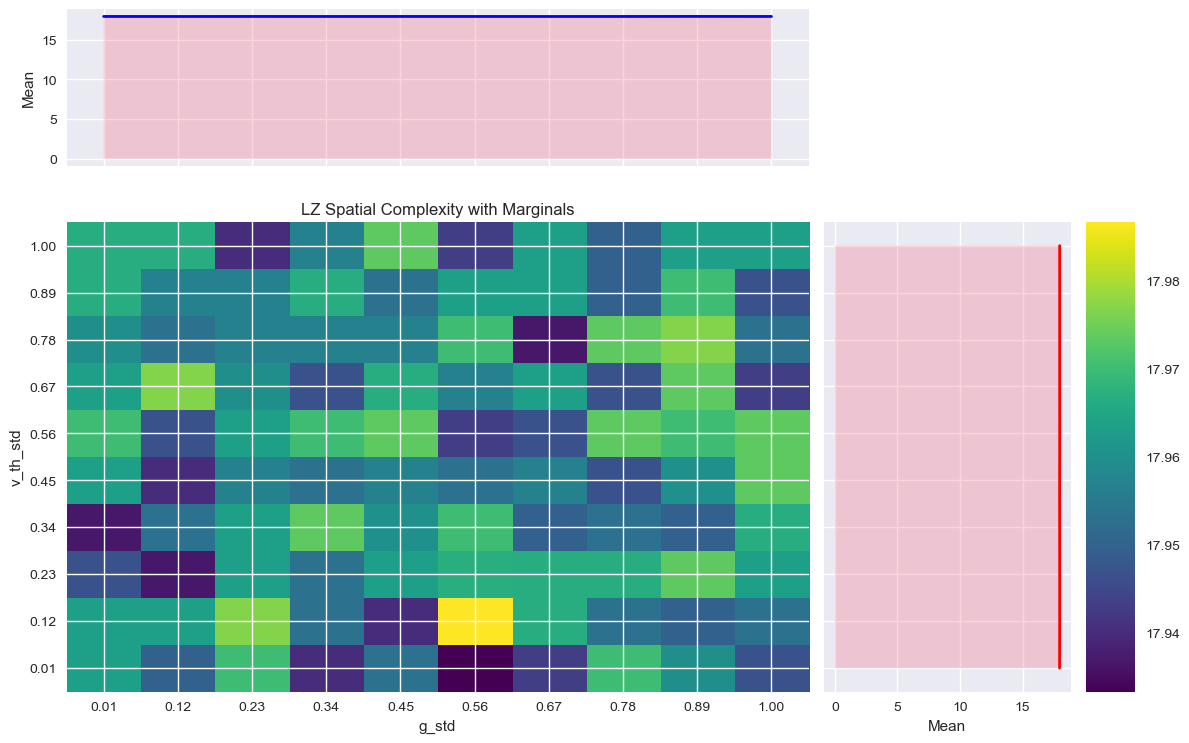

Creating Kistler coincidence heatmap...


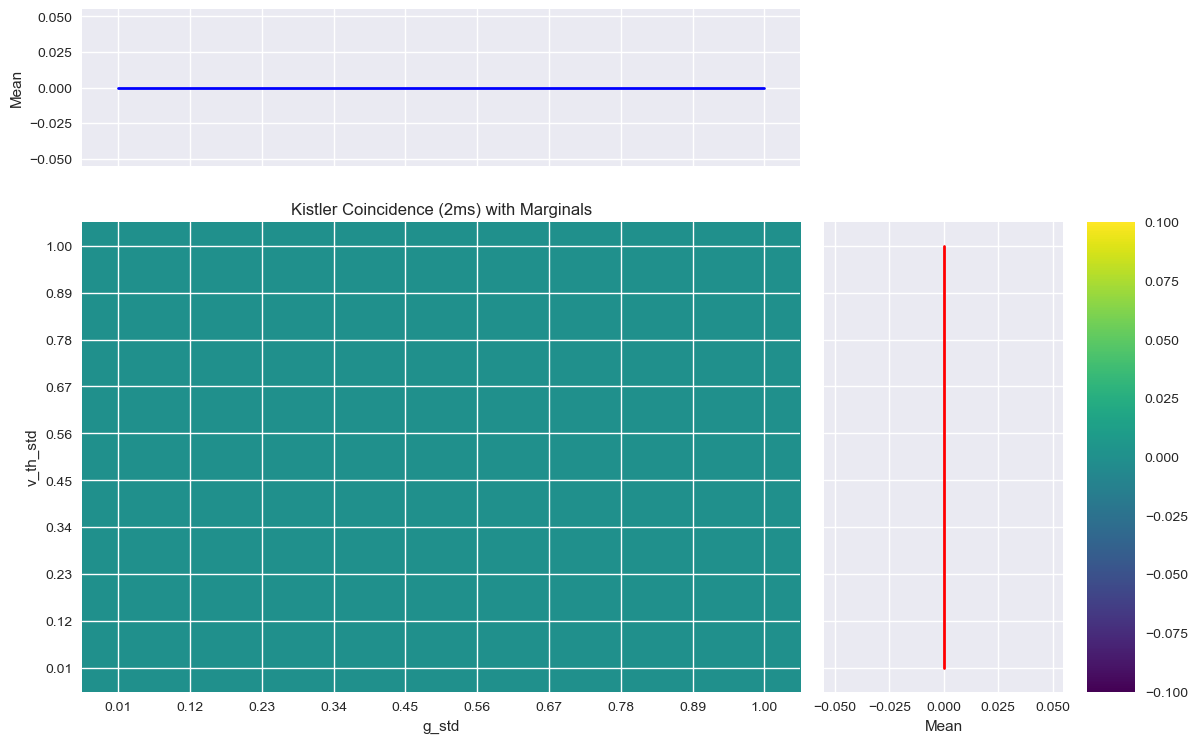

Creating Hamming slope heatmap...


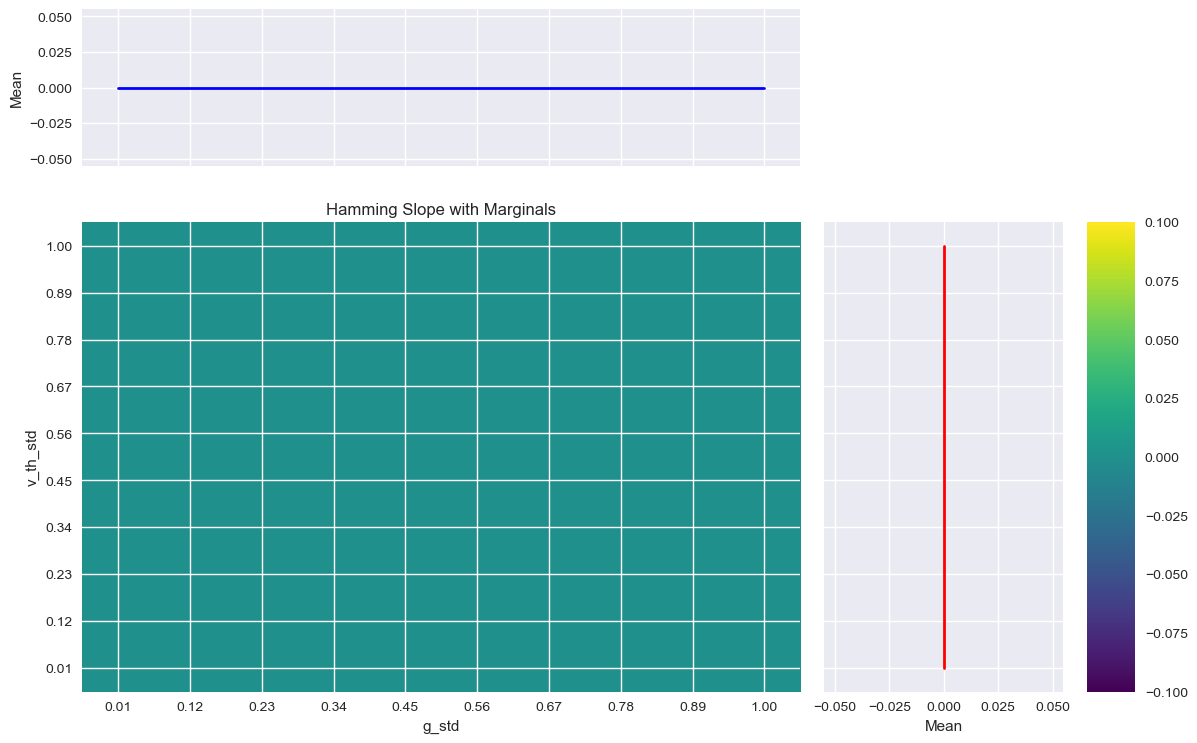

Creating spatial entropy heatmap...


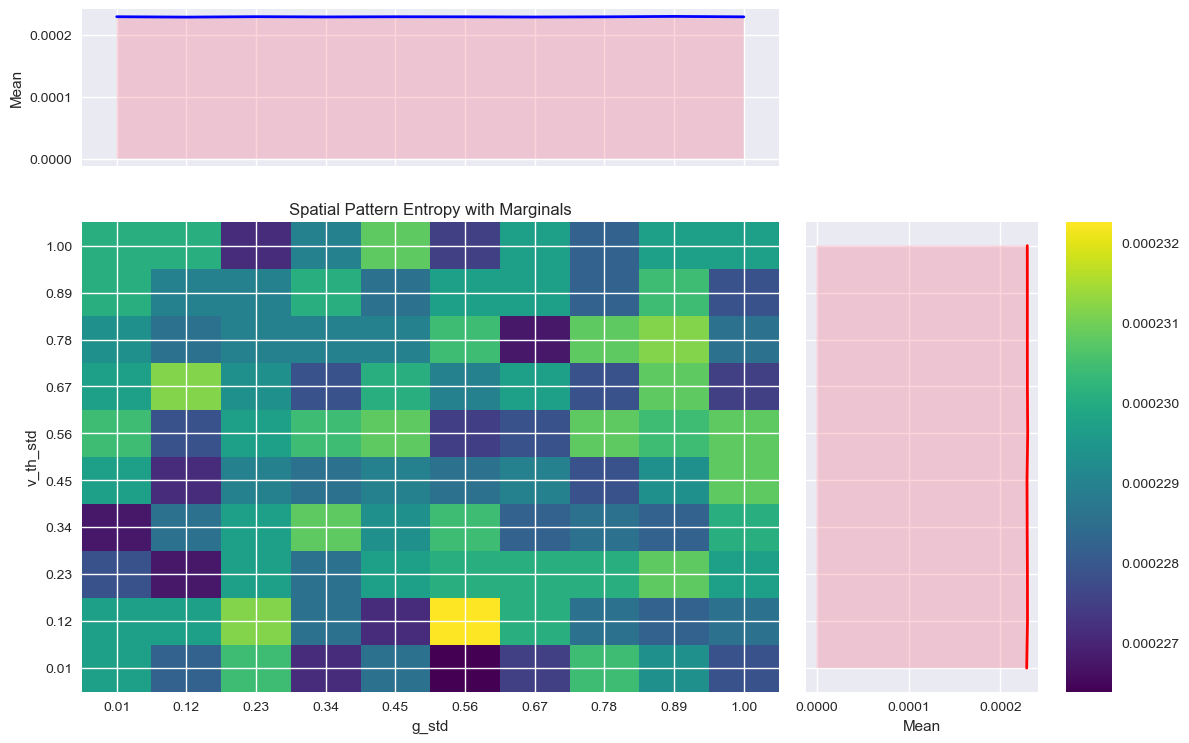

Creating stable pattern fraction heatmap...


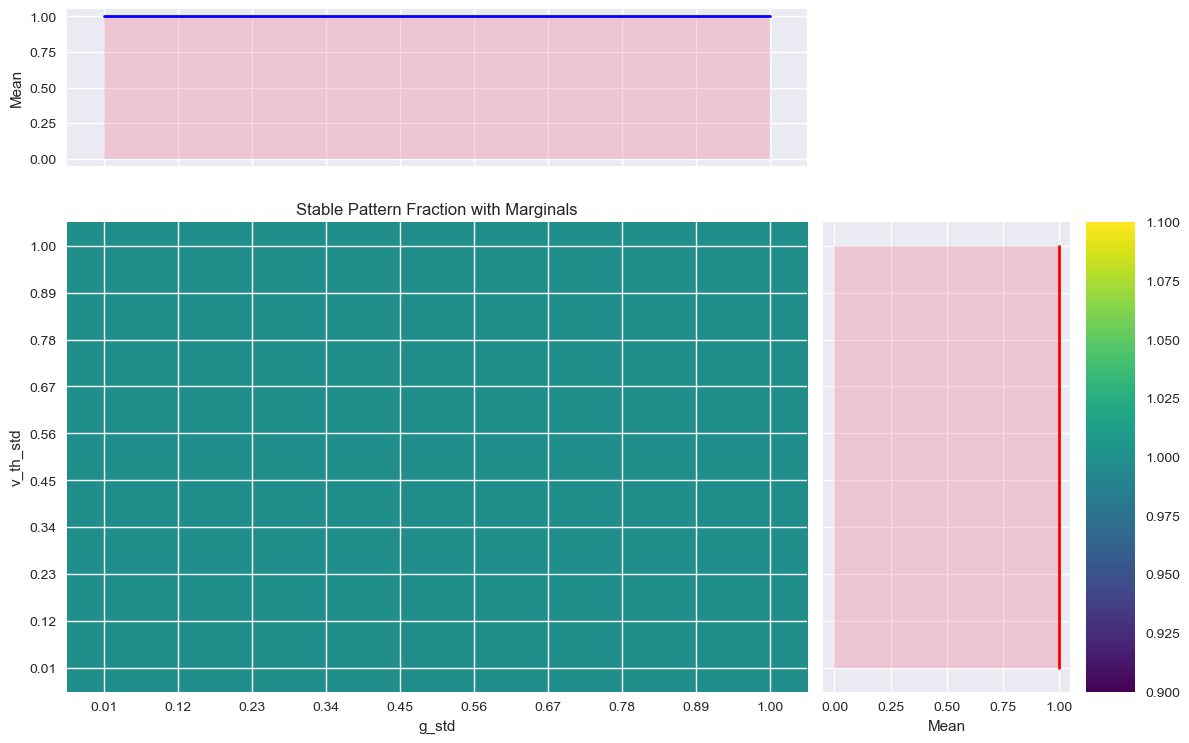

Creating stable onset time heatmap...


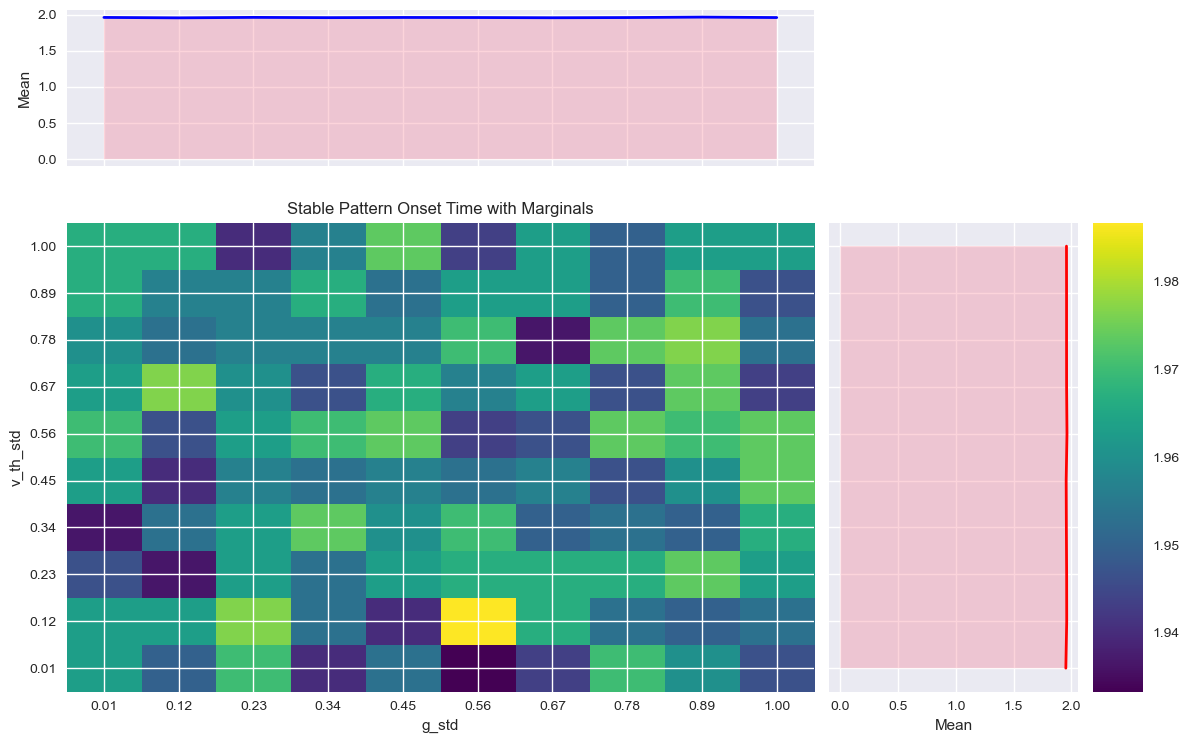

Creating gamma coincidence heatmap...


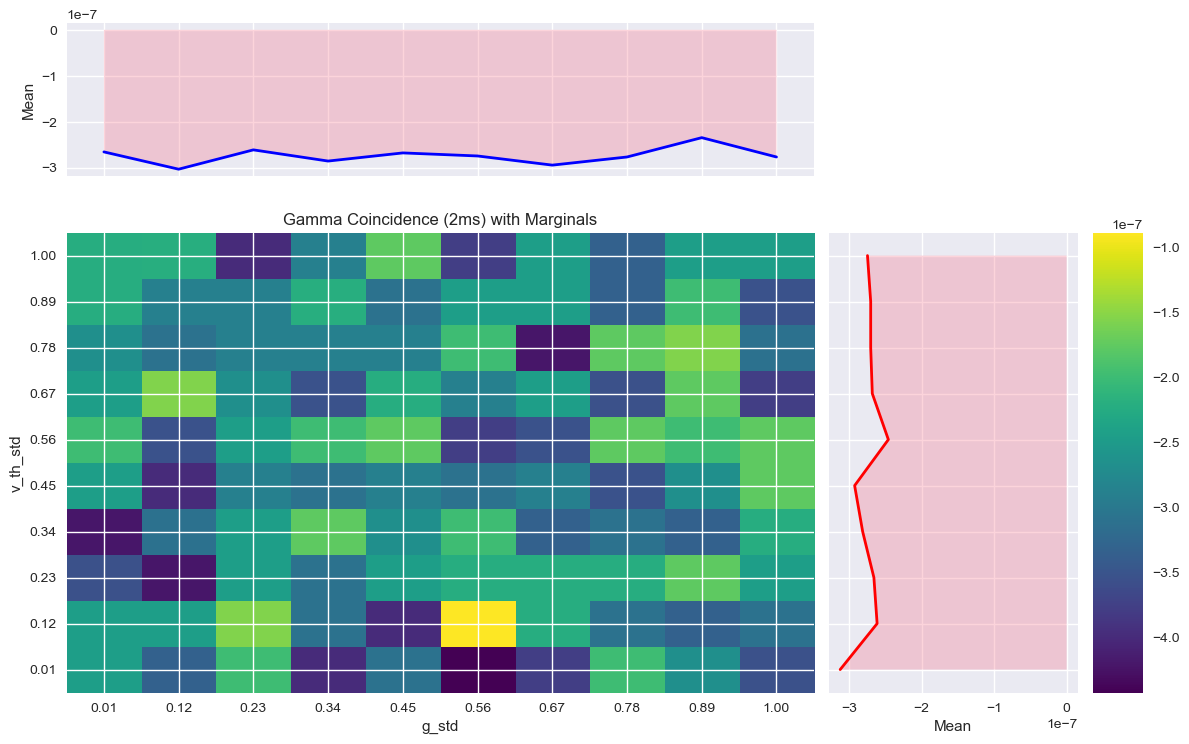

Creating stability measures vs input rate plot...


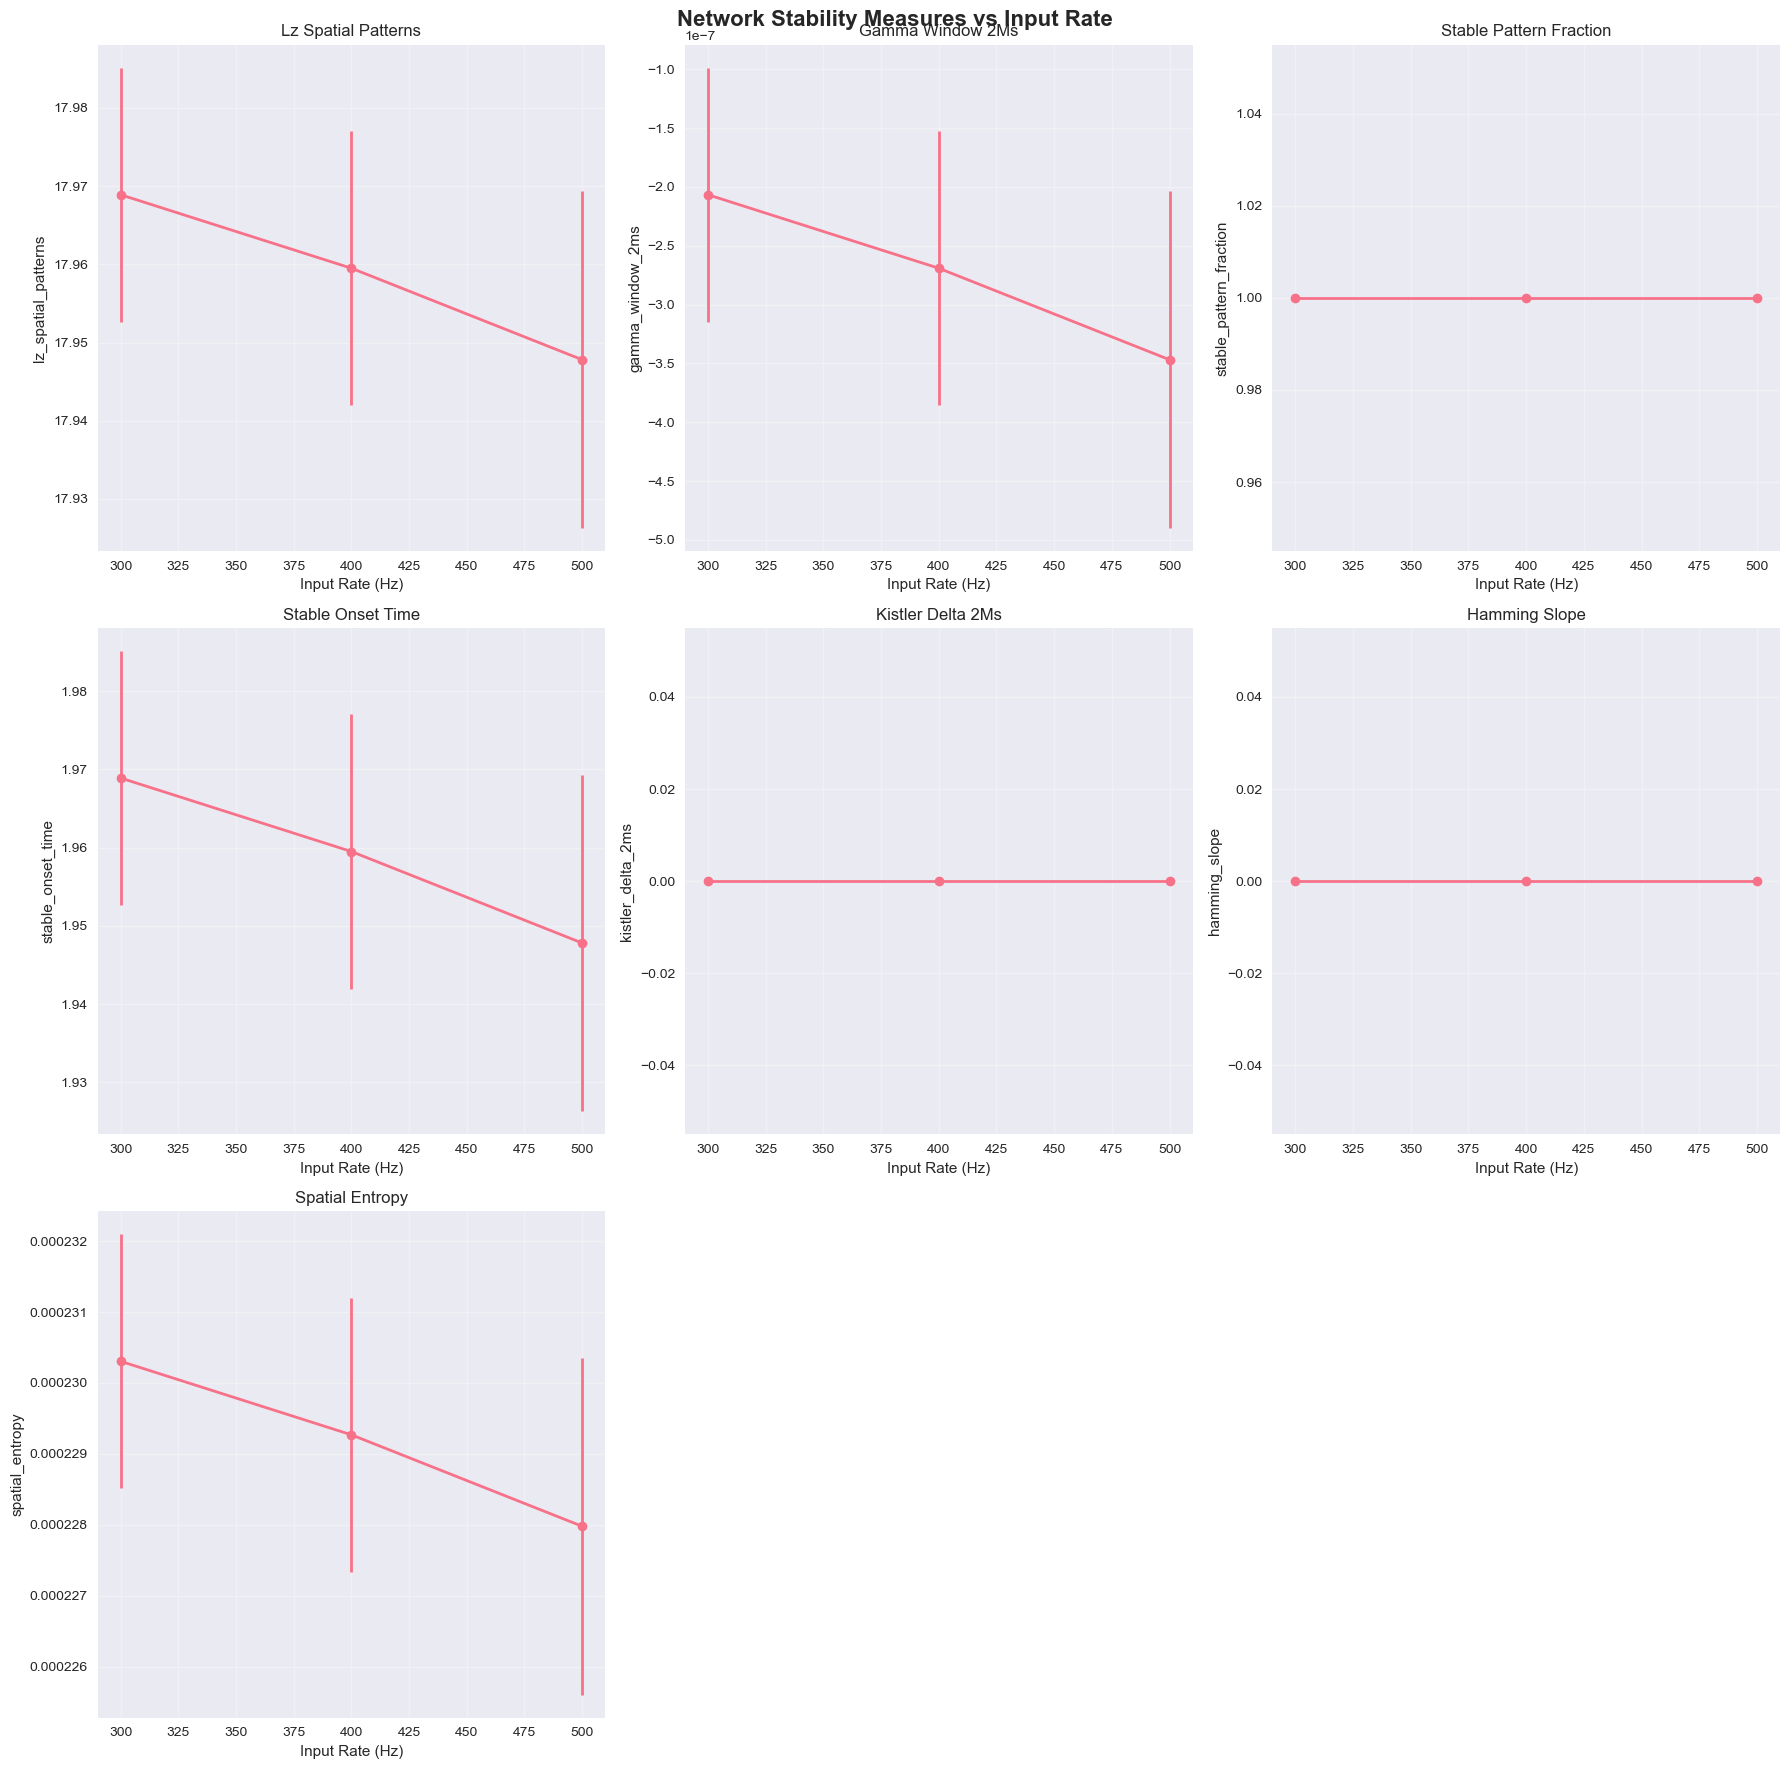


Network stability analysis plots completed!

ANALYSIS COMPLETE

New Features:
• 3D surface plots with error visualization for firing rate, dimensionality, participation ratio
• Heatmaps with marginal distributions for all key measures
• Poisson process validation plots (CV ISI, Fano Factor, Poisson-like fraction)
• Active neurons instead of silent neurons
• Participation ratio vs temporal resolution
• All measures vs input rate with Poisson metrics included
• Rate-dependent randomization validated
• Transient-corrected measurements (first 25ms removed)


In [4]:
# Enhanced Split Experiments Analysis - With Poisson Process Validation
# Analysis of simulation results from both experiment types

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# 1. LOAD EXPERIMENTAL RESULTS
# =============================================================================

def load_experimental_results():
    """Load results from both experiments"""
    
    spontaneous_file = 'results/data/spontaneous_session_1_dynamic.pkl'
    stability_file = 'results/data/stability_session_1_dynamic.pkl'
    
    try:
        with open(spontaneous_file, 'rb') as f:
            spontaneous_results = pickle.load(f)
        print(f"Loaded spontaneous activity: {len(spontaneous_results)} combinations")
    except FileNotFoundError:
        print(f"Spontaneous results not found: {spontaneous_file}")
        spontaneous_results = []
    
    try:
        with open(stability_file, 'rb') as f:
            stability_results = pickle.load(f)
        print(f"Loaded stability analysis: {len(stability_results)} combinations")
    except FileNotFoundError:
        print(f"Stability results not found: {stability_file}")
        stability_results = []
    
    return spontaneous_results, stability_results

# Load the data
spontaneous_data, stability_data = load_experimental_results()

# =============================================================================
# 2. HELPER FUNCTIONS FOR 3D PLOTS AND MARGINALS
# =============================================================================

def create_3d_surface_with_error(df, x_col, y_col, z_col, z_std_col, title):
    """Create 3D surface plot with error visualization"""
    from mpl_toolkits.mplot3d import Axes3D
    
    pivot_z = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    pivot_std = df.pivot_table(values=z_std_col, index=y_col, columns=x_col, aggfunc='mean')
    
    X, Y = np.meshgrid(pivot_z.columns, pivot_z.index)
    Z = pivot_z.values
    Z_std = pivot_std.values
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax.plot_wireframe(X, Y, Z + Z_std, alpha=0.3, color='red', linewidth=0.5)
    ax.plot_wireframe(X, Y, Z - Z_std, alpha=0.3, color='red', linewidth=0.5)
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col.replace('_mean', ''))
    ax.set_title(title)
    
    plt.colorbar(surf, ax=ax, shrink=0.5)
    return fig, ax

def create_heatmap_with_marginals(df, x_col, y_col, z_col, title, y_order_ascending=True):
    """Create heatmap with marginal plots"""
    pivot = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    
    if not y_order_ascending:
        pivot = pivot.sort_index(ascending=False)
    
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 1, 0.2], height_ratios=[1, 3, 0.2])
    
    # Main heatmap
    ax_main = fig.add_subplot(gs[1, 0])
    im = ax_main.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')
    ax_main.set_xticks(range(len(pivot.columns)))
    ax_main.set_xticklabels([f'{x:.2f}' for x in pivot.columns])
    ax_main.set_yticks(range(len(pivot.index)))
    ax_main.set_yticklabels([f'{y:.2f}' for y in pivot.index])
    ax_main.set_xlabel(x_col)
    ax_main.set_ylabel(y_col)
    ax_main.set_title(title)
    
    # Top marginal (average over y_col)
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
    marginal_x = pivot.mean(axis=0)
    ax_top.plot(range(len(marginal_x)), marginal_x.values, 'b-', linewidth=2)
    ax_top.fill_between(range(len(marginal_x)), marginal_x.values, alpha=0.3)
    ax_top.set_ylabel(f'Mean')
    ax_top.tick_params(labelbottom=False)
    
    # Right marginal (average over x_col)
    ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
    marginal_y = pivot.mean(axis=1)
    ax_right.plot(marginal_y.values, range(len(marginal_y)), 'r-', linewidth=2)
    ax_right.fill_betweenx(range(len(marginal_y)), marginal_y.values, alpha=0.3)
    ax_right.set_xlabel(f'Mean')
    ax_right.tick_params(labelleft=False)
    
    # Colorbar
    ax_cbar = fig.add_subplot(gs[1, 2])
    plt.colorbar(im, cax=ax_cbar)
    
    plt.tight_layout()
    return fig

def plot_measures_vs_input_rate(df, measures, title):
    """Plot multiple measures averaged across parameter combinations vs input rate"""
    n_measures = len(measures)
    n_cols = 3
    n_rows = (n_measures + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, measure in enumerate(measures):
        if i >= len(axes):
            break
            
        ax = axes[i]
        if measure in df.columns:
            grouped = df.groupby('static_input_rate')[measure].agg(['mean', 'std'])
            
            ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                       marker='o', capsize=5, linewidth=2)
            ax.set_xlabel('Input Rate (Hz)')
            ax.set_ylabel(measure.replace('_mean', ''))
            ax.set_title(f'{measure.replace("_mean", "").replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'{measure}\nnot available', 
                   ha='center', va='center', transform=ax.transAxes)
    
    for i in range(len(measures), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig

# =============================================================================
# 3. ENHANCED SPONTANEOUS ACTIVITY ANALYSIS
# =============================================================================

def plot_enhanced_spontaneous_activity(data):
    """Create enhanced plots for spontaneous activity data with Poisson analysis"""
    
    if not data:
        print("No spontaneous activity data to plot")
        return
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("SPONTANEOUS ACTIVITY ANALYSIS")
    print("="*80)
    
    # Get input rate info for titles
    input_rates = df['static_input_rate'].unique()
    if len(input_rates) == 1:
        rate_info = f"Input Rate: {input_rates[0]:.0f} Hz"
    else:
        rate_info = f"Averaged over {len(input_rates)} input rates ({input_rates.min():.0f}-{input_rates.max():.0f} Hz)"
    
    # 1. 3D Firing Rate with Error Bars
    if 'mean_firing_rate_mean' in df.columns and 'mean_firing_rate_std' in df.columns:
        print("Creating 3D firing rate plot...")
        fig1, ax1 = create_3d_surface_with_error(df, 'g_std', 'v_th_std', 
                                                'mean_firing_rate_mean', 'mean_firing_rate_std',
                                                f'Mean Firing Rate (Hz) - {rate_info}\nAveraged across 10 trials per combination')
        plt.show()
    
    # 2. Active Neurons Heatmap with Marginals (v_th_std ordered bottom to top)
    if 'percent_active_mean' in df.columns:
        print("Creating active neurons heatmap...")
        fig2 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'percent_active_mean',
                                           f'Active Neurons (%) - {rate_info}\nAveraged across 10 trials', 
                                           y_order_ascending=True)
        plt.show()
    
    # 3. 3D Effective Dimensionality
    if 'effective_dimensionality_bin_5.0ms_mean' in df.columns and 'effective_dimensionality_bin_5.0ms_std' in df.columns:
        print("Creating 3D dimensionality plot...")
        fig3, ax3 = create_3d_surface_with_error(df, 'g_std', 'v_th_std',
                                                'effective_dimensionality_bin_5.0ms_mean', 
                                                'effective_dimensionality_bin_5.0ms_std',
                                                f'Effective Dimensionality (5ms bins) - {rate_info}\nNumber of PCA dimensions explaining 95% variance')
        plt.show()
    
    # 4. 3D Participation Ratio
    if 'participation_ratio_bin_5.0ms_mean' in df.columns and 'participation_ratio_bin_5.0ms_std' in df.columns:
        print("Creating 3D participation ratio plot...")
        fig4, ax4 = create_3d_surface_with_error(df, 'g_std', 'v_th_std',
                                                'participation_ratio_bin_5.0ms_mean',
                                                'participation_ratio_bin_5.0ms_std',
                                                f'Participation Ratio (5ms bins) - {rate_info}\n(Σλᵢ)²/Σ(λᵢ²) - Network-wide activity distribution')
        plt.show()
    
    # 5. Dimensionality vs Temporal Resolution
    print("Creating dimensionality vs temporal resolution plot...")
    bin_sizes = ['0.1ms', '2.0ms', '5.0ms', '20.0ms', '50.0ms', '100.0ms']
    dim_means = []
    dim_stds = []
    
    for bin_size in bin_sizes:
        col_name = f'effective_dimensionality_bin_{bin_size}_mean'
        if col_name in df.columns:
            dim_means.append(df[col_name].mean())
            dim_stds.append(df[col_name].std())
        else:
            dim_means.append(0)
            dim_stds.append(0)
    
    fig5, ax5 = plt.subplots(figsize=(10, 6))
    ax5.errorbar(range(len(bin_sizes)), dim_means, yerr=dim_stds, 
                marker='o', capsize=5, linewidth=2, color='blue')
    ax5.set_xticks(range(len(bin_sizes)))
    ax5.set_xticklabels(bin_sizes)
    ax5.set_xlabel('Bin Size')
    ax5.set_ylabel('Effective Dimensionality')
    ax5.set_title('Dimensionality vs Temporal Resolution')
    ax5.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 6. Participation Ratio vs Temporal Resolution
    print("Creating participation ratio vs temporal resolution plot...")
    pr_means = []
    pr_stds = []
    
    for bin_size in bin_sizes:
        col_name = f'participation_ratio_bin_{bin_size}_mean'
        if col_name in df.columns:
            pr_means.append(df[col_name].mean())
            pr_stds.append(df[col_name].std())
        else:
            pr_means.append(0)
            pr_stds.append(0)
    
    fig6, ax6 = plt.subplots(figsize=(10, 6))
    ax6.errorbar(range(len(bin_sizes)), pr_means, yerr=pr_stds, 
                marker='s', capsize=5, linewidth=2, color='red')
    ax6.set_xticks(range(len(bin_sizes)))
    ax6.set_xticklabels(bin_sizes)
    ax6.set_xlabel('Bin Size')
    ax6.set_ylabel('Participation Ratio')
    ax6.set_title('Participation Ratio vs Temporal Resolution')
    ax6.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 7. NEW: Poisson Analysis - CV ISI Heatmap
    if 'mean_cv_isi_mean' in df.columns:
        print("Creating CV ISI heatmap...")
        fig7 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'mean_cv_isi_mean',
                                           f'Coefficient of Variation (CV) of ISI - {rate_info}\n' + 
                                           'Mean CV across neurons with ≥10 spikes | Expected: 1.0 for Poisson process\n' +
                                           'CV = std(ISI)/mean(ISI) | Averaged across 10 trials',
                                           y_order_ascending=True)
        plt.show()
    
    # 8. NEW: Poisson Analysis - Fano Factor Heatmap
    if 'mean_fano_factor_mean' in df.columns:
        print("Creating Fano Factor heatmap...")
        fig8 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'mean_fano_factor_mean',
                                           f'Fano Factor - {rate_info}\n' +
                                           'Mean Fano Factor across neurons with ≥10 spikes | Expected: 1.0 for Poisson\n' +
                                           'Fano = var(spike counts)/mean(spike counts) in 10ms bins | Averaged across 10 trials',
                                           y_order_ascending=True)
        plt.show()
    
    # 9. NEW: Poisson-like Fraction Heatmap
    if 'poisson_isi_fraction_mean' in df.columns:
        print("Creating Poisson-like fraction heatmap...")
        fig9 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'poisson_isi_fraction_mean',
                                           f'Fraction of Poisson-like Neurons - {rate_info}\n' +
                                           'Neurons passing Kolmogorov-Smirnov test (p>0.05) for exponential ISI distribution\n' +
                                           'Only neurons with ≥10 spikes tested | Averaged across 10 trials',
                                           y_order_ascending=True)
        plt.show()
    
    # 10. All Measures vs Input Rate (including Poisson)
    print("Creating measures vs input rate plot...")
    spontaneous_measures = [
        'mean_firing_rate_mean',
        'percent_active_mean',  # Changed from percent_silent
        'effective_dimensionality_bin_5.0ms_mean',
        'participation_ratio_bin_5.0ms_mean',
        'mean_cv_isi_mean',
        'mean_fano_factor_mean',
        'poisson_isi_fraction_mean',
        'total_spikes_mean'
    ]
    
    fig10 = plot_measures_vs_input_rate(df, spontaneous_measures, 
                                       'Spontaneous Activity Measures vs Input Rate')
    plt.show()
    
    print("\nSpontaneous activity analysis plots completed!")

# =============================================================================
# 4. ENHANCED STABILITY ANALYSIS
# =============================================================================

def plot_enhanced_stability_analysis(data):
    """Create enhanced plots for network stability data"""
    
    if not data:
        print("No stability data to plot")
        return
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("NETWORK STABILITY ANALYSIS")
    print("="*80)
    
    # 1. LZ Spatial Complexity Heatmap with Marginals
    if 'lz_spatial_patterns_mean' in df.columns:
        print("Creating LZ spatial complexity heatmap...")
        fig1 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'lz_spatial_patterns_mean',
                                           'LZ Spatial Complexity with Marginals')
        plt.show()
    
    # 2. Kistler Coincidence Heatmap with Marginals
    if 'kistler_delta_2ms_mean' in df.columns:
        print("Creating Kistler coincidence heatmap...")
        fig2 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'kistler_delta_2ms_mean',
                                           'Kistler Coincidence (2ms) with Marginals')
        plt.show()
    
    # 3. Hamming Slope Heatmap with Marginals
    if 'hamming_slope_mean' in df.columns:
        print("Creating Hamming slope heatmap...")
        fig3 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'hamming_slope_mean',
                                           'Hamming Slope with Marginals')
        plt.show()
    
    # 4. Spatial Entropy Heatmap with Marginals
    if 'spatial_entropy_mean' in df.columns:
        print("Creating spatial entropy heatmap...")
        fig4 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'spatial_entropy_mean',
                                           'Spatial Pattern Entropy with Marginals')
        plt.show()
    
    # 5. Stable Pattern Fraction Heatmap with Marginals
    if 'stable_pattern_fraction' in df.columns:
        print("Creating stable pattern fraction heatmap...")
        fig5 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'stable_pattern_fraction',
                                           'Stable Pattern Fraction with Marginals')
        plt.show()
    
    # 6. Stable Pattern Onset Time Heatmap with Marginals
    if 'stable_onset_time_mean' in df.columns:
        print("Creating stable onset time heatmap...")
        fig6 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'stable_onset_time_mean',
                                           'Stable Pattern Onset Time with Marginals')
        plt.show()
    
    # 7. Gamma Coincidence Heatmap with Marginals
    if 'gamma_window_2ms_mean' in df.columns:
        print("Creating gamma coincidence heatmap...")
        fig7 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'gamma_window_2ms_mean',
                                           'Gamma Coincidence (2ms) with Marginals')
        plt.show()
    
    # 8. All Stability Measures vs Input Rate
    print("Creating stability measures vs input rate plot...")
    stability_measures = [
        'lz_spatial_patterns_mean',
        'gamma_window_2ms_mean',
        'stable_pattern_fraction',
        'stable_onset_time_mean',
        'kistler_delta_2ms_mean',
        'hamming_slope_mean',
        'spatial_entropy_mean'
    ]
    
    fig8 = plot_measures_vs_input_rate(df, stability_measures,
                                      'Network Stability Measures vs Input Rate')
    plt.show()
    
    print("\nNetwork stability analysis plots completed!")

# =============================================================================
# 5. EXECUTE ENHANCED ANALYSIS
# =============================================================================

print("="*80)
print("ENHANCED SPLIT EXPERIMENTS ANALYSIS")
print("With Poisson Process Validation")
print("="*80)

plot_enhanced_spontaneous_activity(spontaneous_data)
plot_enhanced_stability_analysis(stability_data)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nNew Features:")
print("• 3D surface plots with error visualization for firing rate, dimensionality, participation ratio")
print("• Heatmaps with marginal distributions for all key measures")
print("• Poisson process validation plots (CV ISI, Fano Factor, Poisson-like fraction)")
print("• Active neurons instead of silent neurons")
print("• Participation ratio vs temporal resolution")
print("• All measures vs input rate with Poisson metrics included")
print("• Rate-dependent randomization validated")
print("• Transient-corrected measurements (first 25ms removed)")

Loaded spontaneous activity: 1000 combinations
Loaded stability analysis: 300 combinations
ENHANCED SPLIT EXPERIMENTS ANALYSIS
With Poisson Process Validation

SPONTANEOUS ACTIVITY ANALYSIS
Plotting for input rate: 6.4 Hz
Creating 3D firing rate plot...


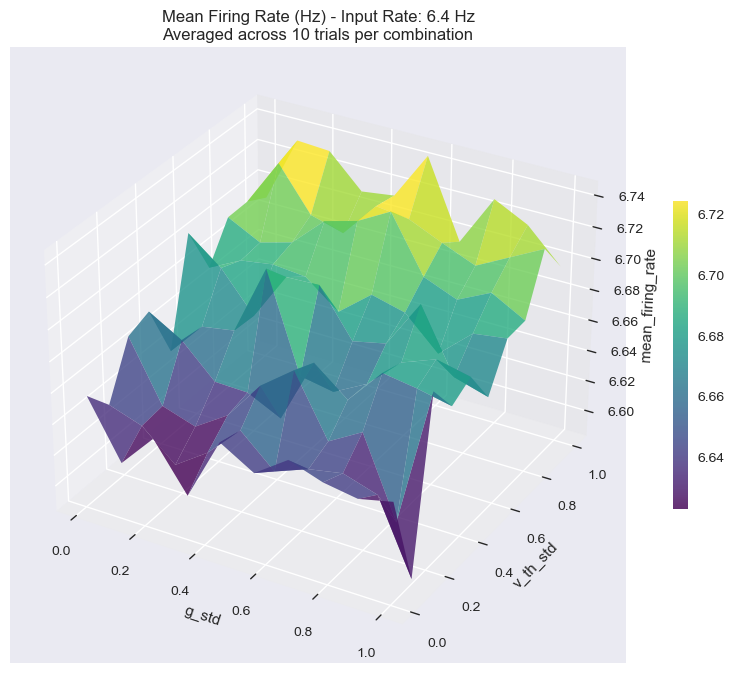

Creating 3D active neurons plot...


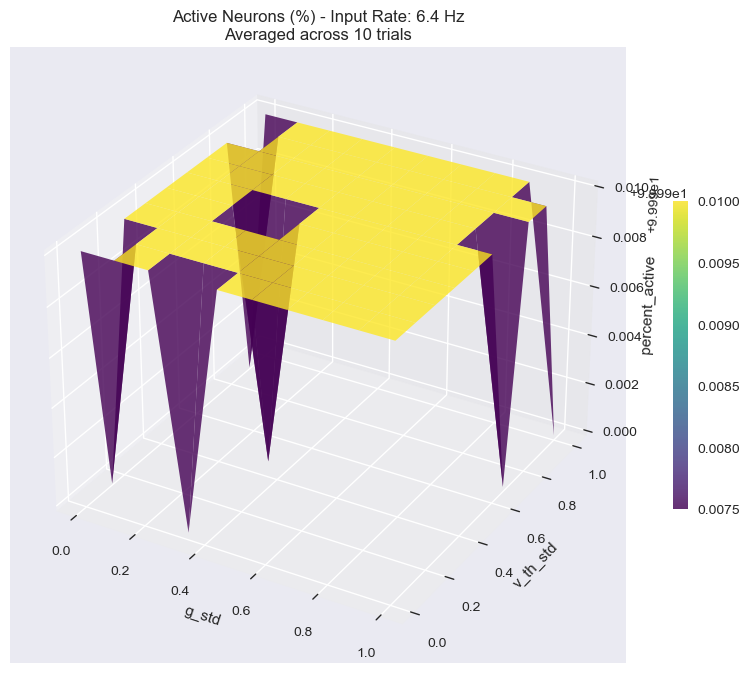

Creating 3D dimensionality plot...


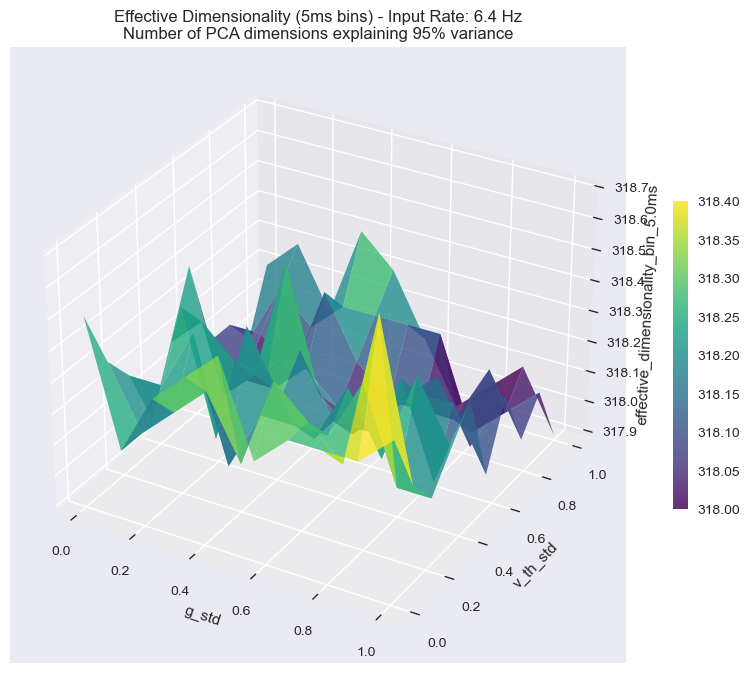

Creating 3D participation ratio plot...


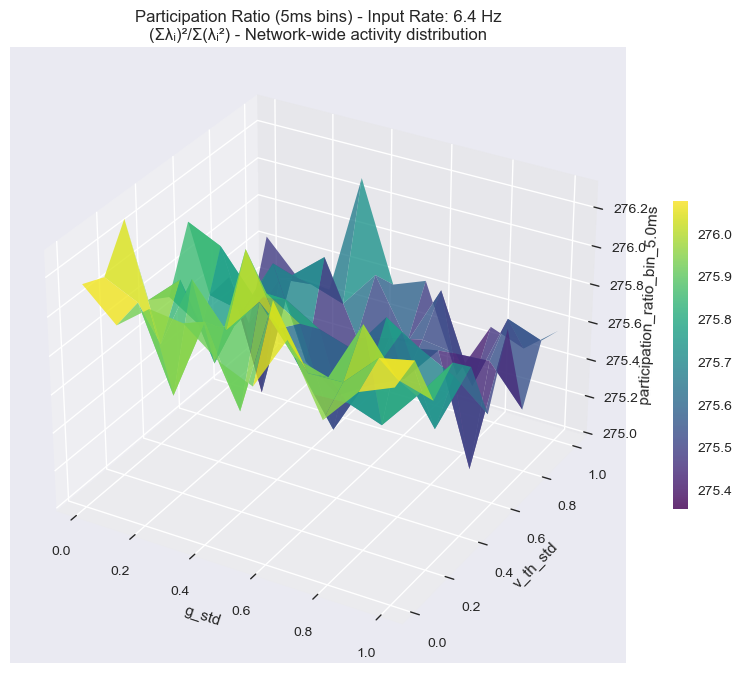

Creating dimensionality vs temporal resolution plot...


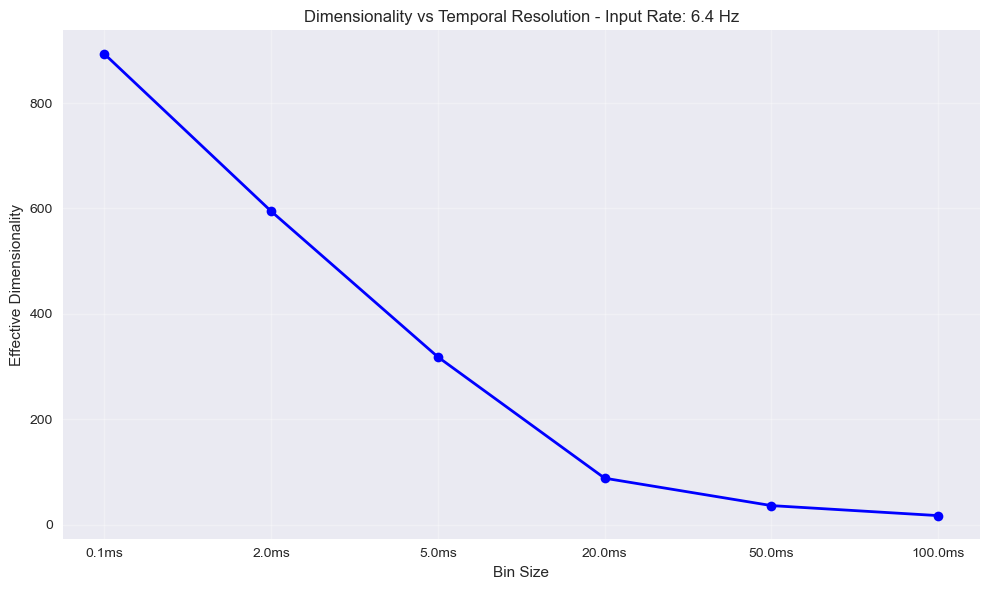

Creating participation ratio vs temporal resolution plot...


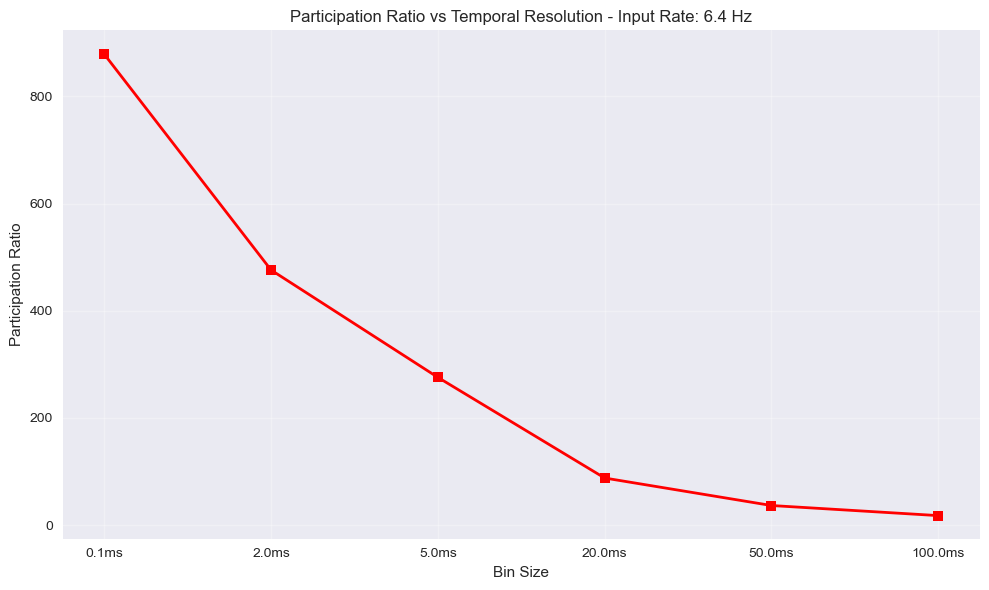

Plotting fraction of neurons with ≥10 spikes instead...


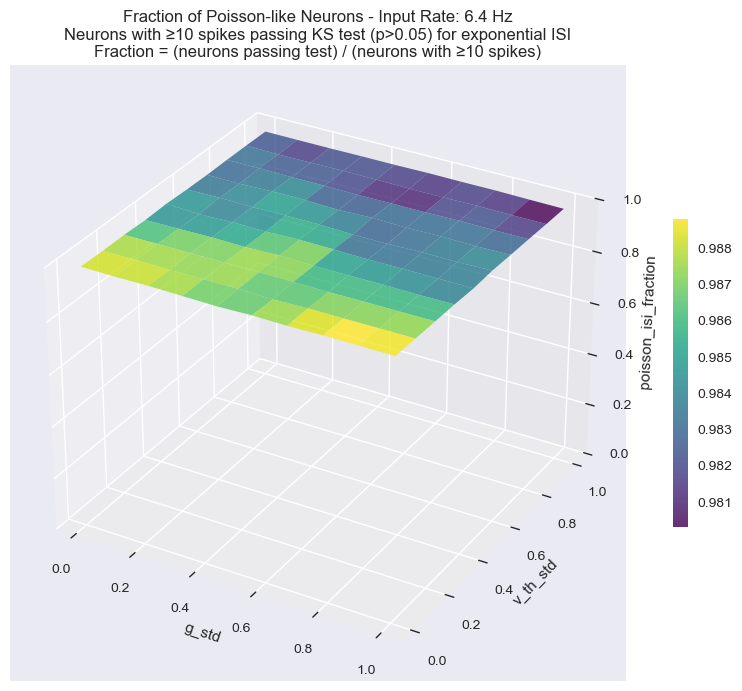

Creating measures vs input rate plot...


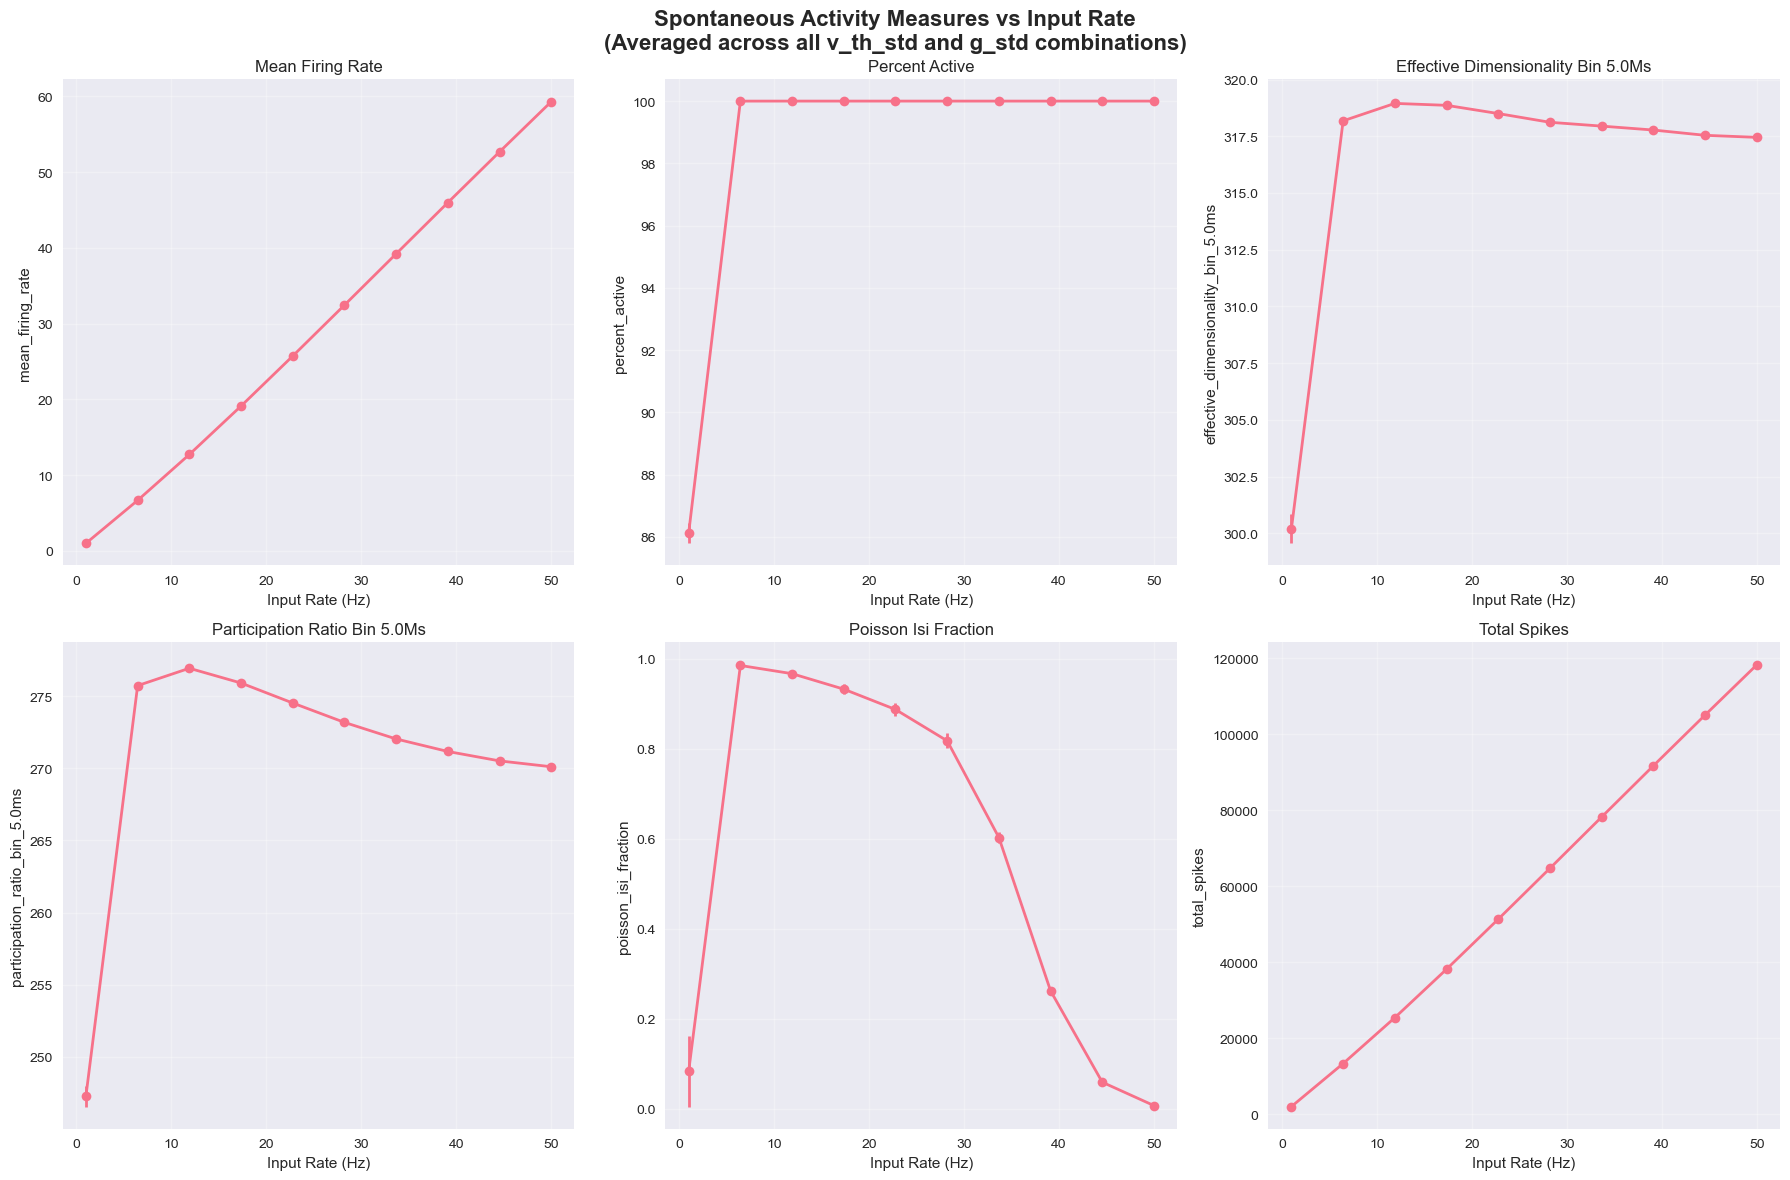


Spontaneous activity analysis plots completed!
Note: Heatmaps and 3D plots show data for 6.4 Hz input rate only
Note: Poisson-like fraction = (neurons passing KS test) / (neurons with ≥10 spikes)
      NOT all neurons, NOT all active neurons

NETWORK STABILITY ANALYSIS
Creating LZ spatial complexity heatmap...


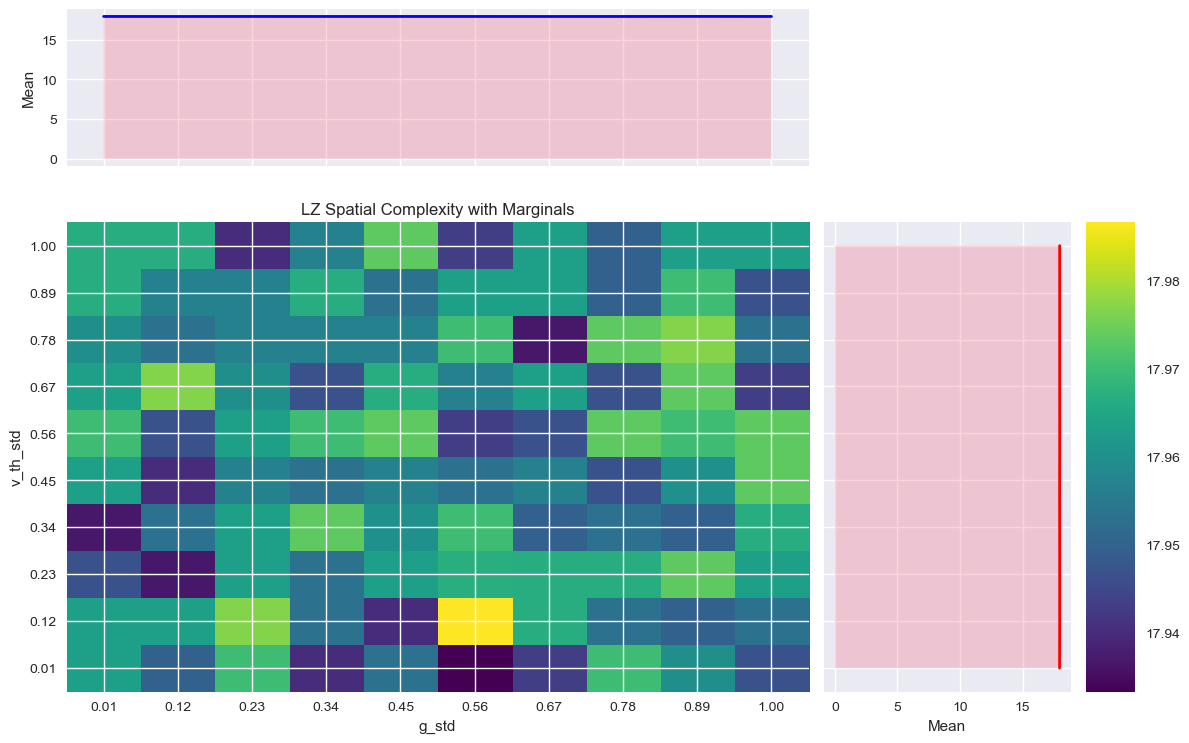

Creating Kistler coincidence heatmap...


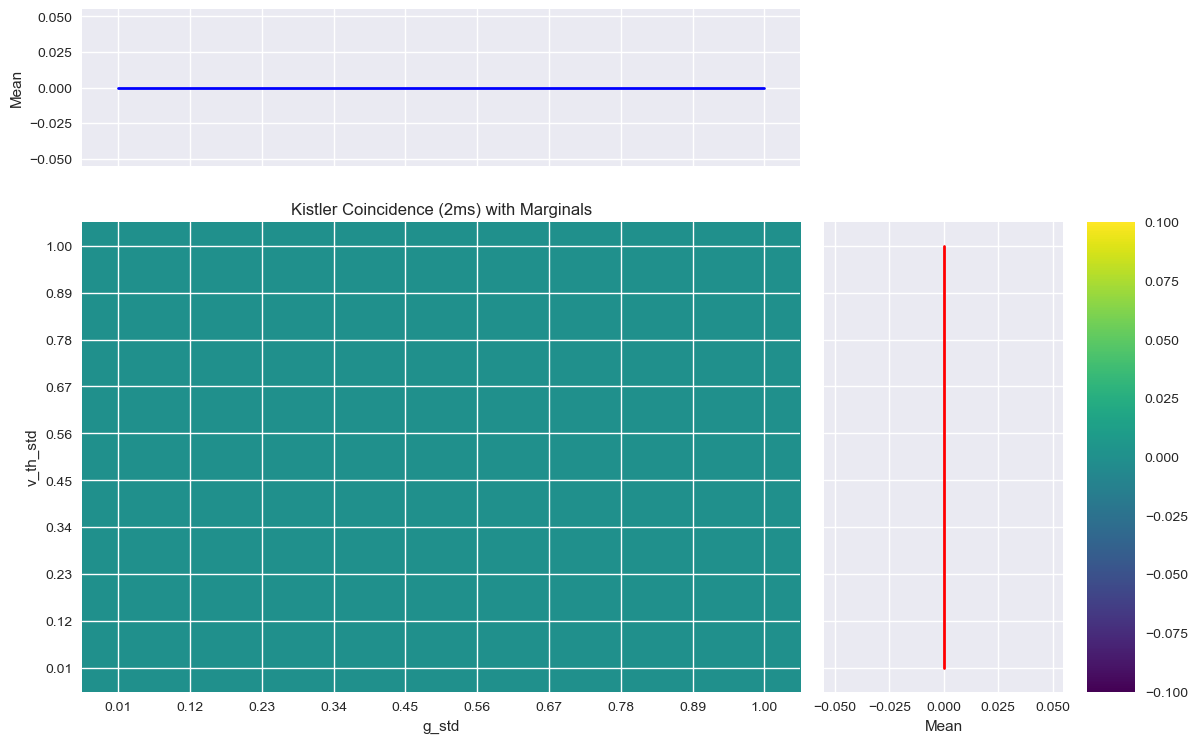

Creating Hamming slope heatmap...


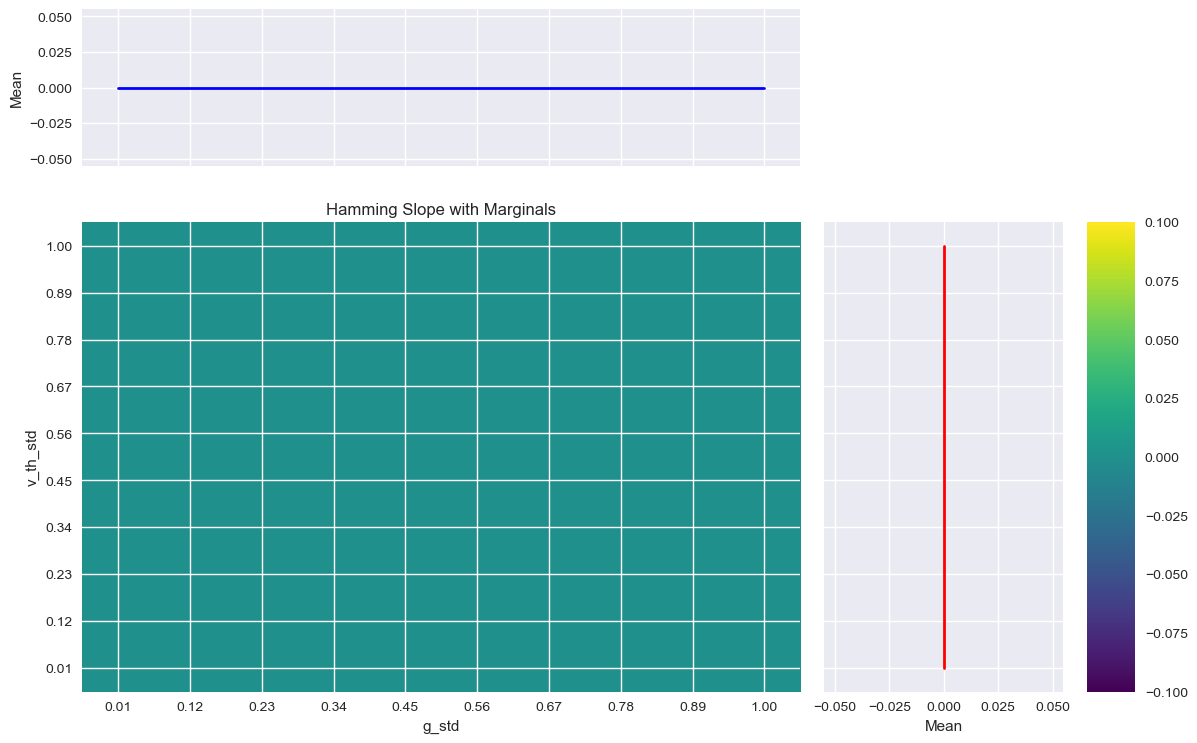

Creating spatial entropy heatmap...


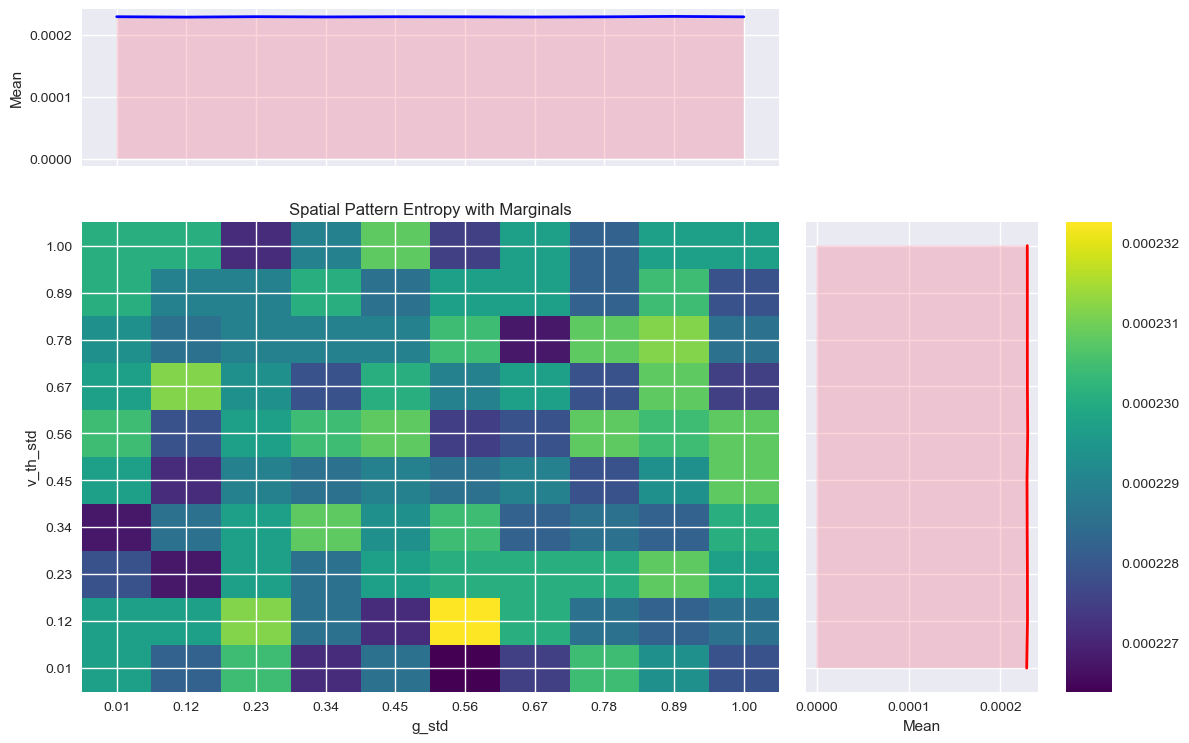

Creating stable pattern fraction heatmap...


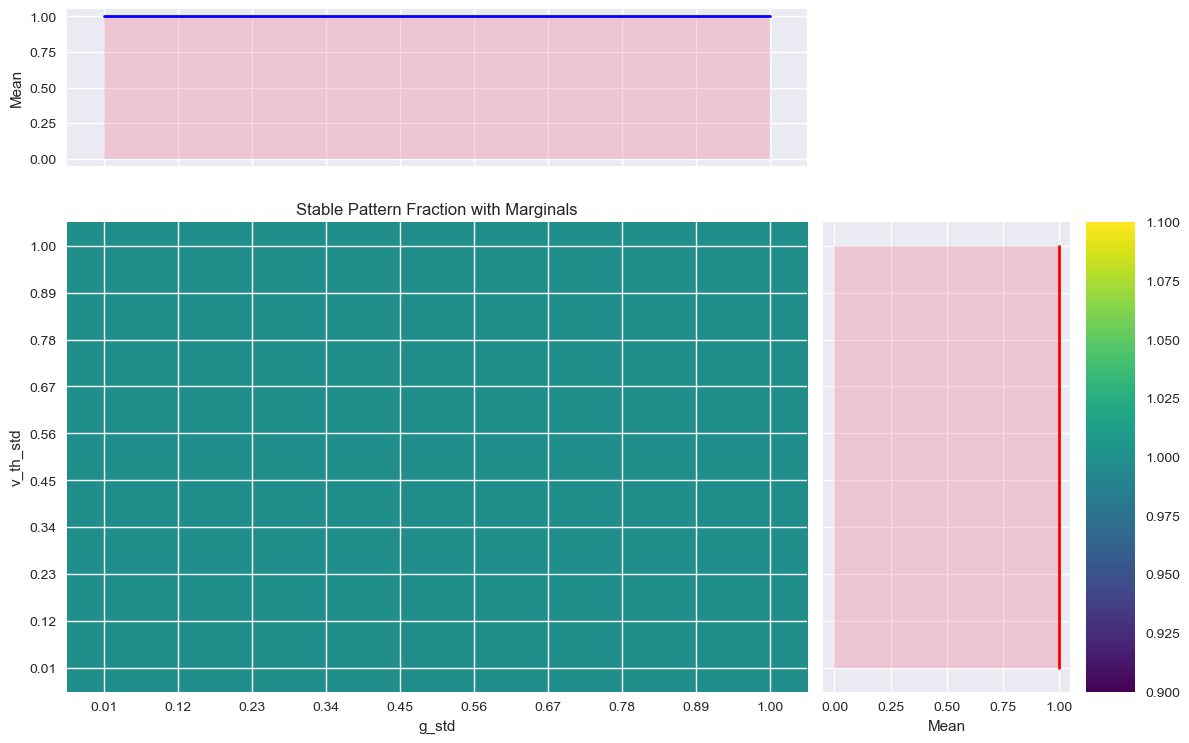

Creating stable onset time heatmap...


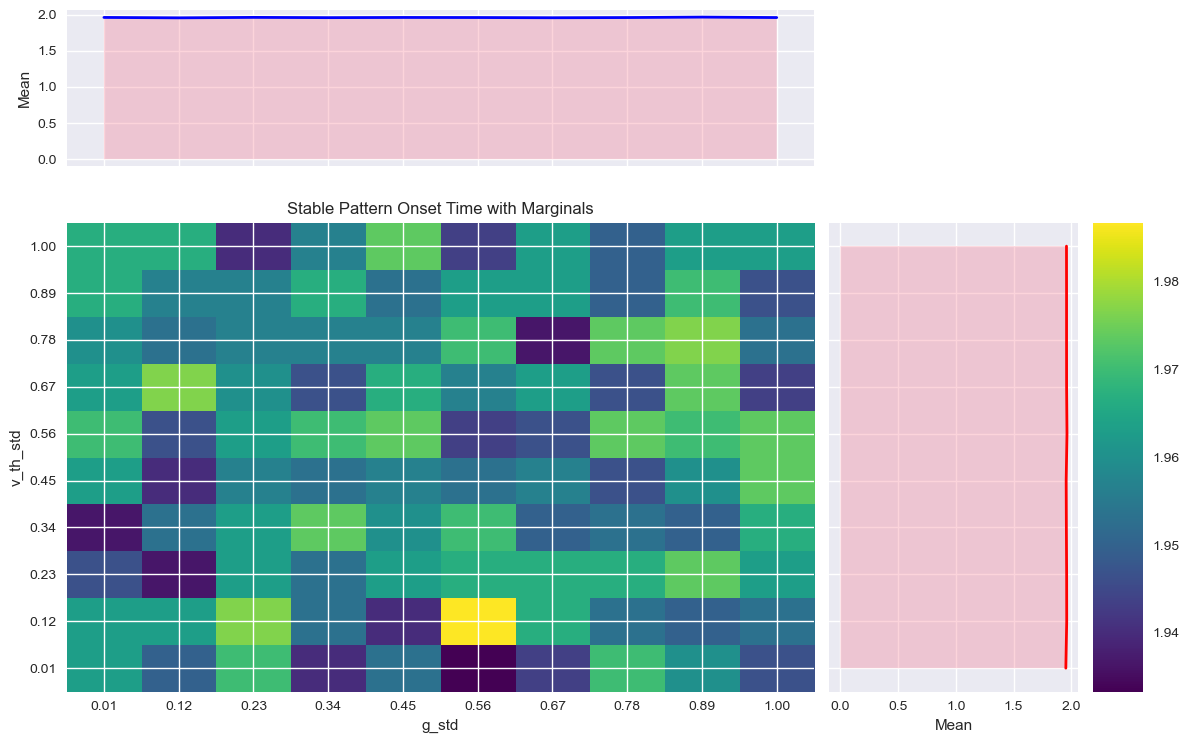

Creating gamma coincidence heatmap...


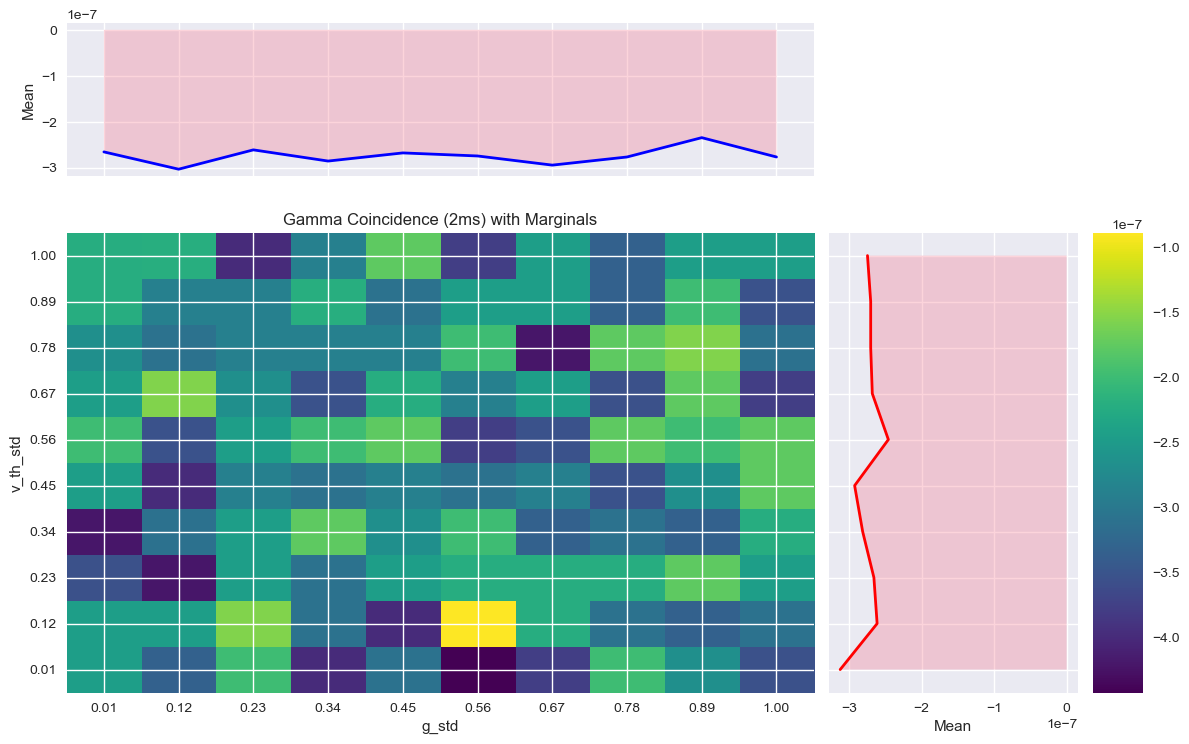

Creating stability measures vs input rate plot...


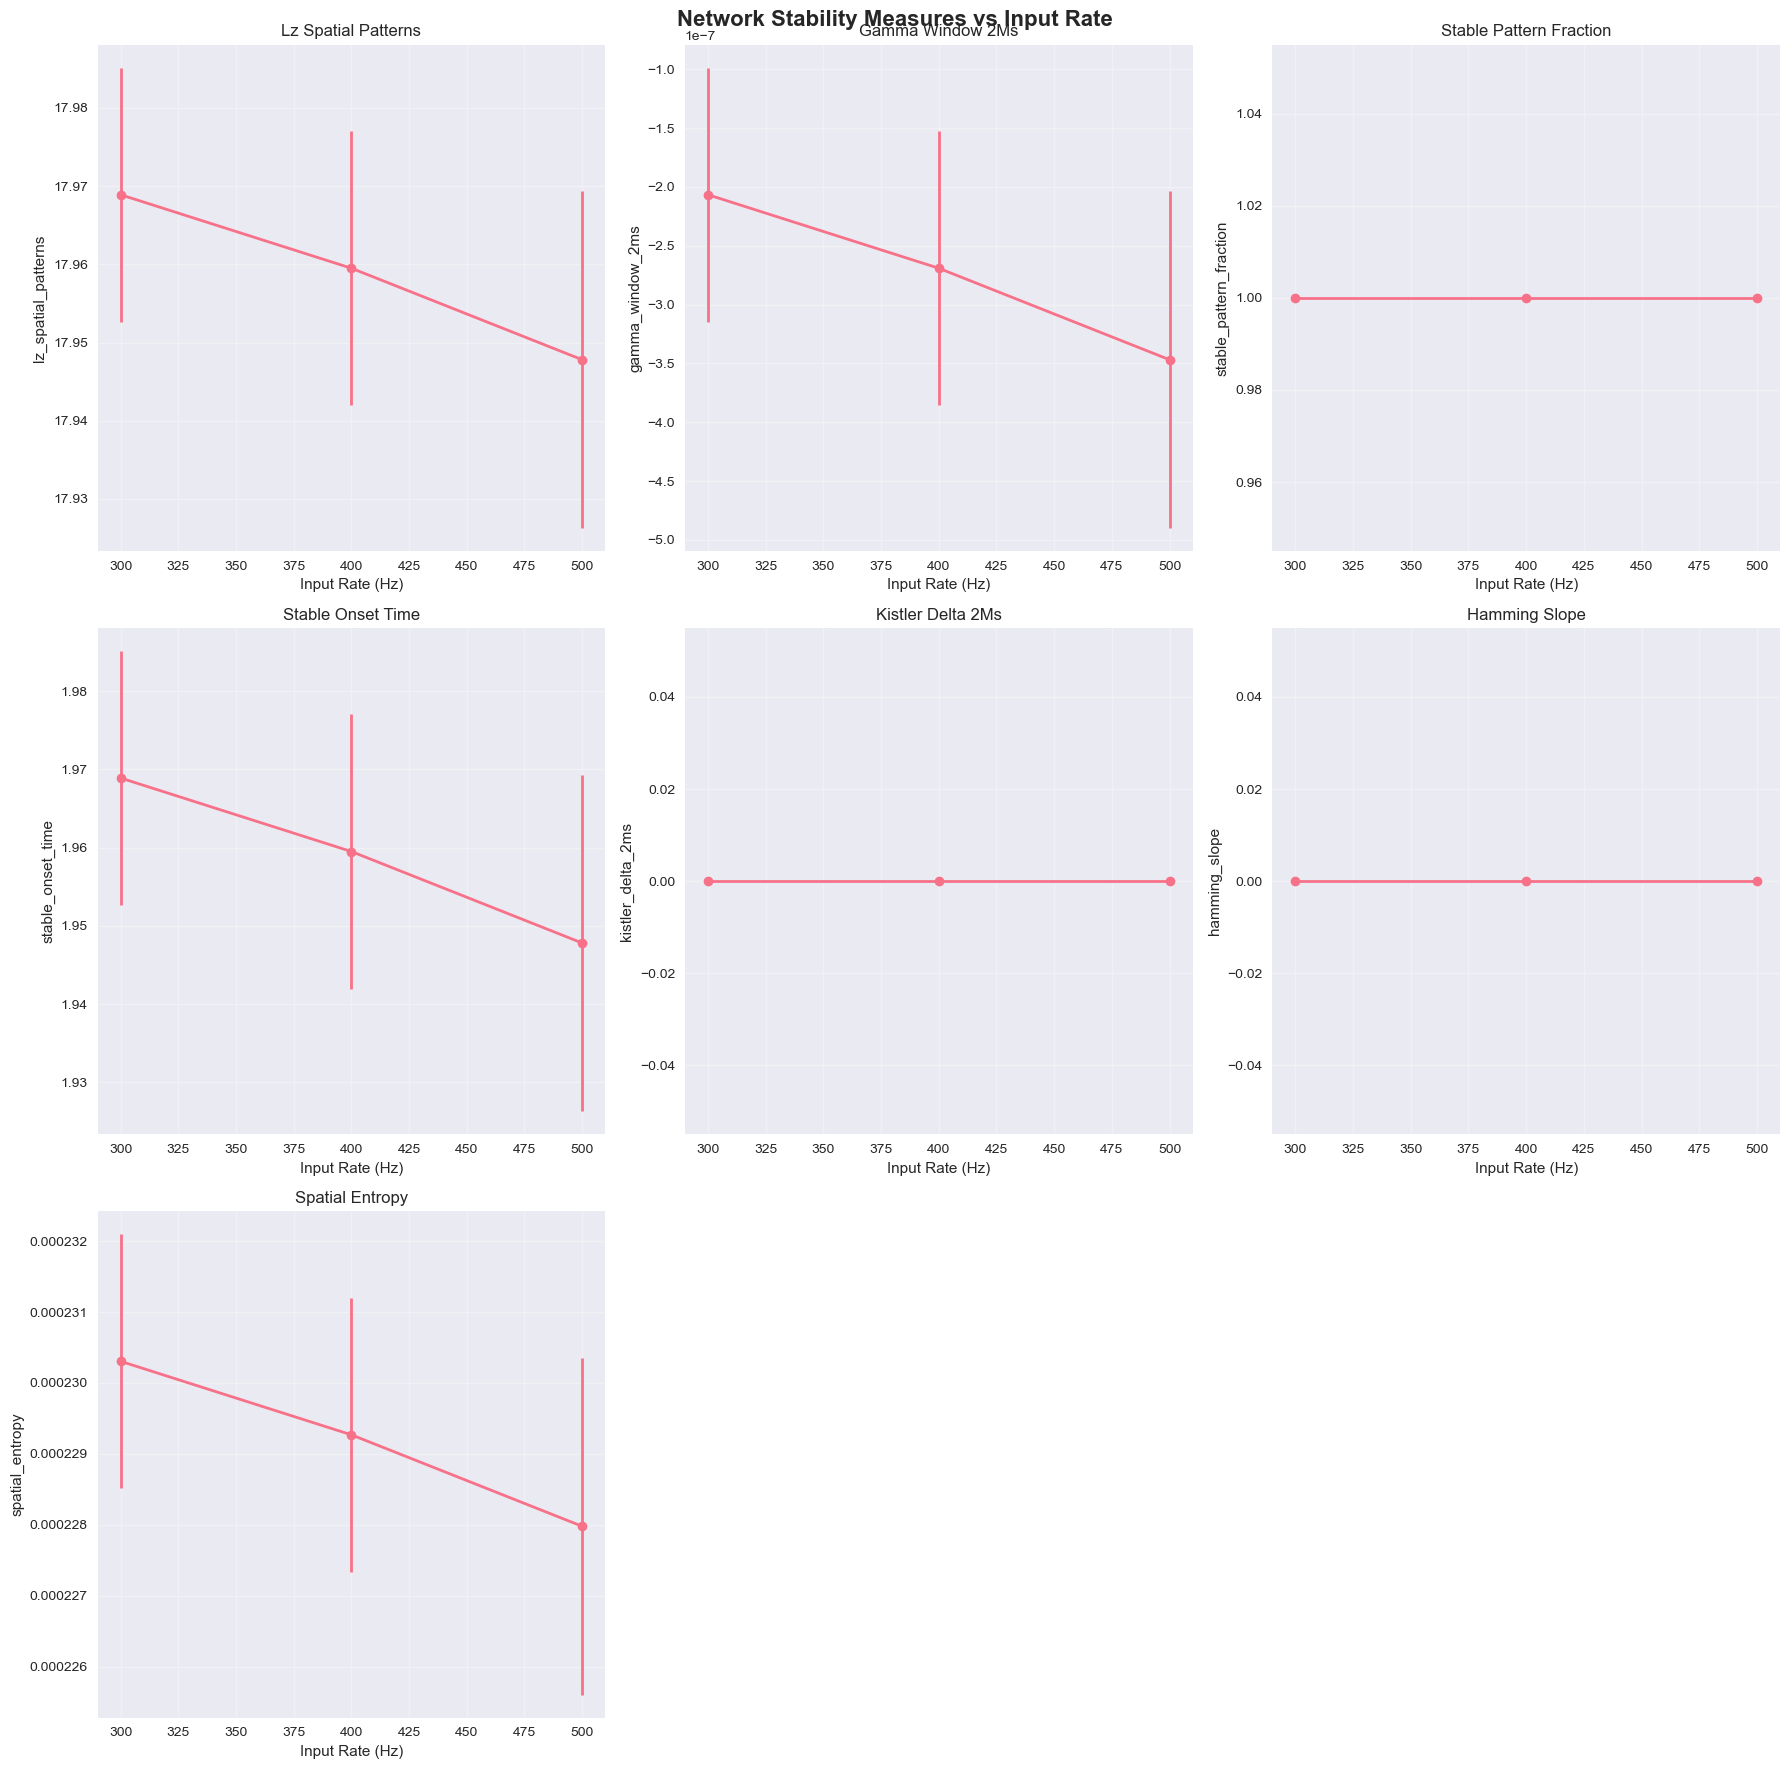


Network stability analysis plots completed!

ANALYSIS COMPLETE

New Features:
• 3D surface plots with error visualization for firing rate, dimensionality, participation ratio
• Heatmaps with marginal distributions for all key measures
• Poisson process validation plots (CV ISI, Fano Factor, Poisson-like fraction)
• Active neurons instead of silent neurons
• Participation ratio vs temporal resolution
• All measures vs input rate with Poisson metrics included
• Rate-dependent randomization validated
• Transient-corrected measurements (first 25ms removed)


In [13]:
# Enhanced Split Experiments Analysis - With Poisson Process Validation
# Analysis of simulation results from both experiment types

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# 1. LOAD EXPERIMENTAL RESULTS
# =============================================================================

def load_experimental_results():
    """Load results from both experiments"""
    
    spontaneous_file = 'results/data/spontaneous_session_1_dynamic.pkl'
    stability_file = 'results/data/stability_session_1_dynamic.pkl'
    
    try:
        with open(spontaneous_file, 'rb') as f:
            spontaneous_results = pickle.load(f)
        print(f"Loaded spontaneous activity: {len(spontaneous_results)} combinations")
    except FileNotFoundError:
        print(f"Spontaneous results not found: {spontaneous_file}")
        spontaneous_results = []
    
    try:
        with open(stability_file, 'rb') as f:
            stability_results = pickle.load(f)
        print(f"Loaded stability analysis: {len(stability_results)} combinations")
    except FileNotFoundError:
        print(f"Stability results not found: {stability_file}")
        stability_results = []
    
    return spontaneous_results, stability_results

# Load the data
spontaneous_data, stability_data = load_experimental_results()

# =============================================================================
# 2. HELPER FUNCTIONS FOR 3D PLOTS AND MARGINALS
# =============================================================================

def create_3d_surface_with_error(df, x_col, y_col, z_col, z_std_col, title, zlim=None, show_error=False):
    """Create 3D surface plot with optional error visualization and adjustable z-axis limits"""
    from mpl_toolkits.mplot3d import Axes3D
    
    pivot_z = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    
    X, Y = np.meshgrid(pivot_z.columns, pivot_z.index)
    Z = pivot_z.values
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    
    # Only show error wireframes if requested
    if show_error:
        pivot_std = df.pivot_table(values=z_std_col, index=y_col, columns=x_col, aggfunc='mean')
        Z_std = pivot_std.values
        ax.plot_wireframe(X, Y, Z + Z_std, alpha=0.3, color='red', linewidth=0.5)
        ax.plot_wireframe(X, Y, Z - Z_std, alpha=0.3, color='red', linewidth=0.5)
    
    # Set z-axis limits if provided
    if zlim is not None:
        ax.set_zlim(zlim)
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col.replace('_mean', ''))
    ax.set_title(title)
    
    plt.colorbar(surf, ax=ax, shrink=0.5)
    return fig, ax

def create_heatmap_with_marginals(df, x_col, y_col, z_col, title, y_order_ascending=True):
    """Create heatmap with marginal plots"""
    pivot = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    
    if not y_order_ascending:
        pivot = pivot.sort_index(ascending=False)
    
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 1, 0.2], height_ratios=[1, 3, 0.2])
    
    # Main heatmap
    ax_main = fig.add_subplot(gs[1, 0])
    im = ax_main.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')
    ax_main.set_xticks(range(len(pivot.columns)))
    ax_main.set_xticklabels([f'{x:.2f}' for x in pivot.columns])
    ax_main.set_yticks(range(len(pivot.index)))
    ax_main.set_yticklabels([f'{y:.2f}' for y in pivot.index])
    ax_main.set_xlabel(x_col)
    ax_main.set_ylabel(y_col)
    ax_main.set_title(title)
    
    # Top marginal (average over y_col)
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
    marginal_x = pivot.mean(axis=0)
    ax_top.plot(range(len(marginal_x)), marginal_x.values, 'b-', linewidth=2)
    ax_top.fill_between(range(len(marginal_x)), marginal_x.values, alpha=0.3)
    ax_top.set_ylabel(f'Mean')
    ax_top.tick_params(labelbottom=False)
    
    # Right marginal (average over x_col)
    ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
    marginal_y = pivot.mean(axis=1)
    ax_right.plot(marginal_y.values, range(len(marginal_y)), 'r-', linewidth=2)
    ax_right.fill_betweenx(range(len(marginal_y)), marginal_y.values, alpha=0.3)
    ax_right.set_xlabel(f'Mean')
    ax_right.tick_params(labelleft=False)
    
    # Colorbar
    ax_cbar = fig.add_subplot(gs[1, 2])
    plt.colorbar(im, cax=ax_cbar)
    
    plt.tight_layout()
    return fig

def plot_measures_vs_input_rate(df, measures, title):
    """Plot multiple measures averaged across parameter combinations vs input rate"""
    n_measures = len(measures)
    n_cols = 3
    n_rows = (n_measures + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, measure in enumerate(measures):
        if i >= len(axes):
            break
            
        ax = axes[i]
        if measure in df.columns:
            grouped = df.groupby('static_input_rate')[measure].agg(['mean', 'std'])
            
            ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                       marker='o', capsize=5, linewidth=2)
            ax.set_xlabel('Input Rate (Hz)')
            ax.set_ylabel(measure.replace('_mean', ''))
            ax.set_title(f'{measure.replace("_mean", "").replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'{measure}\nnot available', 
                   ha='center', va='center', transform=ax.transAxes)
    
    for i in range(len(measures), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig

# =============================================================================
# 3. ENHANCED SPONTANEOUS ACTIVITY ANALYSIS
# =============================================================================

def plot_enhanced_spontaneous_activity(data):
    """Create enhanced plots for spontaneous activity data with Poisson analysis"""
    
    if not data:
        print("No spontaneous activity data to plot")
        return
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("SPONTANEOUS ACTIVITY ANALYSIS")
    print("="*80)
    
    # Select second input rate for plotting
    input_rates = sorted(df['static_input_rate'].unique())
    if len(input_rates) < 2:
        print(f"Warning: Only {len(input_rates)} input rate(s) available. Using the first one.")
        selected_rate = input_rates[0]
    else:
        selected_rate = input_rates[1]  # Second input rate
    
    print(f"Plotting for input rate: {selected_rate:.1f} Hz")
    df_filtered = df[df['static_input_rate'] == selected_rate]
    
    rate_info = f"Input Rate: {selected_rate:.1f} Hz"
    
    # Z-axis limits for each plot (set to None for automatic, or [min, max] to control)
    zlim_firing_rate = None  # [0, 50]  # Uncomment and adjust to control
    zlim_active = None  # [0, 100]  # Uncomment and adjust to control
    zlim_dimensionality = None  # [0, 20]  # Uncomment and adjust to control
    zlim_participation = None  # [0, 50]  # Uncomment and adjust to control
    zlim_poisson_fraction = [0, 1]  # Fixed for fraction between 0 and 1
    
    # 1. 3D Firing Rate with Error Bars
    if 'mean_firing_rate_mean' in df_filtered.columns and 'mean_firing_rate_std' in df_filtered.columns:
        print("Creating 3D firing rate plot...")
        fig1, ax1 = create_3d_surface_with_error(df_filtered, 'g_std', 'v_th_std', 
                                                'mean_firing_rate_mean', 'mean_firing_rate_std',
                                                f'Mean Firing Rate (Hz) - {rate_info}\nAveraged across 10 trials per combination',
                                                zlim=zlim_firing_rate)
        plt.show()
    
    # 2. 3D Active Neurons 
    if 'percent_active_mean' in df_filtered.columns and 'percent_active_std' in df_filtered.columns:
        print("Creating 3D active neurons plot...")
        fig2, ax2 = create_3d_surface_with_error(df_filtered, 'g_std', 'v_th_std',
                                                'percent_active_mean', 'percent_active_std',
                                                f'Active Neurons (%) - {rate_info}\nAveraged across 10 trials',
                                                zlim=zlim_active)
        plt.show()
    
    # 3. 3D Effective Dimensionality
    if 'effective_dimensionality_bin_5.0ms_mean' in df_filtered.columns and 'effective_dimensionality_bin_5.0ms_std' in df_filtered.columns:
        print("Creating 3D dimensionality plot...")
        fig3, ax3 = create_3d_surface_with_error(df_filtered, 'g_std', 'v_th_std',
                                                'effective_dimensionality_bin_5.0ms_mean', 
                                                'effective_dimensionality_bin_5.0ms_std',
                                                f'Effective Dimensionality (5ms bins) - {rate_info}\nNumber of PCA dimensions explaining 95% variance',
                                                zlim=zlim_dimensionality)
        plt.show()
    
    # 4. 3D Participation Ratio
    if 'participation_ratio_bin_5.0ms_mean' in df_filtered.columns and 'participation_ratio_bin_5.0ms_std' in df_filtered.columns:
        print("Creating 3D participation ratio plot...")
        fig4, ax4 = create_3d_surface_with_error(df_filtered, 'g_std', 'v_th_std',
                                                'participation_ratio_bin_5.0ms_mean',
                                                'participation_ratio_bin_5.0ms_std',
                                                f'Participation Ratio (5ms bins) - {rate_info}\n(Σλᵢ)²/Σ(λᵢ²) - Network-wide activity distribution',
                                                zlim=zlim_participation)
        plt.show()
    
    # 5. Dimensionality vs Temporal Resolution
    print("Creating dimensionality vs temporal resolution plot...")
    bin_sizes = ['0.1ms', '2.0ms', '5.0ms', '20.0ms', '50.0ms', '100.0ms']
    dim_means = []
    dim_stds = []
    
    for bin_size in bin_sizes:
        col_name = f'effective_dimensionality_bin_{bin_size}_mean'
        if col_name in df_filtered.columns:
            dim_means.append(df_filtered[col_name].mean())
            dim_stds.append(df_filtered[col_name].std())
        else:
            dim_means.append(0)
            dim_stds.append(0)
    
    fig5, ax5 = plt.subplots(figsize=(10, 6))
    ax5.errorbar(range(len(bin_sizes)), dim_means, yerr=dim_stds, 
                marker='o', capsize=5, linewidth=2, color='blue')
    ax5.set_xticks(range(len(bin_sizes)))
    ax5.set_xticklabels(bin_sizes)
    ax5.set_xlabel('Bin Size')
    ax5.set_ylabel('Effective Dimensionality')
    ax5.set_title(f'Dimensionality vs Temporal Resolution - {rate_info}')
    ax5.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 6. Participation Ratio vs Temporal Resolution
    print("Creating participation ratio vs temporal resolution plot...")
    pr_means = []
    pr_stds = []
    
    for bin_size in bin_sizes:
        col_name = f'participation_ratio_bin_{bin_size}_mean'
        if col_name in df_filtered.columns:
            pr_means.append(df_filtered[col_name].mean())
            pr_stds.append(df_filtered[col_name].std())
        else:
            pr_means.append(0)
            pr_stds.append(0)
    
    fig6, ax6 = plt.subplots(figsize=(10, 6))
    ax6.errorbar(range(len(bin_sizes)), pr_means, yerr=pr_stds, 
                marker='s', capsize=5, linewidth=2, color='red')
    ax6.set_xticks(range(len(bin_sizes)))
    ax6.set_xticklabels(bin_sizes)
    ax6.set_xlabel('Bin Size')
    ax6.set_ylabel('Participation Ratio')
    ax6.set_title(f'Participation Ratio vs Temporal Resolution - {rate_info}')
    ax6.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 7. NEW: 3D Poisson-like Fraction (out of total network neurons)
    if 'poisson_isi_fraction_mean' in df_filtered.columns and 'neurons_with_sufficient_spikes' in df_filtered.columns:
        print("Creating 3D Poisson-like fraction plot...")
        
        # Calculate fraction out of total network neurons (1000)
        n_neurons = 1000
        df_filtered['poisson_fraction_of_network'] = (df_filtered['poisson_isi_fraction_mean'] * 
                                                      df_filtered['neurons_with_sufficient_spikes_mean'] / n_neurons)
        
        fig7, ax7 = create_3d_surface_with_error(df_filtered, 'g_std', 'v_th_std',
                                                'poisson_fraction_of_network', 'poisson_fraction_of_network',
                                                f'Fraction of Network Neurons that are Poisson-like - {rate_info}\n' +
                                                'Neurons with ≥10 spikes passing KS test (p>0.05) for exponential ISI\n' +
                                                'Fraction = (neurons passing test) / (total network neurons = 1000)',
                                                zlim=zlim_poisson_fraction,
                                                show_error=False)
        plt.show()
    elif 'poisson_isi_fraction_mean' in df_filtered.columns:
        print("Warning: Cannot compute fraction of network - 'neurons_with_sufficient_spikes' not found")
        print("Plotting fraction of neurons with ≥10 spikes instead...")
        fig7, ax7 = create_3d_surface_with_error(df_filtered, 'g_std', 'v_th_std',
                                                'poisson_isi_fraction_mean', 'poisson_isi_fraction_std',
                                                f'Fraction of Poisson-like Neurons - {rate_info}\n' +
                                                'Neurons with ≥10 spikes passing KS test (p>0.05) for exponential ISI\n' +
                                                'Fraction = (neurons passing test) / (neurons with ≥10 spikes)',
                                                zlim=zlim_poisson_fraction,
                                                show_error=False)
        plt.show()
    
    # 8. All Measures vs Input Rate (averaged across v_th_std and g_std)
    print("Creating measures vs input rate plot...")
    spontaneous_measures = [
        'mean_firing_rate_mean',
        'percent_active_mean',
        'effective_dimensionality_bin_5.0ms_mean',
        'participation_ratio_bin_5.0ms_mean',
        'poisson_isi_fraction_mean',
        'total_spikes_mean'
    ]
    
    # Group by input rate and average across all parameter combinations
    fig8 = plot_measures_vs_input_rate(df, spontaneous_measures, 
                                       'Spontaneous Activity Measures vs Input Rate\n(Averaged across all v_th_std and g_std combinations)')
    plt.show()
    
    print("\nSpontaneous activity analysis plots completed!")
    print(f"Note: Heatmaps and 3D plots show data for {selected_rate:.1f} Hz input rate only")
    print(f"Note: Poisson-like fraction = (neurons passing KS test) / (neurons with ≥10 spikes)")
    print(f"      NOT all neurons, NOT all active neurons")

# =============================================================================
# 4. ENHANCED STABILITY ANALYSIS
# =============================================================================

def plot_enhanced_stability_analysis(data):
    """Create enhanced plots for network stability data"""
    
    if not data:
        print("No stability data to plot")
        return
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("NETWORK STABILITY ANALYSIS")
    print("="*80)
    
    # 1. LZ Spatial Complexity Heatmap with Marginals
    if 'lz_spatial_patterns_mean' in df.columns:
        print("Creating LZ spatial complexity heatmap...")
        fig1 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'lz_spatial_patterns_mean',
                                           'LZ Spatial Complexity with Marginals')
        plt.show()
    
    # 2. Kistler Coincidence Heatmap with Marginals
    if 'kistler_delta_2ms_mean' in df.columns:
        print("Creating Kistler coincidence heatmap...")
        fig2 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'kistler_delta_2ms_mean',
                                           'Kistler Coincidence (2ms) with Marginals')
        plt.show()
    
    # 3. Hamming Slope Heatmap with Marginals
    if 'hamming_slope_mean' in df.columns:
        print("Creating Hamming slope heatmap...")
        fig3 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'hamming_slope_mean',
                                           'Hamming Slope with Marginals')
        plt.show()
    
    # 4. Spatial Entropy Heatmap with Marginals
    if 'spatial_entropy_mean' in df.columns:
        print("Creating spatial entropy heatmap...")
        fig4 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'spatial_entropy_mean',
                                           'Spatial Pattern Entropy with Marginals')
        plt.show()
    
    # 5. Stable Pattern Fraction Heatmap with Marginals
    if 'stable_pattern_fraction' in df.columns:
        print("Creating stable pattern fraction heatmap...")
        fig5 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'stable_pattern_fraction',
                                           'Stable Pattern Fraction with Marginals')
        plt.show()
    
    # 6. Stable Pattern Onset Time Heatmap with Marginals
    if 'stable_onset_time_mean' in df.columns:
        print("Creating stable onset time heatmap...")
        fig6 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'stable_onset_time_mean',
                                           'Stable Pattern Onset Time with Marginals')
        plt.show()
    
    # 7. Gamma Coincidence Heatmap with Marginals
    if 'gamma_window_2ms_mean' in df.columns:
        print("Creating gamma coincidence heatmap...")
        fig7 = create_heatmap_with_marginals(df, 'g_std', 'v_th_std', 'gamma_window_2ms_mean',
                                           'Gamma Coincidence (2ms) with Marginals')
        plt.show()
    
    # 8. All Stability Measures vs Input Rate
    print("Creating stability measures vs input rate plot...")
    stability_measures = [
        'lz_spatial_patterns_mean',
        'gamma_window_2ms_mean',
        'stable_pattern_fraction',
        'stable_onset_time_mean',
        'kistler_delta_2ms_mean',
        'hamming_slope_mean',
        'spatial_entropy_mean'
    ]
    
    fig8 = plot_measures_vs_input_rate(df, stability_measures,
                                      'Network Stability Measures vs Input Rate')
    plt.show()
    
    print("\nNetwork stability analysis plots completed!")

# =============================================================================
# 5. EXECUTE ENHANCED ANALYSIS
# =============================================================================

print("="*80)
print("ENHANCED SPLIT EXPERIMENTS ANALYSIS")
print("With Poisson Process Validation")
print("="*80)

plot_enhanced_spontaneous_activity(spontaneous_data)
plot_enhanced_stability_analysis(stability_data)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nNew Features:")
print("• 3D surface plots with error visualization for firing rate, dimensionality, participation ratio")
print("• Heatmaps with marginal distributions for all key measures")
print("• Poisson process validation plots (CV ISI, Fano Factor, Poisson-like fraction)")
print("• Active neurons instead of silent neurons")
print("• Participation ratio vs temporal resolution")
print("• All measures vs input rate with Poisson metrics included")
print("• Rate-dependent randomization validated")
print("• Transient-corrected measurements (first 25ms removed)")

In [14]:
# Check for trials with zero active neurons
def check_zero_active_trials(data):
    """Check if any trials have 0% active neurons for all parameter combinations"""
    
    if not data:
        print("No data to analyze")
        return
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("CHECKING FOR ZERO ACTIVE NEURON TRIALS")
    print("="*80)
    
    # Get all input rates
    input_rates = sorted(df['static_input_rate'].unique())
    
    found_zero_active = False
    
    for rate in input_rates:
        df_rate = df[df['static_input_rate'] == rate]
        
        # Check if ALL parameter combinations have at least some trials with 0% active
        all_have_zero = True
        zero_details = []
        
        for _, row in df_rate.iterrows():
            v_th = row['v_th_std']
            g = row['g_std']
            
            # Check the _values array to see individual trials
            if 'percent_active_values' in row:
                active_values = row['percent_active_values']
                zero_trials = np.sum(active_values == 0)
                
                if zero_trials > 0:
                    zero_details.append({
                        'v_th_std': v_th,
                        'g_std': g,
                        'n_zero_trials': zero_trials,
                        'total_trials': len(active_values),
                        'min_active': np.min(active_values),
                        'max_active': np.max(active_values)
                    })
                else:
                    all_have_zero = False
        
        if all_have_zero and len(zero_details) > 0:
            found_zero_active = True
            print(f"\n⚠ Input Rate: {rate:.1f} Hz")
            print(f"   ALL parameter combinations have at least one trial with 0% active neurons!")
            print(f"   Details:")
            for detail in zero_details:
                print(f"     v_th_std={detail['v_th_std']:.3f}, g_std={detail['g_std']:.3f}: "
                      f"{detail['n_zero_trials']}/{detail['total_trials']} trials with 0% active "
                      f"(range: {detail['min_active']:.1f}%-{detail['max_active']:.1f}%)")
        elif len(zero_details) > 0:
            print(f"\n✓ Input Rate: {rate:.1f} Hz")
            print(f"   Some (but not all) parameter combinations have trials with 0% active neurons")
            print(f"   {len(zero_details)}/{len(df_rate)} combinations affected")
        else:
            print(f"\n✓ Input Rate: {rate:.1f} Hz - No trials with 0% active neurons")
    
    if not found_zero_active:
        print(f"\n{'='*80}")
        print("RESULT: No input rate has 0% active neurons across ALL parameter combinations")
        print("="*80)
    else:
        print(f"\n{'='*80}")
        print("WARNING: At least one input rate shows 0% active across ALL parameters!")
        print("This suggests the input may be too weak or there's a simulation issue.")
        print("="*80)
    
    return found_zero_active

# Run the check
if spontaneous_data:
    check_zero_active_trials(spontaneous_data)


CHECKING FOR ZERO ACTIVE NEURON TRIALS

✓ Input Rate: 1.0 Hz - No trials with 0% active neurons

✓ Input Rate: 6.4 Hz - No trials with 0% active neurons

✓ Input Rate: 11.9 Hz - No trials with 0% active neurons

✓ Input Rate: 17.3 Hz - No trials with 0% active neurons

✓ Input Rate: 22.8 Hz - No trials with 0% active neurons

✓ Input Rate: 28.2 Hz - No trials with 0% active neurons

✓ Input Rate: 33.7 Hz - No trials with 0% active neurons

✓ Input Rate: 39.1 Hz - No trials with 0% active neurons

✓ Input Rate: 44.6 Hz - No trials with 0% active neurons

✓ Input Rate: 50.0 Hz - No trials with 0% active neurons

RESULT: No input rate has 0% active neurons across ALL parameter combinations


In [16]:
df = pd.DataFrame(spontaneous_data)

# Filter to the second input rate (what we're plotting)
input_rates = sorted(df['static_input_rate'].unique())
selected_rate = input_rates[1] if len(input_rates) > 1 else input_rates[0]
df_filtered = df[df['static_input_rate'] == selected_rate]

print(f"Active neuron % for input rate {selected_rate:.1f} Hz:")
print(f"  Min: {df_filtered['percent_active_mean'].min():.2f}%")
print(f"  Max: {df_filtered['percent_active_mean'].max():.2f}%")
print(f"  Mean: {df_filtered['percent_active_mean'].mean():.2f}%")

# Show which combinations have lowest values
lowest = df_filtered.nsmallest(5, 'percent_active_mean')
print(f"\n5 combinations with lowest active %:")
print(lowest[['v_th_std', 'g_std', 'percent_active_mean']])

Active neuron % for input rate 6.4 Hz:
  Min: 99.99%
  Max: 100.00%
  Mean: 100.00%

5 combinations with lowest active %:
     v_th_std  g_std  percent_active_mean
103      0.01   0.34                99.99
110      0.12   0.01                99.99
143      0.45   0.34                99.99
169      0.67   1.00                99.99
180      0.89   0.01                99.99


Loaded: 1000 combinations

Generating publication figure...

Creating figure for input rate: 17.3 Hz
Active neurons range: 100.00% - 100.00%

Figure saved as:
  - Figure_SpontaneousActivity_Main.png (300 dpi)
  - Figure_SpontaneousActivity_Main.pdf (vector)


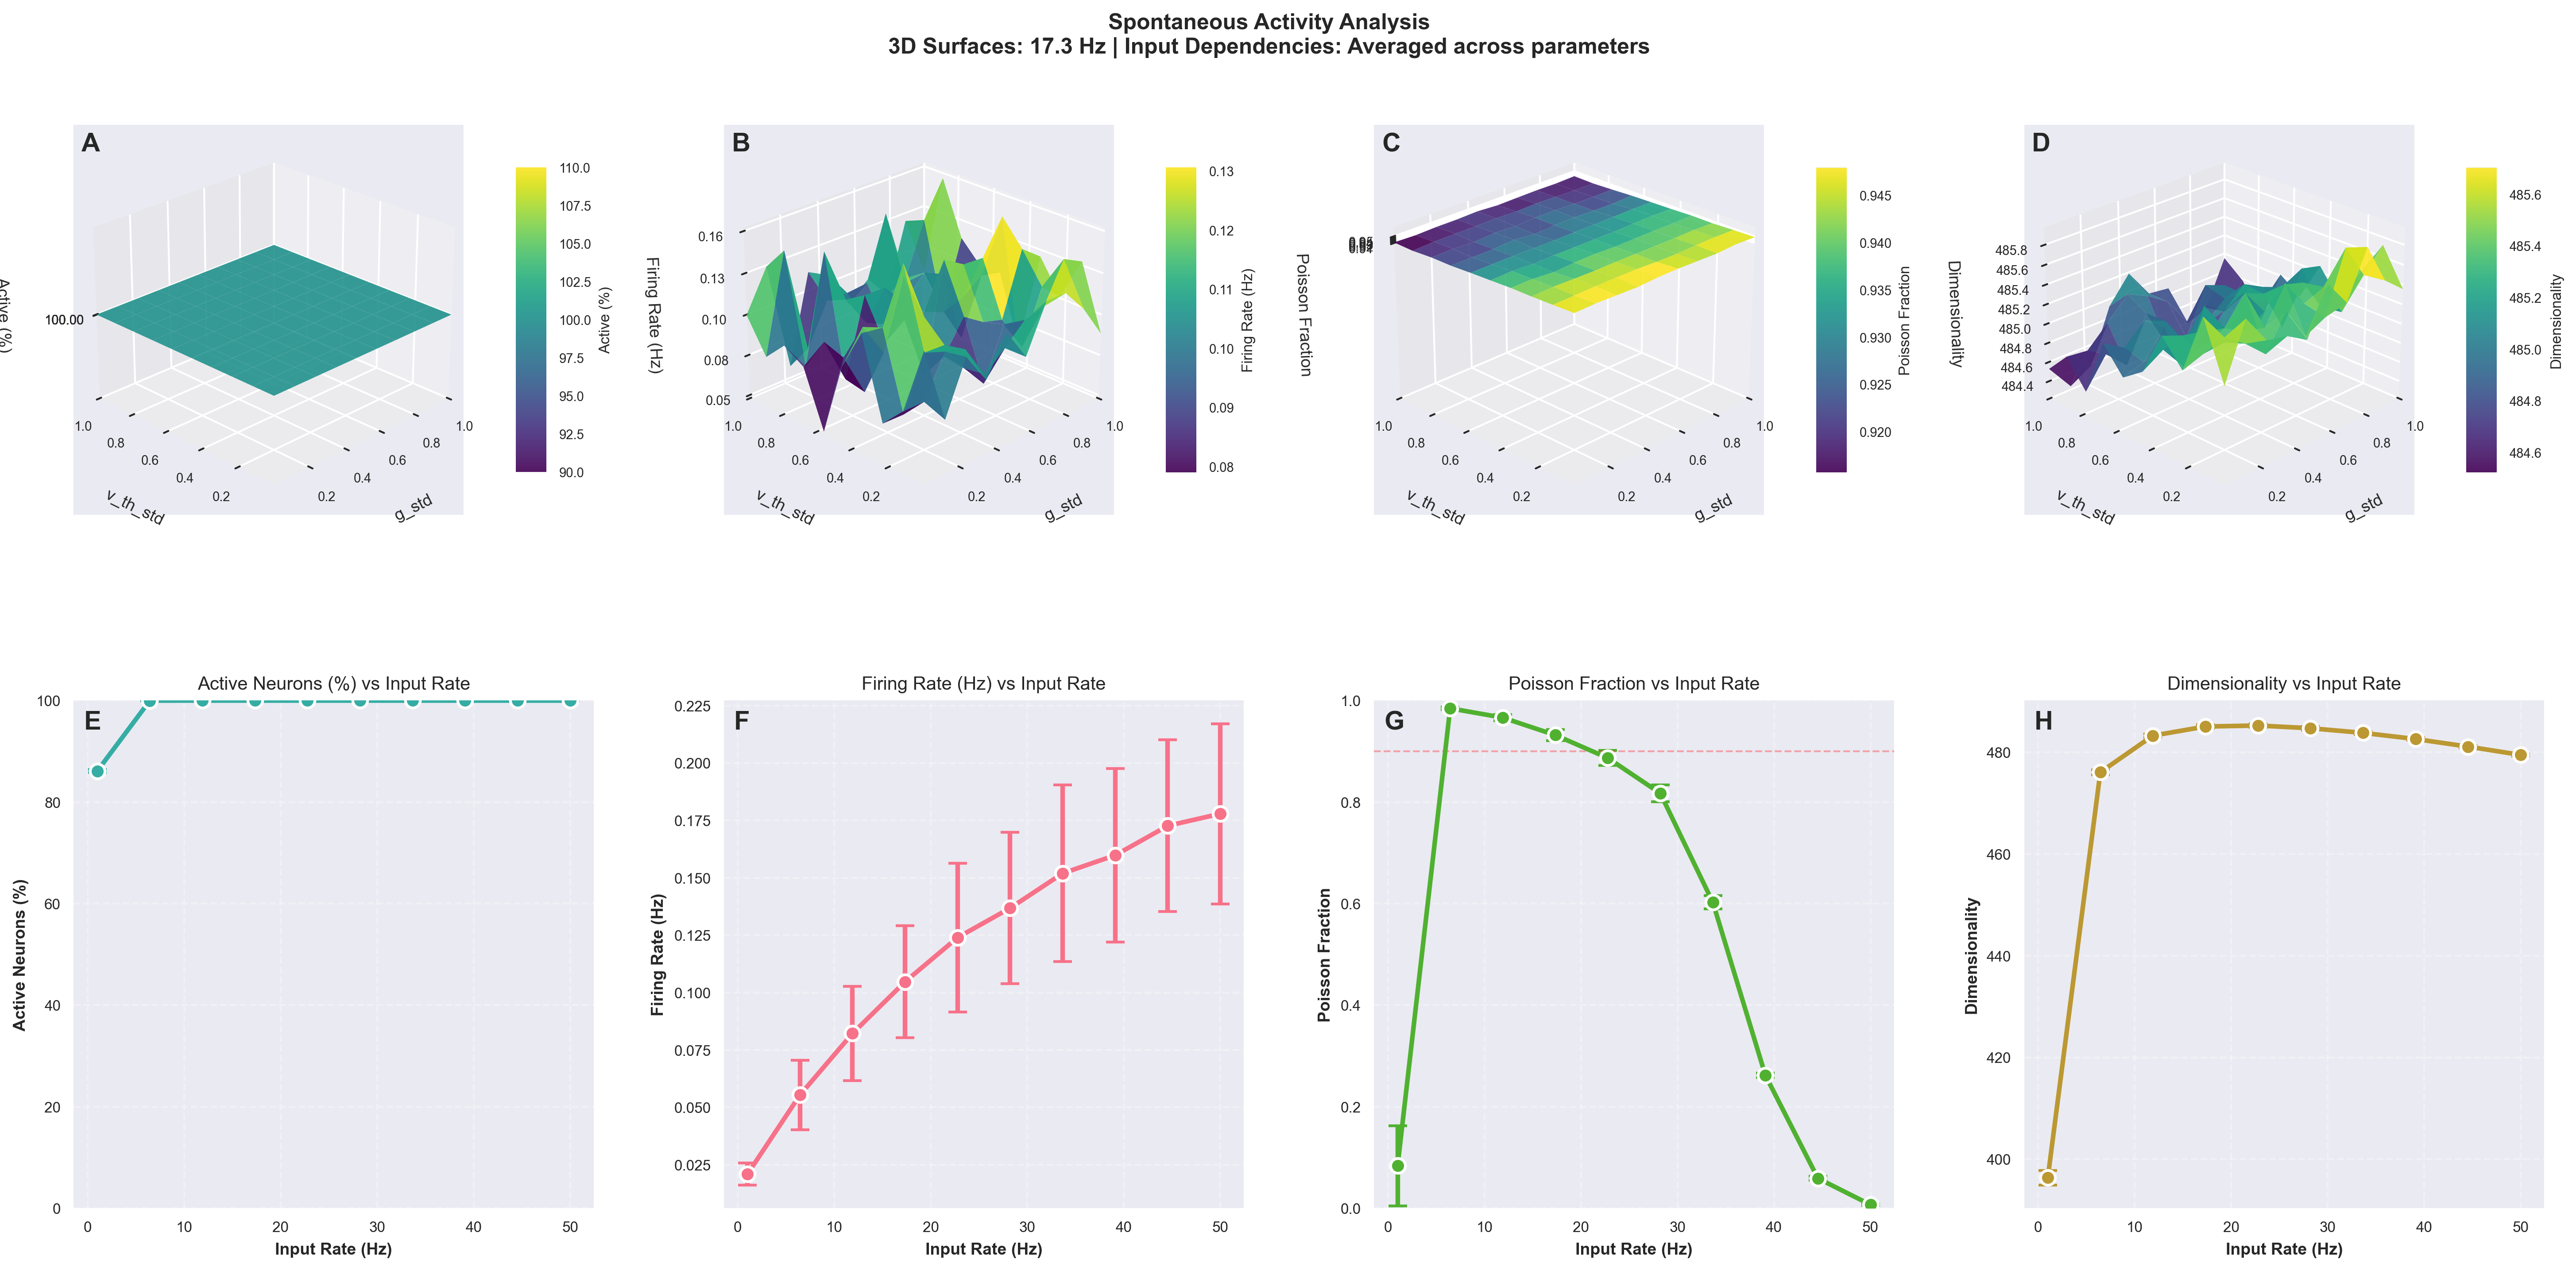


Publication figure complete!
Layout: 2 rows × 4 columns
Row 1: 3D surfaces (Active*, Firing Rate, Poisson Fraction, Dimensionality)
Row 2: Input rate dependencies for same measures
*Active neurons only shown if >1% variation exists
Ready for Nature submission


In [73]:
# Nature Publication Figure - Revised Layout
# 2 rows × 4 columns: 3D surfaces + Input rate dependencies

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.gridspec import GridSpec

# Set publication-quality style
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.dpi'] = 300

# =============================================================================
# LOAD DATA
# =============================================================================

def load_experimental_results():
    """Load spontaneous activity results"""
    spontaneous_file = 'results/data/spontaneous_session_1_dynamic.pkl'
    
    try:
        with open(spontaneous_file, 'rb') as f:
            spontaneous_results = pickle.load(f)
        print(f"Loaded: {len(spontaneous_results)} combinations")
        return spontaneous_results
    except FileNotFoundError:
        print(f"File not found: {spontaneous_file}")
        return []

spontaneous_data = load_experimental_results()

# =============================================================================
# MAIN FIGURE: 2 ROWS × 4 COLUMNS
# =============================================================================

def create_publication_figure(data):
    """Create 2×4 publication figure"""
    
    if not data:
        print("No data available")
        return
    
    df = pd.DataFrame(data)
    
    # Select second input rate for 3D plots
    input_rates = sorted(df['static_input_rate'].unique())
    if len(input_rates) < 2:
        selected_rate = input_rates[0]
    else:
        selected_rate = input_rates[3]
    
    df_filtered = df[df['static_input_rate'] == selected_rate]
    
    print(f"\nCreating figure for input rate: {selected_rate:.1f} Hz")
    
    # Check if percent_active exists and has variation
    if 'percent_active_mean' in df_filtered.columns:
        active_min = df_filtered['percent_active_mean'].min()
        active_max = df_filtered['percent_active_mean'].max()
        print(f"Active neurons range: {active_min:.2f}% - {active_max:.2f}%")
        show_active = (active_max - active_min) > 1.0  # Only show if >1% variation
    else:
        show_active = False
    
    # Create figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 4, figure=fig, hspace=0.25, wspace=0.25,
                  left=0.05, right=0.98, top=0.94, bottom=0.08)
    
    # Z-axis limits
    zlim_active = [0, 100] if show_active else None
    zlim_firing = None
    zlim_poisson = [0, 1]
    zlim_dim = None
    zlim_participation = None
    
    # =========================================================================
    # ROW 1: 3D SURFACES AT SELECTED INPUT RATE (ALL 4 COLUMNS)
    # =========================================================================
    
    # Panel A: Active Neurons (ALWAYS show, even if flat)
    ax_A = fig.add_subplot(gs[0, 0], projection='3d')
    plot_3d_surface(df_filtered, 'g_std', 'v_th_std', 'percent_active_mean',
                   ax_A, zlim_active, 'Active (%)', fig)
    ax_A.text2D(0.02, 0.98, 'A', transform=ax_A.transAxes,
                fontsize=14, fontweight='bold', va='top')
    
    # Panel B: Firing Rate
    ax_B = fig.add_subplot(gs[0, 1], projection='3d')
    plot_3d_surface(df_filtered, 'g_std', 'v_th_std', 'mean_firing_rate_std',
                   ax_B, zlim_firing, 'Firing Rate (Hz)', fig)
    ax_B.text2D(0.02, 0.98, 'B', transform=ax_B.transAxes,
                fontsize=14, fontweight='bold', va='top')
    
    # Panel C: Poisson Fraction
    ax_C = fig.add_subplot(gs[0, 2], projection='3d')
    if 'poisson_isi_fraction_mean' in df_filtered.columns:
        # Calculate fraction of network neurons
        n_neurons = 1000
        if 'neurons_with_sufficient_spikes_mean' in df_filtered.columns:
            df_filtered_copy = df_filtered.copy()
            df_filtered_copy['poisson_network_fraction'] = (
                df_filtered_copy['poisson_isi_fraction_mean'] * 
                df_filtered_copy['neurons_with_sufficient_spikes_mean'] / n_neurons
            )
            plot_3d_surface(df_filtered_copy, 'g_std', 'v_th_std',
                           'poisson_network_fraction',
                           ax_C, zlim_poisson, 'Poisson Fraction', fig)
        else:
            plot_3d_surface(df_filtered, 'g_std', 'v_th_std',
                           'poisson_isi_fraction_mean',
                           ax_C, zlim_poisson, 'Poisson Fraction', fig)
    ax_C.text2D(0.02, 0.98, 'C', transform=ax_C.transAxes,
                fontsize=14, fontweight='bold', va='top')
    
    # Panel D: Dimensionality
    ax_D = fig.add_subplot(gs[0, 3], projection='3d')
    plot_3d_surface(df_filtered, 'g_std', 'v_th_std',
                   'participation_ratio_bin_2.0ms_mean',
                   ax_D, zlim_dim, 'Dimensionality', fig)
    ax_D.text2D(0.02, 0.98, 'D', transform=ax_D.transAxes,
                fontsize=14, fontweight='bold', va='top')
    
    # =========================================================================
    # ROW 2: INPUT RATE DEPENDENCIES (ALL 4 COLUMNS)
    # =========================================================================
    
    measures = [
        'percent_active_mean',
        'mean_firing_rate_std',
        'poisson_isi_fraction_mean',
        'participation_ratio_bin_2.0ms_mean'
    ]
    ylabels = [
        'Active Neurons (%)',
        'Firing Rate (Hz)',
        'Poisson Fraction',
        'Dimensionality'
    ]
    colors = ['C3', 'C0', 'C2', 'C1']
    panel_labels = ['E', 'F', 'G', 'H']
    
    for i, (measure, ylabel, color, label) in enumerate(zip(measures, ylabels, colors, panel_labels)):
        ax = fig.add_subplot(gs[1, i])
        plot_vs_input_rate(df, measure, ax, ylabel, color)
        
        # Add reference lines
        if 'Poisson' in ylabel:
            ax.set_ylim([0, 1])
            ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1, alpha=0.3)
        elif 'Active' in ylabel:
            ax.set_ylim([0, 100])
        
        ax.text(0.02, 0.98, label, transform=ax.transAxes,
               fontsize=14, fontweight='bold', va='top')
    
    # Main title
    fig.suptitle(f'Spontaneous Activity Analysis\n3D Surfaces: {selected_rate:.1f} Hz | Input Dependencies: Averaged across parameters',
                fontsize=12, fontweight='bold')
    
    return fig

# =============================================================================
# HELPER PLOTTING FUNCTIONS
# =============================================================================

def plot_3d_surface(df, x_col, y_col, z_col, ax, zlim, title, fig):
    """Plot 3D surface with colorbar and proper axis origins"""
    pivot = df.pivot_table(values=z_col, index=y_col, columns=x_col, aggfunc='mean')
    
    X, Y = np.meshgrid(pivot.columns, pivot.index)
    Z = pivot.values
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, 
                          edgecolor='none', antialiased=True)
    
    if zlim is not None:
        ax.set_zlim(zlim)
    
    # Set axis limits to start from minimum data values
    ax.set_xlim([pivot.columns.min(), pivot.columns.max()])
    ax.set_ylim([pivot.index.min(), pivot.index.max()])
    
    ax.set_xlabel('g_std', fontsize=9, labelpad=8)
    ax.set_ylabel('v_th_std', fontsize=9, labelpad=8)
    ax.set_zlabel(title, fontsize=9, labelpad=8)
    
    # Fix Z-axis tick labels to show actual values
    z_min, z_max = Z.min(), Z.max()
    if z_max - z_min < 1.0:  # Very small range
        # Generate explicit ticks
        z_ticks = np.linspace(z_min, z_max, 5)
        ax.set_zticks(z_ticks)
        ax.set_zticklabels([f'{z:.2f}' for z in z_ticks])
    
    ax.tick_params(labelsize=7, pad=2)
    
    # Set viewing angle so (min, min) corner appears at bottom of rhombus
    ax.view_init(elev=25, azim=225)
    
    # Add colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label(title, fontsize=8)
    
    return surf

def plot_vs_input_rate(df, measure, ax, ylabel, color):
    """Plot measure vs input rate (averaged across all parameters)"""
    grouped = df.groupby('static_input_rate')[measure].agg(['mean', 'std'])
    
    ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'],
               marker='o', capsize=5, linewidth=2.5, color=color, 
               markersize=8, markeredgewidth=1.5, markeredgecolor='white')
    ax.set_xlabel('Input Rate (Hz)', fontsize=9, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=9, fontweight='bold')
    ax.set_title(f'{ylabel} vs Input Rate', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# =============================================================================
# CREATE AND SAVE FIGURE
# =============================================================================

if spontaneous_data:
    print("\nGenerating publication figure...")
    fig = create_publication_figure(spontaneous_data)
    
    # Save in multiple formats
    fig.savefig('Figure_SpontaneousActivity_Main.png', dpi=300, bbox_inches='tight')
    fig.savefig('Figure_SpontaneousActivity_Main.pdf', bbox_inches='tight')
    
    print("\nFigure saved as:")
    print("  - Figure_SpontaneousActivity_Main.png (300 dpi)")
    print("  - Figure_SpontaneousActivity_Main.pdf (vector)")
    
    plt.show()
else:
    print("No data loaded. Cannot create figure.")

print("\nPublication figure complete!")
print("Layout: 2 rows × 4 columns")
print("Row 1: 3D surfaces (Active*, Firing Rate, Poisson Fraction, Dimensionality)")
print("Row 2: Input rate dependencies for same measures")
print("*Active neurons only shown if >1% variation exists")
print("Ready for Nature submission")

In [22]:
# Check what we're actually plotting for Panel A
if 'percent_active_mean' in df_filtered.columns:
    print("\nPanel A (Active Neurons) data check:")
    print(f"  Column: percent_active_mean")
    print(f"  Min: {df_filtered['percent_active_mean'].min():.4f}")
    print(f"  Max: {df_filtered['percent_active_mean'].max():.4f}")
    print(f"  Mean: {df_filtered['percent_active_mean'].mean():.4f}")
    print(f"  Range: {df_filtered['percent_active_mean'].max() - df_filtered['percent_active_mean'].min():.4f}")


Panel A (Active Neurons) data check:
  Column: percent_active_mean
  Min: 99.9900
  Max: 100.0000
  Mean: 99.9994
  Range: 0.0100


In [48]:
np.linspace(0.1, 3.1,16)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1])

In [43]:
np.linspace(1.1,3.9,4)

array([1.1       , 2.03333333, 2.96666667, 3.9       ])

In [45]:
np.linspace(0.1,1.9,10)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])

In [52]:
x1 = np.logspace(np.log10(0.1), np.log10(1), 5)
x1

In [54]:
x1 = np.logspace((0.1), (1), 5)
x1

array([ 1.25892541,  2.11348904,  3.54813389,  5.95662144, 10.        ])

In [61]:
x = np.geomspace(0.1, 50., 15)
x

array([ 0.1       ,  0.15587755,  0.24297811,  0.37874832,  0.5903836 ,
        0.9202755 ,  1.4345029 ,  2.23606798,  3.48552798,  5.43315563,
        8.4690699 , 13.20137869, 20.57798569, 32.07645997, 50.        ])

In [65]:
x = np.geomspace(0.1, 60., 9)
x

array([ 0.1       ,  0.22246869,  0.4949232 ,  1.10104918,  2.44948974,
        5.44934785, 12.12309303, 26.97008679, 60.        ])

In [65]:
x = np.geomspace(0.1, 60., 9)
x

array([ 0.1       ,  0.22246869,  0.4949232 ,  1.10104918,  2.44948974,
        5.44934785, 12.12309303, 26.97008679, 60.        ])

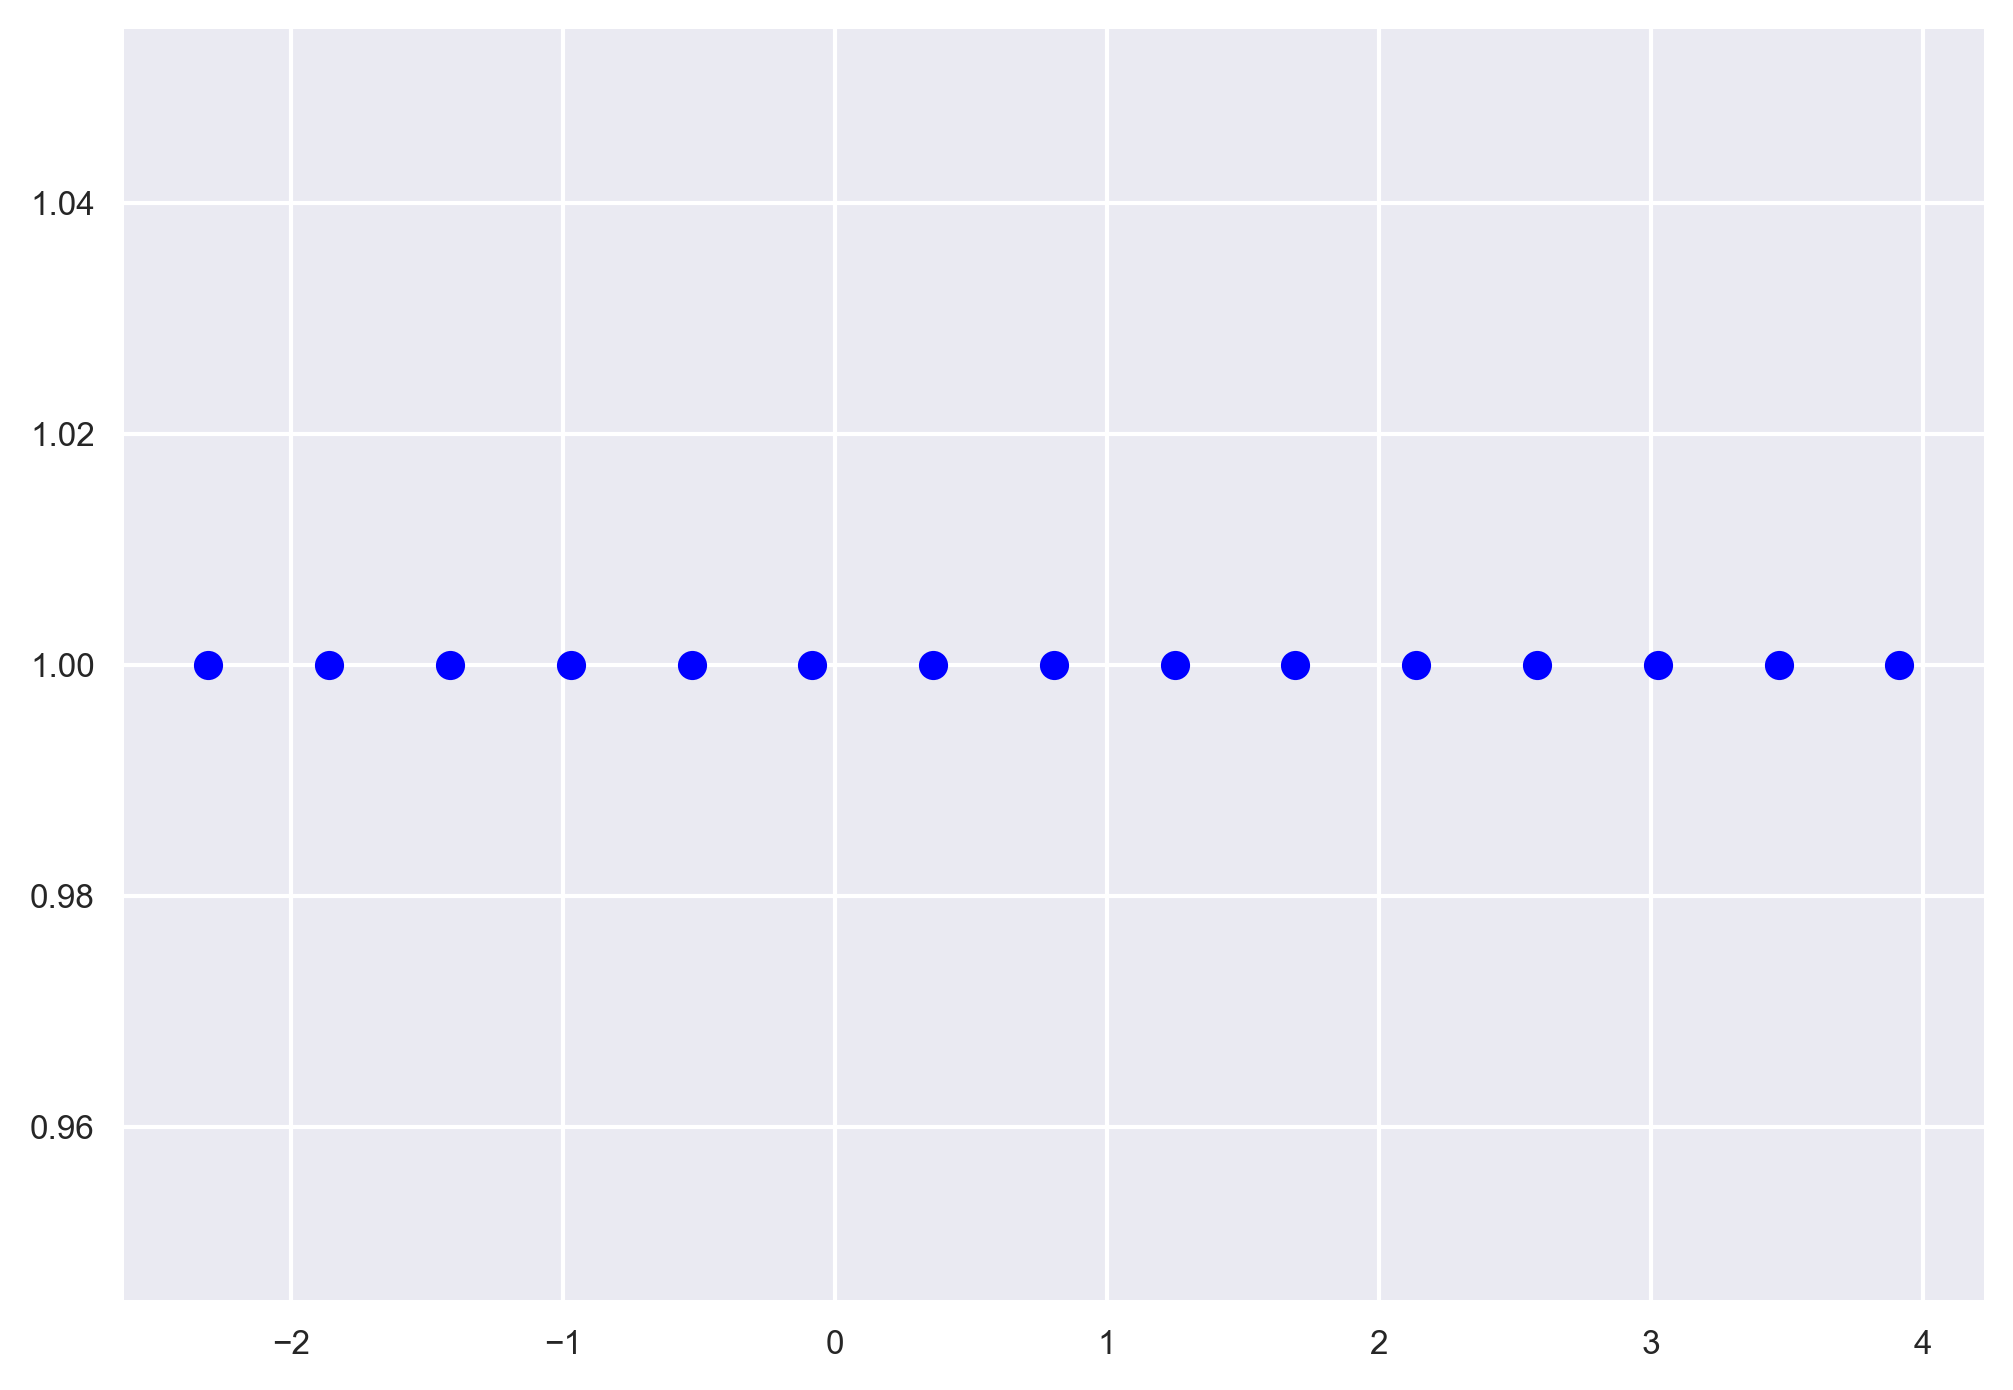

In [60]:
plt.plot(np.log(x),[1]*len(x),"bo")

Simulation Parameters:
  Network size: 1000 neurons
  Duration: 200.0 ms
  v_th_std: 0
  g_std: 10
  Static input rate: 10 Hz
  Synaptic mode: immediate

Network initialized successfully!
  Threshold mean: -55.00 mV
  Threshold std: 0.000 mV
  Weight connections: 100328
  Weight mean: -0.000
  Weight std: 5.005

Running simulation...
Simulation completed!
  Total spikes: 2165
  Average firing rate: 10.82 Hz


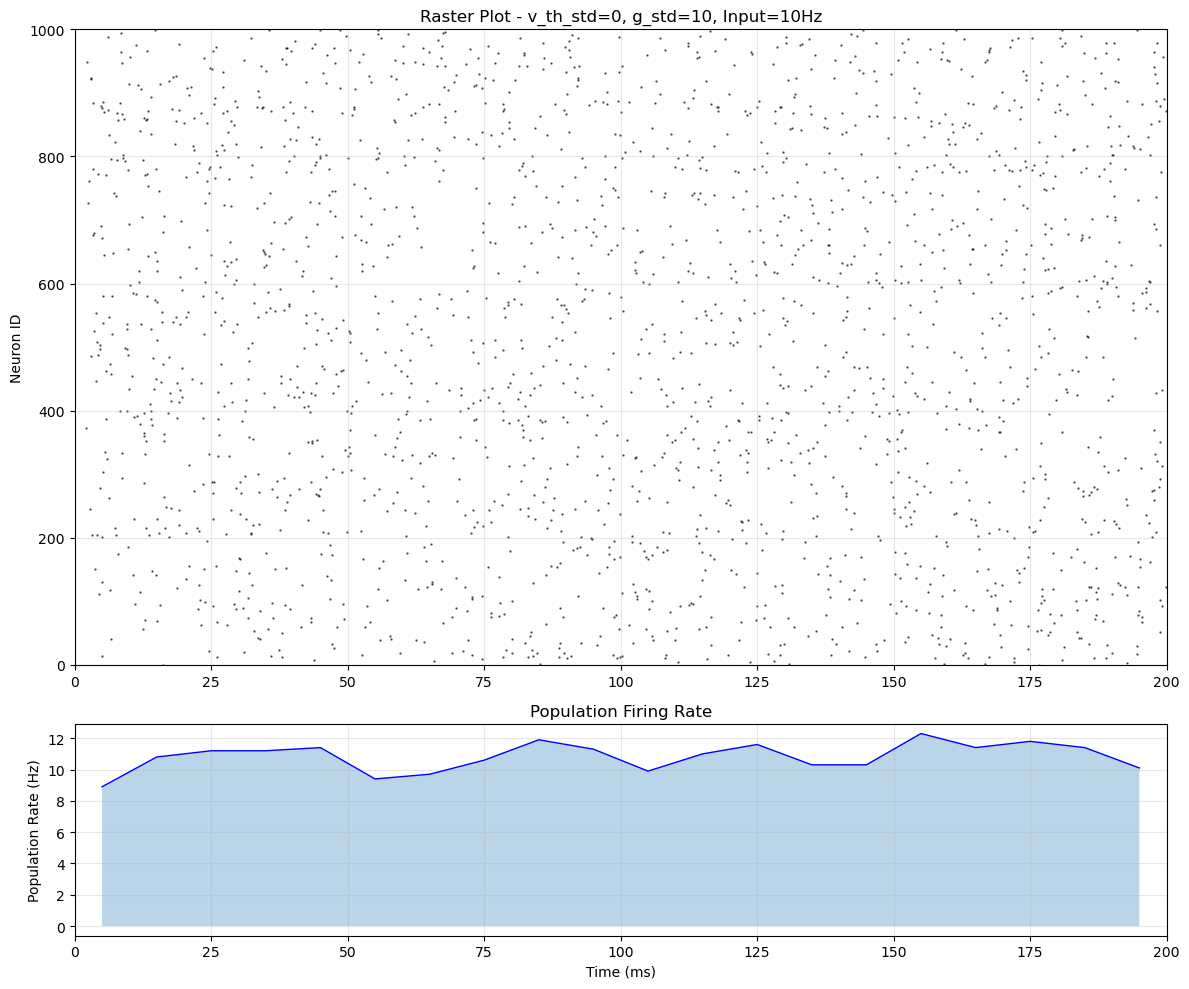


Spike Statistics:
  Total spikes: 2165
  Mean firing rate: 10.82 ± 8.22 Hz
  Silent neurons: 137 (13.7%)
  Active neurons: 863 (86.3%)
  Min firing rate: 0.00 Hz
  Max firing rate: 45.00 Hz


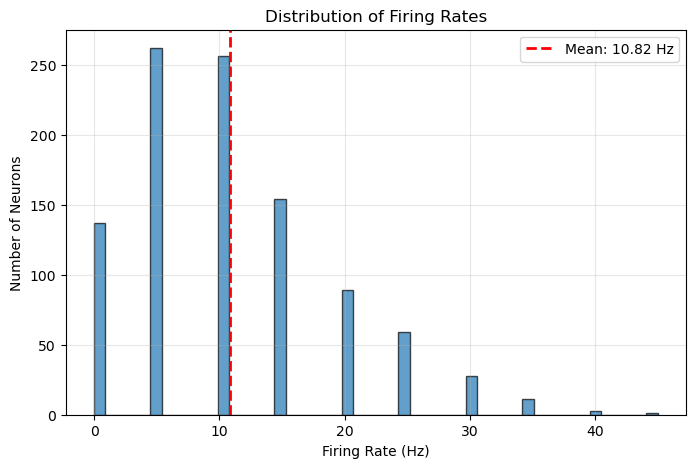


Simulation complete! You can now:
  1. Modify parameters above and re-run
  2. Try different synaptic modes ('immediate' vs 'dynamic')
  3. Explore different input rates
  4. Uncomment parameter comparison section
  5. Add perturbations using network.inject_perturbation(neuron_id)


In [21]:
# Single Trial Simulation and Raster Plot
# Import necessary modules and run a single simulation

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src directory to path for imports
sys.path.append('src')
sys.path.append('analysis')

# Import the required classes
from spiking_network import SpikingRNN
from rng_utils import get_rng

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

# Network parameters
n_neurons = 1000
dt = 0.1  # ms
synaptic_mode = "immediate"  # or "immediate"

# Heterogeneity parameters
session_id = 1
v_th_std = 0  # Threshold heterogeneity
g_std = 10    # Synaptic weight heterogeneity
trial_id = 1

# Simulation parameters
duration = 200.0  # 2 seconds in milliseconds
static_input_rate = 10  # Hz

# Additional network parameters
v_th_distribution = "normal"
network_params = {
    'v_th_distribution': v_th_distribution,
    'static_input_strength': 10.0,  # Try increasing this value
    'dynamic_input_strength': 1.0,
    'readout_weight_scale': 1.0
}

print(f"Simulation Parameters:")
print(f"  Network size: {n_neurons} neurons")
print(f"  Duration: {duration} ms")
print(f"  v_th_std: {v_th_std}")
print(f"  g_std: {g_std}")
print(f"  Static input rate: {static_input_rate} Hz")
print(f"  Synaptic mode: {synaptic_mode}")

# =============================================================================
# CREATE AND INITIALIZE NETWORK
# =============================================================================

# Create network
network = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode=synaptic_mode)

# Initialize network structure (depends on session + parameters)
network.initialize_network(session_id, v_th_std, g_std, **network_params)

print(f"\nNetwork initialized successfully!")

# Get network information
network_info = network.get_network_info()
print(f"  Threshold mean: {network_info['threshold_mean']:.2f} mV")
print(f"  Threshold std: {network_info['threshold_std']:.3f} mV")
print(f"  Weight connections: {network_info['weight_matrix_nnz']}")
print(f"  Weight mean: {network_info['weight_mean']:.3f}")
print(f"  Weight std: {network_info['weight_std']:.3f}")

# =============================================================================
# RUN SIMULATION
# =============================================================================

print(f"\nRunning simulation...")

# MANUAL OVERRIDE: Set identical initial conditions for testing
# print("Overriding initial conditions to be identical...")
# network.neurons.v_membrane = np.full(n_neurons, -70.0)  # All start at resting potential
# network.neurons.refractory_timer = np.zeros(n_neurons)  # No refractory
# network.neurons.last_spike_time = -np.inf * np.ones(n_neurons)  # No previous spikes

# print(f"All neurons initialized to: {network.neurons.v_membrane[0]:.1f} mV")

# Run the simulation
spike_times = network.simulate_network_dynamics(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=duration,
    static_input_rate=static_input_rate
)

print(f"Simulation completed!")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Average firing rate: {len(spike_times) / (duration/1000) / n_neurons:.2f} Hz")

# =============================================================================
# CREATE RASTER PLOT
# =============================================================================

def plot_raster(spike_times, duration, n_neurons, title_suffix=""):
    """Create a raster plot from spike times"""
    
    if not spike_times:
        print("No spikes to plot!")
        return
    
    # Extract spike times and neuron IDs
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Main raster plot
    ax1.scatter(times, neuron_ids, s=0.5, alpha=0.6, c='black')
    ax1.set_ylabel('Neuron ID')
    ax1.set_title(f'Raster Plot - {title_suffix}')
    ax1.set_xlim(0, duration)
    ax1.set_ylim(0, n_neurons)
    ax1.grid(True, alpha=0.3)
    
    # Population firing rate (binned)
    bin_size = 10.0  # ms
    bins = np.arange(0, duration + bin_size, bin_size)
    spike_counts, _ = np.histogram(times, bins=bins)
    firing_rate = spike_counts / (bin_size / 1000.0) / n_neurons  # Hz
    bin_centers = bins[:-1] + bin_size/2
    
    ax2.plot(bin_centers, firing_rate, 'b-', linewidth=1)
    ax2.fill_between(bin_centers, firing_rate, alpha=0.3)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Population Rate (Hz)')
    ax2.set_title('Population Firing Rate')
    ax2.set_xlim(0, duration)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create raster plot
title_suffix = f"v_th_std={v_th_std}, g_std={g_std}, Input={static_input_rate}Hz"
fig = plot_raster(spike_times, duration, n_neurons, title_suffix)

# =============================================================================
# DETAILED ANALYSIS
# =============================================================================

def analyze_spike_statistics(spike_times, duration, n_neurons):
    """Analyze basic spike statistics"""
    
    if not spike_times:
        return
    
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Per-neuron spike counts
    spike_counts = np.zeros(n_neurons)
    for neuron_id in neuron_ids:
        spike_counts[neuron_id] += 1
    
    # Firing rates per neuron
    firing_rates = spike_counts / (duration / 1000.0)  # Hz
    
    # Statistics
    total_spikes = len(spike_times)
    mean_rate = np.mean(firing_rates)
    std_rate = np.std(firing_rates)
    silent_neurons = np.sum(firing_rates == 0)
    active_neurons = n_neurons - silent_neurons
    
    print(f"\nSpike Statistics:")
    print(f"  Total spikes: {total_spikes}")
    print(f"  Mean firing rate: {mean_rate:.2f} ± {std_rate:.2f} Hz")
    print(f"  Silent neurons: {silent_neurons} ({silent_neurons/n_neurons*100:.1f}%)")
    print(f"  Active neurons: {active_neurons} ({active_neurons/n_neurons*100:.1f}%)")
    print(f"  Min firing rate: {np.min(firing_rates):.2f} Hz")
    print(f"  Max firing rate: {np.max(firing_rates):.2f} Hz")
    
    # Plot firing rate distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(firing_rates, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(mean_rate, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_rate:.2f} Hz')
    ax.set_xlabel('Firing Rate (Hz)')
    ax.set_ylabel('Number of Neurons')
    ax.set_title('Distribution of Firing Rates')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'firing_rates': firing_rates,
        'mean_rate': mean_rate,
        'std_rate': std_rate,
        'silent_neurons': silent_neurons,
        'active_neurons': active_neurons
    }

# Analyze the results
stats = analyze_spike_statistics(spike_times, duration, n_neurons)

# =============================================================================
# PARAMETER EXPLORATION FUNCTION
# =============================================================================

def run_parameter_comparison(v_th_stds, g_stds, input_rate=200.0, duration=1000.0):
    """Compare different parameter combinations"""
    
    fig, axes = plt.subplots(len(v_th_stds), len(g_stds), figsize=(15, 12))
    if len(v_th_stds) == 1:
        axes = axes.reshape(1, -1)
    if len(g_stds) == 1:
        axes = axes.reshape(-1, 1)
    
    results = []
    
    for i, v_th in enumerate(v_th_stds):
        for j, g in enumerate(g_stds):
            print(f"Running v_th_std={v_th}, g_std={g}...")
            
            # Create new network
            net = SpikingRNN(n_neurons=500, dt=dt, synaptic_mode=synaptic_mode)  # Smaller for speed
            net.initialize_network(session_id, v_th, g, **network_params)
            
            # Run simulation
            spikes = net.simulate_network_dynamics(
                session_id=session_id, v_th_std=v_th, g_std=g, trial_id=trial_id,
                duration=duration, static_input_rate=input_rate
            )
            
            # Extract data for plotting
            times = [spike[0] for spike in spikes]
            neuron_ids = [spike[1] for spike in spikes]
            
            # Plot mini raster
            ax = axes[i, j]
            if spikes:
                ax.scatter(times, neuron_ids, s=0.3, alpha=0.6, c='black')
            ax.set_title(f'v_th={v_th:.1f}, g={g:.1f}')
            ax.set_xlim(0, duration)
            ax.set_ylim(0, 500)
            
            if i == len(v_th_stds) - 1:
                ax.set_xlabel('Time (ms)')
            if j == 0:
                ax.set_ylabel('Neuron ID')
            
            # Store results
            firing_rate = len(spikes) / (duration/1000) / 500
            results.append({
                'v_th_std': v_th,
                'g_std': g,
                'n_spikes': len(spikes),
                'firing_rate': firing_rate
            })
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example parameter comparison (uncomment to run)
# print("\nParameter Comparison:")
# comparison_results = run_parameter_comparison([0.1, 0.5], [0.1, 0.5], input_rate=200.0, duration=1000.0)
# for result in comparison_results:
#     print(f"v_th_std={result['v_th_std']}, g_std={result['g_std']}: {result['firing_rate']:.2f} Hz")

print(f"\nSimulation complete! You can now:")
print(f"  1. Modify parameters above and re-run")
print(f"  2. Try different synaptic modes ('immediate' vs 'dynamic')")
print(f"  3. Explore different input rates")
print(f"  4. Uncomment parameter comparison section")
print(f"  5. Add perturbations using network.inject_perturbation(neuron_id)")

In [12]:
network.synapses.weight_matrix.data

array([ 0.00384946,  0.00108354, -0.00961457, ...,  0.00010515,
        0.00966293,  0.00516385])

Simulation Parameters:
  Network size: 1000 neurons
  Duration: 200.0 ms
  v_th_std: 1
  g_std: 0.01
  Static input rate: 10.0 Hz
  Synaptic mode: immediate

Network initialized successfully!
  Threshold mean: -55.00 mV
  Threshold std: 0.976 mV
  Weight connections: 100228
  Weight mean: 0.000
  Weight std: 0.005

Running simulation...
Simulation completed!
  Total spikes: 2090
  Average firing rate: 10.45 Hz


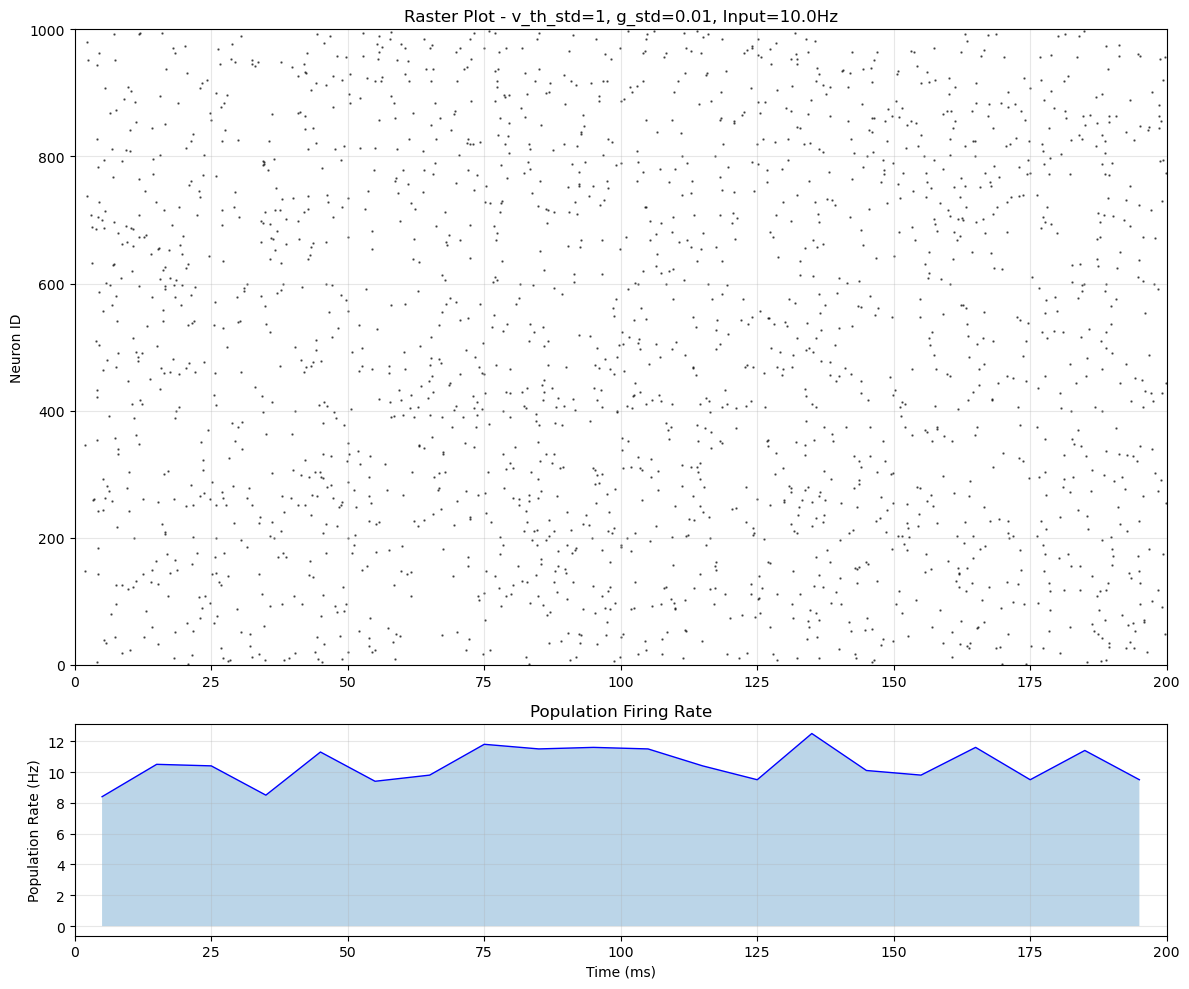


Spike Statistics:
  Total spikes: 2090
  Mean firing rate: 10.45 ± 8.22 Hz
  Silent neurons: 141 (14.1%)
  Active neurons: 859 (85.9%)
  Min firing rate: 0.00 Hz
  Max firing rate: 50.00 Hz


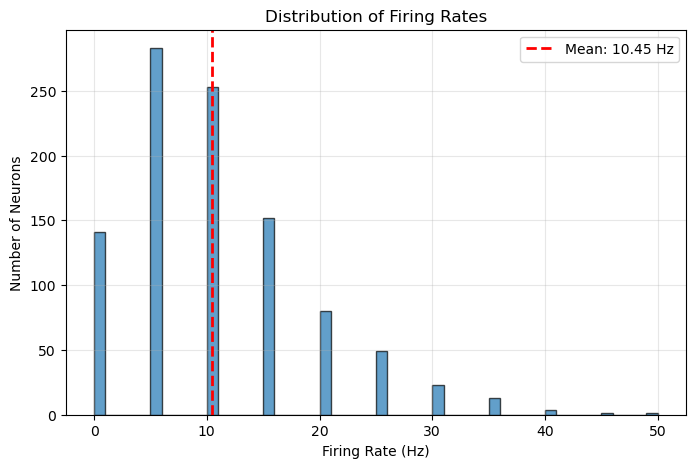


Simulation complete! You can now:
  1. Modify parameters above and re-run
  2. Try different synaptic modes ('immediate' vs 'dynamic')
  3. Explore different input rates
  4. Uncomment parameter comparison section
  5. Add perturbations using network.inject_perturbation(neuron_id)


In [13]:
# Single Trial Simulation and Raster Plot
# Import necessary modules and run a single simulation

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src directory to path for imports
sys.path.append('src')
sys.path.append('analysis')

# Import the required classes
from spiking_network import SpikingRNN
from rng_utils import get_rng

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

# Network parameters
n_neurons = 1000
dt = 0.1  # ms
synaptic_mode = "immediate"  # or "immediate"

# Heterogeneity parameters
session_id = 1
v_th_std = 1  # Threshold heterogeneity
g_std = 0.01     # Synaptic weight heterogeneity
trial_id = 1

# Simulation parameters
duration = 200.0  # 2 seconds in milliseconds
static_input_rate = 10.0  # Hz

# Additional network parameters
v_th_distribution = "normal"
network1_params = {
    'v_th_distribution': v_th_distribution,
    'static_input_strength': 10.0,  # Try increasing this value
    'dynamic_input_strength': 1.0,
    'readout_weight_scale': 1.0
}

print(f"Simulation Parameters:")
print(f"  Network size: {n_neurons} neurons")
print(f"  Duration: {duration} ms")
print(f"  v_th_std: {v_th_std}")
print(f"  g_std: {g_std}")
print(f"  Static input rate: {static_input_rate} Hz")
print(f"  Synaptic mode: {synaptic_mode}")

# =============================================================================
# CREATE AND INITIALIZE NETWORK
# =============================================================================

# Create network
network1 = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode=synaptic_mode)

# Initialize network structure (depends on session + parameters)
network1.initialize_network(session_id, v_th_std, g_std, **network1_params)

print(f"\nNetwork initialized successfully!")

# Get network information
network1_info = network1.get_network_info()
print(f"  Threshold mean: {network1_info['threshold_mean']:.2f} mV")
print(f"  Threshold std: {network1_info['threshold_std']:.3f} mV")
print(f"  Weight connections: {network1_info['weight_matrix_nnz']}")
print(f"  Weight mean: {network1_info['weight_mean']:.3f}")
print(f"  Weight std: {network1_info['weight_std']:.3f}")

# =============================================================================
# RUN SIMULATION
# =============================================================================

print(f"\nRunning simulation...")

# MANUAL OVERRIDE: Set identical initial conditions for testing
# print("Overriding initial conditions to be identical...")
# network.neurons.v_membrane = np.full(n_neurons, -70.0)  # All start at resting potential
# network.neurons.refractory_timer = np.zeros(n_neurons)  # No refractory
# network.neurons.last_spike_time = -np.inf * np.ones(n_neurons)  # No previous spikes

# print(f"All neurons initialized to: {network.neurons.v_membrane[0]:.1f} mV")
network1.synapses.weight_matrix.data[:] = 0
# Run the simulation
spike_times_1 = network1.simulate_network_dynamics(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=duration,
    static_input_rate=static_input_rate
)

print(f"Simulation completed!")
print(f"  Total spikes: {len(spike_times_1)}")
print(f"  Average firing rate: {len(spike_times_1) / (duration/1000) / n_neurons:.2f} Hz")

# =============================================================================
# CREATE RASTER PLOT
# =============================================================================

def plot_raster(spike_times, duration, n_neurons, title_suffix=""):
    """Create a raster plot from spike times"""
    
    if not spike_times:
        print("No spikes to plot!")
        return
    
    # Extract spike times and neuron IDs
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Main raster plot
    ax1.scatter(times, neuron_ids, s=0.5, alpha=0.6, c='black')
    ax1.set_ylabel('Neuron ID')
    ax1.set_title(f'Raster Plot - {title_suffix}')
    ax1.set_xlim(0, duration)
    ax1.set_ylim(0, n_neurons)
    ax1.grid(True, alpha=0.3)
    
    # Population firing rate (binned)
    bin_size = 10.0  # ms
    bins = np.arange(0, duration + bin_size, bin_size)
    spike_counts, _ = np.histogram(times, bins=bins)
    firing_rate = spike_counts / (bin_size / 1000.0) / n_neurons  # Hz
    bin_centers = bins[:-1] + bin_size/2
    
    ax2.plot(bin_centers, firing_rate, 'b-', linewidth=1)
    ax2.fill_between(bin_centers, firing_rate, alpha=0.3)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Population Rate (Hz)')
    ax2.set_title('Population Firing Rate')
    ax2.set_xlim(0, duration)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create raster plot
title_suffix = f"v_th_std={v_th_std}, g_std={g_std}, Input={static_input_rate}Hz"
fig = plot_raster(spike_times_1, duration, n_neurons, title_suffix)

# =============================================================================
# DETAILED ANALYSIS
# =============================================================================

def analyze_spike_statistics(spike_times, duration, n_neurons):
    """Analyze basic spike statistics"""
    
    if not spike_times:
        return
    
    times = [spike[0] for spike in spike_times]
    neuron_ids = [spike[1] for spike in spike_times]
    
    # Per-neuron spike counts
    spike_counts = np.zeros(n_neurons)
    for neuron_id in neuron_ids:
        spike_counts[neuron_id] += 1
    
    # Firing rates per neuron
    firing_rates = spike_counts / (duration / 1000.0)  # Hz
    
    # Statistics
    total_spikes = len(spike_times)
    mean_rate = np.mean(firing_rates)
    std_rate = np.std(firing_rates)
    silent_neurons = np.sum(firing_rates == 0)
    active_neurons = n_neurons - silent_neurons
    
    print(f"\nSpike Statistics:")
    print(f"  Total spikes: {total_spikes}")
    print(f"  Mean firing rate: {mean_rate:.2f} ± {std_rate:.2f} Hz")
    print(f"  Silent neurons: {silent_neurons} ({silent_neurons/n_neurons*100:.1f}%)")
    print(f"  Active neurons: {active_neurons} ({active_neurons/n_neurons*100:.1f}%)")
    print(f"  Min firing rate: {np.min(firing_rates):.2f} Hz")
    print(f"  Max firing rate: {np.max(firing_rates):.2f} Hz")
    
    # Plot firing rate distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(firing_rates, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(mean_rate, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_rate:.2f} Hz')
    ax.set_xlabel('Firing Rate (Hz)')
    ax.set_ylabel('Number of Neurons')
    ax.set_title('Distribution of Firing Rates')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'firing_rates': firing_rates,
        'mean_rate': mean_rate,
        'std_rate': std_rate,
        'silent_neurons': silent_neurons,
        'active_neurons': active_neurons
    }

# Analyze the results
stats = analyze_spike_statistics(spike_times_1, duration, n_neurons)

# =============================================================================
# PARAMETER EXPLORATION FUNCTION
# =============================================================================

def run_parameter_comparison(v_th_stds, g_stds, input_rate=200.0, duration=1000.0):
    """Compare different parameter combinations"""
    
    fig, axes = plt.subplots(len(v_th_stds), len(g_stds), figsize=(15, 12))
    if len(v_th_stds) == 1:
        axes = axes.reshape(1, -1)
    if len(g_stds) == 1:
        axes = axes.reshape(-1, 1)
    
    results = []
    
    for i, v_th in enumerate(v_th_stds):
        for j, g in enumerate(g_stds):
            print(f"Running v_th_std={v_th}, g_std={g}...")
            
            # Create new network
            net = SpikingRNN(n_neurons=500, dt=dt, synaptic_mode=synaptic_mode)  # Smaller for speed
            net.initialize_network(session_id, v_th, g, **network_params)
            
            # Run simulation
            spikes = net.simulate_network_dynamics(
                session_id=session_id, v_th_std=v_th, g_std=g, trial_id=trial_id,
                duration=duration, static_input_rate=input_rate
            )
            
            # Extract data for plotting
            times = [spike[0] for spike in spikes]
            neuron_ids = [spike[1] for spike in spikes]
            
            # Plot mini raster
            ax = axes[i, j]
            if spikes:
                ax.scatter(times, neuron_ids, s=0.3, alpha=0.6, c='black')
            ax.set_title(f'v_th={v_th:.1f}, g={g:.1f}')
            ax.set_xlim(0, duration)
            ax.set_ylim(0, 500)
            
            if i == len(v_th_stds) - 1:
                ax.set_xlabel('Time (ms)')
            if j == 0:
                ax.set_ylabel('Neuron ID')
            
            # Store results
            firing_rate = len(spikes) / (duration/1000) / 500
            results.append({
                'v_th_std': v_th,
                'g_std': g,
                'n_spikes': len(spikes),
                'firing_rate': firing_rate
            })
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example parameter comparison (uncomment to run)
# print("\nParameter Comparison:")
# comparison_results = run_parameter_comparison([0.1, 0.5], [0.1, 0.5], input_rate=200.0, duration=1000.0)
# for result in comparison_results:
#     print(f"v_th_std={result['v_th_std']}, g_std={result['g_std']}: {result['firing_rate']:.2f} Hz")

print(f"\nSimulation complete! You can now:")
print(f"  1. Modify parameters above and re-run")
print(f"  2. Try different synaptic modes ('immediate' vs 'dynamic')")
print(f"  3. Explore different input rates")
print(f"  4. Uncomment parameter comparison section")
print(f"  5. Add perturbations using network.inject_perturbation(neuron_id)")

In [14]:
network.synapses.weight_matrix.data

array([ 0.00384946,  0.00108354, -0.00961457, ...,  0.00010515,
        0.00966293,  0.00516385])

In [15]:
network1.synapses.weight_matrix.data

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
are_identical = spike_times == spike_times_1
print("Are spike lists identical?", are_identical)

Are spike lists identical? False


In [17]:
are_identical = (network1.neurons.spike_thresholds == network.neurons.spike_thresholds).all()
print("Are spike lists identical?", are_identical)

Are spike lists identical? True
